In [2]:
import pandas as pd 
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import resample
import os
from scipy.stats import pearsonr
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib_venn
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.lines as lines
import matplotlib.ticker as ticker
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
import matplotlib.patheffects as path_effects
import matplotlib.transforms as transforms

In [10]:
# Define a function for CA
def commonality_analysis(features_g_pred, target_g_real):
    if len(features_g_pred.shape)<2:
        r2 = LinearRegression().fit(features_g_pred.values.reshape(-1, 1), target_g_real).score(features_g_pred.values.reshape(-1, 1), target_g_real).round(4)
    else:
        r2 = LinearRegression().fit(features_g_pred, target_g_real).score(features_g_pred, target_g_real).round(4)
    return r2

# Main analysis: no demo, only brain and mental health

# RS Stacked

In [ ]:
# Get R2 for each model
folds = ['0','1','2','3','4']
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
all_g_mh_rs_concat = []
for fold in folds:
    g_pred_rs_idp_rf = pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_rs_idp_rf, on='eid').drop(columns=['eid'])
    all_g.columns = ['g_real', 'g_pred_mh', 'g_pred_rs_ts']
    all_g_mh_rs_concat.append(all_g)
    all_g_mh_rs = pd.concat(all_g_mh_rs_concat, axis=0, ignore_index=True)
    all_g_mh_rs.to_csv('/commonality_analysis/rs/g_real_pred_mh_rs-idp-atlases.csv', index=False)

model = LinearRegression()
r2_mh_rs = model.fit(all_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), all_g_mh_rs['g_real']).score(all_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), all_g_mh_rs['g_real'])
r2_rs = model.fit(all_g_mh_rs['g_pred_rs_ts'].values.reshape(-1, 1), all_g_mh_rs['g_real']).score(all_g_mh_rs['g_pred_rs_ts'].values.reshape(-1, 1), all_g_mh_rs['g_real'])
r2_mh_and_rs = model.fit(pd.concat([all_g_mh_rs['g_pred_rs_ts'], all_g_mh_rs['g_pred_mh']], axis=1), all_g_mh_rs['g_real']).score(pd.concat([all_g_mh_rs['g_pred_rs_ts'], all_g_mh_rs['g_pred_mh']], axis=1), all_g_mh_rs['g_real'])

#### Run CA

In [ ]:
all_g_mh_rs = pd.read_csv('/commonality_analysis/rs/g_real_pred_mh_rs-idp-atlases.csv')
r2_mh_rs = commonality_analysis(all_g_mh_rs['g_pred_mh'], all_g_mh_rs['g_real'])
r2_rs = commonality_analysis(all_g_mh_rs['g_pred_rs_ts'], all_g_mh_rs['g_real'])
r2_mh_and_rs = commonality_analysis(pd.concat([all_g_mh_rs['g_pred_rs_ts'], all_g_mh_rs['g_pred_mh']], axis=1), all_g_mh_rs['g_real'])

In [ ]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

u_mh_rs = r2_mh_and_rs - r2_rs
u_rs = r2_mh_and_rs - r2_mh_rs

c_mh_and_rs = r2_mh_and_rs - u_mh_rs - u_rs

print("R squared for MH:", r2_mh_rs.round(3)) # f"{r2_mh_rs_m:.5f}")
print("R squared for RS", r2_rs.round(3))
print("R squared for MH and RS", r2_mh_and_rs.round(3))

print('_______________')
print("Unique variance for MH:", u_mh_rs.round(3)) #"{:.5f}".format(u_mh_rs)) # "{:.5f}".format(u_mh_rs)
print("Unique variance for RS:", u_rs.round(3)) #f"{u_rs:.5f}")

print('_______________')

print("Common variance for MH and RS:", c_mh_and_rs.round(3))
print('_______________')
perc_mh = u_mh_rs / r2_mh_and_rs * 100 #u_mh_rs / R squared for MH and RS
perc_rs = u_rs / r2_mh_and_rs * 100 #u_rs / R squared for MH and RS
perc_c = c_mh_and_rs / r2_mh_and_rs * 100 #c_mh_and_rs / R squared for MH and RS

print(f"Proportion of unique variance attributed to MH is {perc_mh.round(2)}")
print(f"Proportion of unique variance attributed to Resting state (atlases) is {perc_rs.round(2)}")
print(f"Proportion of common variance attributed to MH and Resting state (atlases) is {perc_c.round(2)}")

R squared for MH: 0.09
R squared for RS 0.096
R squared for MH and RS 0.159
_______________
Unique variance for MH: 0.063
Unique variance for RS: 0.07
_______________
Common variance for MH and RS: 0.027
_______________
Proportion of unique variance attributed to MH is 39.5
Proportion of unique variance attributed to Resting state (atlases) is 43.71
Proportion of common variance attributed to MH and Resting state (atlases) is 16.79


# RS PLS

In [ ]:
# 1 Match g: original, from mental health, and from resting state
folds = [f'{i}' for i in range(5)]
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pls_g_mh_rs_concat = []
for fold in folds:
    g_pred_pls_test_rs = pd.read_csv(f'/PLS/brain/stacking/features_test_level1_stacked/rs_idp_ts_best_metrics/features_test_level1_g_matched_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    pls_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_pls_test_rs, on='eid').drop(columns=['eid'])
    pls_g_mh_rs_concat.append(pls_g)
    pls_g_mh_rs = pd.concat(pls_g_mh_rs_concat, axis=0, ignore_index=True)
    pls_g_mh_rs.to_csv('/commonality_analysis/rs/pls/g_real_pred_mh_rs-pls.csv', index=False)

In [ ]:
# 2 Extract R2 with commonality_analysis function
pls_g_mh_rs = pd.read_csv('/commonality_analysis/rs/pls/g_real_pred_mh_rs-pls.csv')
r2_mh_from_rs_pls = LinearRegression().fit(pls_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_rs['g']).score(pls_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_rs['g'])

rs_cols= [
    'aparc_s1_full_correlation', 'aparc_2009_s1_full_correlation', 
    'glasser_s1_full_correlation', 'glasser_s4_full_correlation', 
    'Schaefer7n200p_s1_full_correlation', 'Schaefer7n500p_s4_full_correlation', 
    'amplitudes_21', 'amplitudes_55', 'tangent_matrices_21', 'tangent_matrices_55'
]
r2_rs = {}
for col in rs_cols:
    r2_score = commonality_analysis(pls_g_mh_rs[col], pls_g_mh_rs['g'])
    r2_rs[col] = r2_score
    globals()[f'r2_{col}'] = r2_score

# Iterate through each column to combine with 'g_pred_mh'
r2_mh_and_rs = {}
for col in rs_cols:
    combined_columns = pd.concat([pls_g_mh_rs[col], pls_g_mh_rs['g_pred_mh']], axis=1)
    r2_combined = commonality_analysis(combined_columns, pls_g_mh_rs['g'])
    r2_mh_and_rs[f'r2_mh_and_{col}'] = r2_combined
    # Create a variable for each combined R^2 score
    globals()[f'r2_mh_and_{col}'] = r2_combined

In [ ]:
# Save R2 dictionaries
with open('/commonality_analysis/rs/pls/r2_rs.pkl', 'wb') as f:
    pickle.dump(r2_rs, f)

with open('/commonality_analysis/rs/pls/r2_mh_and_rs.pkl', 'wb') as f:
    pickle.dump(r2_mh_and_rs, f)

In [30]:
# 3 Calculate  unique and common variances
unique_mh = {}
unique_rs = {}
common_mh_rs = {}

for key in r2_mh_and_rs:
    rs_key = key.replace('r2_mh_and_', '')
    u_mh = r2_mh_and_rs[key] - r2_rs[rs_key]
    u_rs = r2_mh_and_rs[key] - r2_mh_from_rs_pls #[key]
    c_mh_and_rs = r2_mh_and_rs[key] - u_mh - u_rs
    
    unique_mh[f'u_mh_from_{rs_key}'] = u_mh
    unique_rs[f'u_rs_{rs_key}'] = u_rs
    common_mh_rs[f'c_mh_and_rs_{rs_key}'] = c_mh_and_rs

# Print results
for key in r2_mh_and_rs:
    rs_key = key.replace('r2_mh_and_', '')
    print(f"R squared for {rs_key}: {r2_rs[rs_key]:.3f}")
    print(f"R squared for MH and {rs_key}: {r2_mh_and_rs[key]:.3f}")
    print(f"Unique variance for MH ({rs_key}): {unique_mh[f'u_mh_from_{rs_key}']:.3f}")
    print(f"Unique variance for RS ({rs_key}): {unique_rs[f'u_rs_{rs_key}']:.3f}")
    print(f"Common variance for MH and RS ({rs_key}): {common_mh_rs[f'c_mh_and_rs_{rs_key}']:.3f}")
    print('_______________')

# Calculate proportions
for key in r2_mh_and_rs:
    rs_key = key.replace('r2_mh_and_', '')
    perc_mh = unique_mh[f'u_mh_from_{rs_key}'] / r2_mh_and_rs[key] * 100
    perc_rs = unique_rs[f'u_rs_{rs_key}'] / r2_mh_and_rs[key] * 100
    perc_c = common_mh_rs[f'c_mh_and_rs_{rs_key}'] / r2_mh_and_rs[key] * 100
    
    print(f"Proportion of unique variance attributed to MH ({rs_key}): {perc_mh:.2f}%")
    print(f"Proportion of unique variance attributed to RS ({rs_key}): {perc_rs:.2f}%")
    print(f"Proportion of common variance attributed to MH and RS ({rs_key}): {perc_c:.2f}%")
    print('_______________')

R squared for aparc_s1_full_correlation: 0.049
R squared for MH and aparc_s1_full_correlation: 0.123
Unique variance for MH (aparc_s1_full_correlation): 0.074
Unique variance for RS (aparc_s1_full_correlation): 0.033
Common variance for MH and RS (aparc_s1_full_correlation): 0.015
_______________
R squared for aparc_2009_s1_full_correlation: 0.050
R squared for MH and aparc_2009_s1_full_correlation: 0.124
Unique variance for MH (aparc_2009_s1_full_correlation): 0.074
Unique variance for RS (aparc_2009_s1_full_correlation): 0.035
Common variance for MH and RS (aparc_2009_s1_full_correlation): 0.015
_______________
R squared for glasser_s1_full_correlation: 0.057
R squared for MH and glasser_s1_full_correlation: 0.131
Unique variance for MH (glasser_s1_full_correlation): 0.074
Unique variance for RS (glasser_s1_full_correlation): 0.041
Common variance for MH and RS (glasser_s1_full_correlation): 0.015
_______________
R squared for glasser_s4_full_correlation: 0.054
R squared for MH and g

In [ ]:
# Save unique and common variances
with open('/commonality_analysis/rs/pls/unique_mh.pkl', 'wb') as f:
    pickle.dump(unique_mh, f)

with open('/commonality_analysis/rs/pls/unique_rs.pkl', 'wb') as f:
    pickle.dump(unique_rs, f)

with open('/commonality_analysis/rs/pls/common_mh_rs.pkl', 'wb') as f:
    pickle.dump(common_mh_rs, f)

#### Upload CA variables for RS

In [ ]:
# R2
pls_g_mh_rs = pd.read_csv('/commonality_analysis/rs/pls/g_real_pred_mh_rs-pls.csv')
r2_mh_from_rs_pls = LinearRegression().fit(pls_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_rs['g']).score(pls_g_mh_rs['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_rs['g'])

# Load R2 dictionaries from pickle files
with open('/commonality_analysis/rs/pls/r2_rs.pkl', 'rb') as f:
    r2_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/r2_mh_and_rs.pkl', 'rb') as f:
    r2_mh_and_rs = pickle.load(f)

# Extract variables
for col in r2_rs:
    globals()[col] = round(r2_rs[col] * 100, 3)
    r2_rs[col] = round(r2_rs[col] * 100, 3)  # Update the dictionary with rounded values

for col in r2_mh_and_rs:
    globals()[f'r2_mh_and_{col}'] = round(r2_mh_and_rs[col] * 100, 3)
    r2_mh_and_rs[col] = round(r2_mh_and_rs[col] * 100, 3)

print(r2_rs)
print(r2_mh_and_rs)

{'aparc_s1_full_correlation': 4.85, 'aparc_2009_s1_full_correlation': 5.0, 'glasser_s1_full_correlation': 5.67, 'glasser_s4_full_correlation': 5.4, 'Schaefer7n200p_s1_full_correlation': 6.76, 'Schaefer7n500p_s4_full_correlation': 5.95, 'amplitudes_21': 1.13, 'amplitudes_55': 1.97, 'tangent_matrices_21': 4.93, 'tangent_matrices_55': 8.13}
{'r2_mh_and_aparc_s1_full_correlation': 12.28, 'r2_mh_and_aparc_2009_s1_full_correlation': 12.45, 'r2_mh_and_glasser_s1_full_correlation': 13.08, 'r2_mh_and_glasser_s4_full_correlation': 12.83, 'r2_mh_and_Schaefer7n200p_s1_full_correlation': 13.73, 'r2_mh_and_Schaefer7n500p_s4_full_correlation': 13.3, 'r2_mh_and_amplitudes_21': 9.71, 'r2_mh_and_amplitudes_55': 10.29, 'r2_mh_and_tangent_matrices_21': 12.46, 'r2_mh_and_tangent_matrices_55': 14.77}


In [ ]:
# U/C
with open('/commonality_analysis/rs/pls/unique_mh.pkl', 'rb') as f:
    unique_mh = pickle.load(f)

with open('/commonality_analysis/rs/pls/unique_rs.pkl', 'rb') as f:
    unique_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/common_mh_rs.pkl', 'rb') as f:
    common_mh_rs = pickle.load(f)

# Extract variables
for key in unique_mh:
    globals()[key] = round(unique_mh[key] * 100, 3)
    unique_mh[key] = round(unique_mh[key] * 100, 3)  # Update the dictionary with rounded values

for key in unique_rs:
    globals()[key] = round(unique_rs[key] * 100, 3)
    unique_rs[key] = round(unique_rs[key] * 100, 3) 

for key in common_mh_rs:
    globals()[key] = round(common_mh_rs[key] * 100, 3)
    common_mh_rs[key] = round(common_mh_rs[key] * 100, 3)

print(unique_mh)
print(unique_rs)
print(common_mh_rs)

{'u_mh_from_aparc_s1_full_correlation': 7.43, 'u_mh_from_aparc_2009_s1_full_correlation': 7.45, 'u_mh_from_glasser_s1_full_correlation': 7.41, 'u_mh_from_glasser_s4_full_correlation': 7.43, 'u_mh_from_Schaefer7n200p_s1_full_correlation': 6.97, 'u_mh_from_Schaefer7n500p_s4_full_correlation': 7.35, 'u_mh_from_amplitudes_21': 8.58, 'u_mh_from_amplitudes_55': 8.32, 'u_mh_from_tangent_matrices_21': 7.53, 'u_mh_from_tangent_matrices_55': 6.64}
{'u_rs_aparc_s1_full_correlation': 3.335, 'u_rs_aparc_2009_s1_full_correlation': 3.505, 'u_rs_glasser_s1_full_correlation': 4.135, 'u_rs_glasser_s4_full_correlation': 3.885, 'u_rs_Schaefer7n200p_s1_full_correlation': 4.785, 'u_rs_Schaefer7n500p_s4_full_correlation': 4.355, 'u_rs_amplitudes_21': 0.765, 'u_rs_amplitudes_55': 1.345, 'u_rs_tangent_matrices_21': 3.515, 'u_rs_tangent_matrices_55': 5.825}
{'c_mh_and_rs_aparc_s1_full_correlation': 1.515, 'c_mh_and_rs_aparc_2009_s1_full_correlation': 1.495, 'c_mh_and_rs_glasser_s1_full_correlation': 1.535, 'c_m

##########################################################

# DTI Stacked

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
all_g_mh_dti_all_concat = []

for fold in folds:
    g_pred_dti_all_rf = pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_dti_all_rf, on='eid').drop(columns=['eid'])
    all_g.columns = ['g_real', 'g_pred_mh', 'g_pred_dti_all']
    all_g_mh_dti_all_concat.append(all_g)
    all_g_mh_dti_all = pd.concat(all_g_mh_dti_all_concat, axis=0, ignore_index=True)
    all_g_mh_dti_all.to_csv('/commonality_analysis/dti/g_real_pred_mh_dti-all.csv', index=False)

model = LinearRegression()
r2_mh_dti = model.fit(all_g_mh_dti_all['g_pred_mh'].values.reshape(-1, 1), all_g_mh_dti_all['g_real']).score(all_g_mh_dti_all['g_pred_mh'].values.reshape(-1, 1), all_g_mh_dti_all['g_real'])
r2_dti = model.fit(all_g_mh_dti_all['g_pred_dti_all'].values.reshape(-1, 1), all_g_mh_dti_all['g_real']).score(all_g_mh_dti_all['g_pred_dti_all'].values.reshape(-1, 1), all_g_mh_dti_all['g_real'])
r2_mh_and_dti = model.fit(pd.concat([all_g_mh_dti_all['g_pred_dti_all'], all_g_mh_dti_all['g_pred_mh']], axis=1), all_g_mh_dti_all['g_real']).score(pd.concat([all_g_mh_dti_all['g_pred_dti_all'], all_g_mh_dti_all['g_pred_mh']], axis=1), all_g_mh_dti_all['g_real'])

#### Run CA

In [ ]:
all_g_mh_dti_all = pd.read_csv('/commonality_analysis/dti/g_real_pred_mh_dti-all.csv')
r2_mh_dti = commonality_analysis(all_g_mh_dti_all['g_pred_mh'], all_g_mh_dti_all['g_real'])
r2_dti = commonality_analysis(all_g_mh_dti_all['g_pred_dti_all'], all_g_mh_dti_all['g_real'])
r2_mh_and_dti = commonality_analysis(pd.concat([all_g_mh_dti_all['g_pred_dti_all'], all_g_mh_dti_all['g_pred_mh']], axis=1), all_g_mh_dti_all['g_real'])

In [ ]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

u_mh_dti = r2_mh_and_dti - r2_dti
u_dti = r2_mh_and_dti - r2_mh_dti

c_mh_and_dti = r2_mh_and_dti - u_mh_dti - u_dti

print("R squared for MH:", r2_mh_dti.round(3)) # f"{r2_mh_m:.5f}")
print("R squared for DTI All", r2_dti.round(3))
print("R squared for MH and DTI All", r2_mh_and_dti.round(3))

print('_______________')
print("Unique variance for MH:", u_mh_dti.round(3)) #"{:.5f}".format(u_mh_dti)) # "{:.5f}".format(u_mh_for_dti)
print("Unique variance for DTI All:", u_dti.round(3)) #f"{u_rs:.5f}")

print('_______________')
print("Common variance for MH and DTI All:", c_mh_and_dti.round(3))
print('_______________')
perc_mh = u_mh_dti / r2_mh_and_dti * 100 #u_mh_dti / R squared for MH and DTI All
perc_dti = u_dti / r2_mh_and_dti * 100 #u_rs / R squared for MH and DTI All
perc_c = c_mh_and_dti / r2_mh_and_dti * 100 #c_mh_rs / R squared for MH and DTI All

print(f"Proportion of unique variance attributed to MH is {perc_mh.round(2)}")
print(f"Proportion of unique variance attributed to DTI All is {perc_dti.round(2)}")
print(f"Proportion of common variance attributed to MH and DTI All is {perc_c.round(2)}")

R squared for MH: 0.09
R squared for DTI All 0.071
R squared for MH and DTI All 0.138
_______________
Unique variance for MH: 0.067
Unique variance for DTI All: 0.048
_______________
Common variance for MH and DTI All: 0.023
_______________
Proportion of unique variance attributed to MH is 48.73
Proportion of unique variance attributed to DTI All is 34.61
Proportion of common variance attributed to MH and DTI All is 16.65


# DTI PLS

In [ ]:
# 1 Match g: original, from mental health, and from DTI
folds = [f'{i}' for i in range(5)]
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pls_g_mh_dti_concat = []
for fold in folds:
    g_pred_pls_test_dti = pd.read_csv(f'/PLS/brain/stacking/features_test_level1_stacked/dti_all/features_test_level1_g_matched_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    pls_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_pls_test_dti, on='eid').drop(columns=['eid'])
    #pls_g.columns = ['g_real', 'g_pred_mh', 'g_pred_dti_ts']
    pls_g_mh_dti_concat.append(pls_g)
    pls_g_mh_dti = pd.concat(pls_g_mh_dti_concat, axis=0, ignore_index=True)
    pls_g_mh_dti.to_csv('/commonality_analysis/dti/pls/g_real_pred_mh_dti-pls.csv', index=False)

#### Run CA

In [ ]:
# 2 Extract R2 with commonality_analysis function
pls_g_mh_dti = pd.read_csv('/commonality_analysis/dti/pls/g_real_pred_mh_dti-pls.csv')
r2_mh_from_dti_pls = LinearRegression().fit(pls_g_mh_dti['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_dti['g']).score(pls_g_mh_dti['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_dti['g'])

dti_cols= pls_g_mh_dti.columns[2:].to_list()

r2_dti = {}
for col in dti_cols:
    r2_score = commonality_analysis(pls_g_mh_dti[col], pls_g_mh_dti['g'])
    r2_dti[col] = r2_score
    globals()[f'r2_{col}'] = r2_score

# Iterate through each column to combine with 'g_pred_mh'
r2_mh_and_dti = {}
for col in dti_cols:
    combined_columns = pd.concat([pls_g_mh_dti[col], pls_g_mh_dti['g_pred_mh']], axis=1)
    r2_combined = commonality_analysis(combined_columns, pls_g_mh_dti['g'])
    r2_mh_and_dti[f'r2_mh_and_{col}'] = r2_combined
    # Create a variable for each combined R^2 score
    globals()[f'r2_mh_and_{col}'] = r2_combined

In [ ]:
# Save R2 dictionaries
with open('/commonality_analysis/dti/pls/r2_dti.pkl', 'wb') as f:
    pickle.dump(r2_dti, f)

with open('/commonality_analysis/dti/pls/r2_mh_and_dti.pkl', 'wb') as f:
    pickle.dump(r2_mh_and_dti, f)

In [41]:
# 3 Calculate  unique and common variances
unique_mh = {}
unique_dti = {}
common_mh_dti = {}

for key in r2_mh_and_dti:
    dti_key = key.replace('r2_mh_and_', '')
    u_mh = r2_mh_and_dti[key] - r2_dti[dti_key]
    u_dti = r2_mh_and_dti[key] - r2_mh_from_dti_pls #[key]
    c_mh_and_dti = r2_mh_and_dti[key] - u_mh - u_dti
    
    unique_mh[f'u_mh_from_{dti_key}'] = u_mh
    unique_dti[f'u_dti_{dti_key}'] = u_dti
    common_mh_dti[f'c_mh_and_dti_{dti_key}'] = c_mh_and_dti

# Print results
for key in r2_mh_and_dti:
    dti_key = key.replace('r2_mh_and_', '')
    print(f"R squared for {dti_key}: {r2_dti[dti_key]:.3f}")
    print(f"R squared for MH and {dti_key}: {r2_mh_and_dti[key]:.3f}")
    print(f"Unique variance for MH ({dti_key}): {unique_mh[f'u_mh_from_{dti_key}']:.3f}")
    print(f"Unique variance for dti ({dti_key}): {unique_dti[f'u_dti_{dti_key}']:.3f}")
    print(f"Common variance for MH and dti ({dti_key}): {common_mh_dti[f'c_mh_and_dti_{dti_key}']:.3f}")
    print('_______________')

# Calculate proportions
for key in r2_mh_and_dti:
    dti_key = key.replace('r2_mh_and_', '')
    perc_mh = unique_mh[f'u_mh_from_{dti_key}'] / r2_mh_and_dti[key] * 100
    perc_dti = unique_dti[f'u_dti_{dti_key}'] / r2_mh_and_dti[key] * 100
    perc_c = common_mh_dti[f'c_mh_and_dti_{dti_key}'] / r2_mh_and_dti[key] * 100
    
    print(f"Proportion of unique variance attributed to MH ({dti_key}): {perc_mh:.2f}%")
    print(f"Proportion of unique variance attributed to dti ({dti_key}): {perc_dti:.2f}%")
    print(f"Proportion of common variance attributed to MH and dti ({dti_key}): {perc_c:.2f}%")
    print('_______________')

R squared for fa_prob: 0.021
R squared for MH and fa_prob: 0.105
Unique variance for MH (fa_prob): 0.084
Unique variance for dti (fa_prob): 0.015
Common variance for MH and dti (fa_prob): 0.006
_______________
R squared for fa_tbss: 0.039
R squared for MH and fa_tbss: 0.117
Unique variance for MH (fa_tbss): 0.078
Unique variance for dti (fa_tbss): 0.027
Common variance for MH and dti (fa_tbss): 0.012
_______________
R squared for icvf_prob: 0.028
R squared for MH and icvf_prob: 0.109
Unique variance for MH (icvf_prob): 0.081
Unique variance for dti (icvf_prob): 0.019
Common variance for MH and dti (icvf_prob): 0.009
_______________
R squared for icvf_tbss: 0.038
R squared for MH and icvf_tbss: 0.116
Unique variance for MH (icvf_tbss): 0.078
Unique variance for dti (icvf_tbss): 0.025
Common variance for MH and dti (icvf_tbss): 0.013
_______________
R squared for isovf_prob: 0.023
R squared for MH and isovf_prob: 0.105
Unique variance for MH (isovf_prob): 0.083
Unique variance for dti (i

In [ ]:
# Save unique and common variances
with open('/commonality_analysis/dti/pls/unique_mh.pkl', 'wb') as f:
    pickle.dump(unique_mh, f)

with open('/commonality_analysis/dti/pls/unique_dti.pkl', 'wb') as f:
    pickle.dump(unique_dti, f)

with open('/commonality_analysis/dti/pls/common_mh_dti.pkl', 'wb') as f:
    pickle.dump(common_mh_dti, f)

#### Upload CA variables for DTI

In [ ]:
# R2
pls_g_mh_dti = pd.read_csv('/commonality_analysis/dti/pls/g_real_pred_mh_dti-pls.csv')
r2_mh_from_dti_pls = LinearRegression().fit(pls_g_mh_dti['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_dti['g']).score(pls_g_mh_dti['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_dti['g'])

# Load R2 dictionaries from pickle files
with open('/commonality_analysis/dti/pls/r2_dti.pkl', 'rb') as f:
    r2_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/r2_mh_and_dti.pkl', 'rb') as f:
    r2_mh_and_dti = pickle.load(f)

# Extract variables
for col in r2_dti:
    globals()[col] = round(r2_dti[col] * 100, 3)
    r2_dti[col] = round(r2_dti[col] * 100, 3)  # Update the dictionary with rounded values

for col in r2_mh_and_dti:
    globals()[f'r2_mh_and_{col}'] = round(r2_mh_and_dti[col] * 100, 3)
    r2_mh_and_dti[col] = round(r2_mh_and_dti[col] * 100, 3)

print(r2_dti)
print(r2_mh_and_dti)

{'fa_prob': 2.09, 'fa_tbss': 3.91, 'icvf_prob': 2.78, 'icvf_tbss': 3.79, 'isovf_prob': 2.27, 'isovf_tbss': 3.05, 'l1_prob': 3.14, 'l1_tbss': 4.01, 'l2_prob': 3.32, 'l2_tbss': 4.27, 'l3_prob': 3.45, 'l3_tbss': 3.92, 'md_prob': 3.69, 'md_tbss': 3.81, 'mo_prob': 0.57, 'mo_tbss': 2.55, 'od_prob': 0.86, 'od_tbss': 2.61, '31020_connectome_fa': 4.57, '31020_connectome_mean_length': 4.36, '31020_connectome_sift2': 4.59, '31020_connectome_streamline_count': 5.07, '31021_connectome_fa': 4.51, '31021_connectome_mean_length': 4.74, '31021_connectome_sift2': 4.81, '31021_connectome_streamline_count': 4.93, '31022_connectome_fa': 3.96, '31022_connectome_mean_length': 3.46, '31022_connectome_sift2': 3.91, '31022_connectome_streamline_count': 3.85, '31023_connectome_fa': 4.16, '31023_connectome_mean_length': 3.56, '31023_connectome_sift2': 4.36, '31023_connectome_streamline_count': 4.28, '31024_connectome_fa': 4.61, '31024_connectome_mean_length': 4.02, '31024_connectome_sift2': 4.9, '31024_connectome

In [ ]:
# U/C
with open('/commonality_analysis/dti/pls/unique_mh.pkl', 'rb') as f:
    unique_mh = pickle.load(f)

with open('/commonality_analysis/dti/pls/unique_dti.pkl', 'rb') as f:
    unique_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/common_mh_dti.pkl', 'rb') as f:
    common_mh_dti = pickle.load(f)

# Extract variables
for key in unique_mh:
    globals()[key] = round(unique_mh[key] * 100, 3)
    unique_mh[key] = round(unique_mh[key] * 100, 3)

for key in unique_dti:
    globals()[key] = round(unique_dti[key] * 100, 3)
    unique_dti[key] = round(unique_dti[key] * 100, 3) 

for key in common_mh_dti:
    globals()[key] = round(common_mh_dti[key] * 100, 3)
    common_mh_dti[key] = round(common_mh_dti[key] * 100, 3)

print(unique_mh)
print(unique_dti)
print(common_mh_dti)

{'u_mh_from_fa_prob': 8.39, 'u_mh_from_fa_tbss': 7.82, 'u_mh_from_icvf_prob': 8.12, 'u_mh_from_icvf_tbss': 7.77, 'u_mh_from_isovf_prob': 8.28, 'u_mh_from_isovf_tbss': 8.11, 'u_mh_from_l1_prob': 7.96, 'u_mh_from_l1_tbss': 7.73, 'u_mh_from_l2_prob': 7.94, 'u_mh_from_l2_tbss': 7.66, 'u_mh_from_l3_prob': 7.92, 'u_mh_from_l3_tbss': 7.8, 'u_mh_from_md_prob': 7.85, 'u_mh_from_md_tbss': 7.87, 'u_mh_from_mo_prob': 8.84, 'u_mh_from_mo_tbss': 8.17, 'u_mh_from_od_prob': 8.7, 'u_mh_from_od_tbss': 8.12, 'u_mh_from_31020_connectome_fa': 7.43, 'u_mh_from_31020_connectome_mean_length': 7.54, 'u_mh_from_31020_connectome_sift2': 7.46, 'u_mh_from_31020_connectome_streamline_count': 7.29, 'u_mh_from_31021_connectome_fa': 7.48, 'u_mh_from_31021_connectome_mean_length': 7.46, 'u_mh_from_31021_connectome_sift2': 7.36, 'u_mh_from_31021_connectome_streamline_count': 7.38, 'u_mh_from_31022_connectome_fa': 7.81, 'u_mh_from_31022_connectome_mean_length': 7.93, 'u_mh_from_31022_connectome_sift2': 7.72, 'u_mh_from_3

##########################################################

# T1/T2 Stacked

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

all_g_mh_t1_concat = []

for fold in folds:
    g_pred_t1_svr = pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_t1_svr, on='eid').drop(columns=['eid'])
    all_g.columns = ['g_real', 'g_pred_mh', 'g_pred_t1']
    all_g_mh_t1_concat.append(all_g)
    all_g_mh_t1 = pd.concat(all_g_mh_t1_concat, axis=0, ignore_index=True)
    all_g_mh_t1.to_csv('/commonality_analysis/struct/g_real_pred_mh_t1.csv', index=False)

model = LinearRegression()
r2_mh_t1 = model.fit(all_g_mh_t1['g_pred_mh'].values.reshape(-1, 1), all_g_mh_t1['g_real'].values.reshape(-1, 1)).score(all_g_mh_t1['g_pred_mh'].values.reshape(-1, 1), all_g_mh_t1['g_real'].values.reshape(-1, 1))
r2_t1 = model.fit(all_g_mh_t1['g_pred_t1'].values.reshape(-1, 1), all_g_mh_t1['g_real'].values.reshape(-1, 1)).score(all_g_mh_t1['g_pred_t1'].values.reshape(-1, 1), all_g_mh_t1['g_real'].values.reshape(-1, 1))
r2_mh_and_t1 = model.fit(pd.concat([all_g_mh_t1['g_pred_t1'], all_g_mh_t1['g_pred_mh']], axis=1), all_g_mh_t1['g_real']).score(pd.concat([all_g_mh_t1['g_pred_t1'], all_g_mh_t1['g_pred_mh']], axis=1), all_g_mh_t1['g_real'].values.reshape(-1, 1))

#### Run CA

In [ ]:
all_g_mh_t1 = pd.read_csv('/commonality_analysis/struct/g_real_pred_mh_t1.csv')
r2_mh_t1 = commonality_analysis(all_g_mh_t1['g_pred_mh'], all_g_mh_t1['g_real'])
r2_t1 = commonality_analysis(all_g_mh_t1['g_pred_t1'], all_g_mh_t1['g_real'])
r2_mh_and_t1 = commonality_analysis(pd.concat([all_g_mh_t1['g_pred_t1'], all_g_mh_t1['g_pred_mh']], axis=1), all_g_mh_t1['g_real'])

In [ ]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

u_mh_t1 = r2_mh_and_t1 - r2_t1
u_t1 = r2_mh_and_t1 - r2_mh_t1

c_mh_and_t1 = r2_mh_and_t1 - u_mh_t1 - u_t1

print("R squared for MH:", r2_mh_t1.round(3)) # f"{r2_mh_m:.5f}")
print("R squared for T1", r2_t1.round(3))
print("R squared for MH and T1", r2_mh_and_t1.round(3))

print('_______________')
print("Unique variance for MH:", u_mh_t1.round(3))
print("Unique variance for T1:", u_t1.round(3))

print('_______________')
print("Common variance for MH and T1:", c_mh_and_t1.round(3))
print('_______________')
perc_mh = u_mh_t1 / r2_mh_and_t1 * 100
perc_t1 = u_t1 / r2_mh_and_t1 * 100
perc_c = c_mh_and_t1 / r2_mh_and_t1 * 100

print(f"Proportion of unique variance attributed to MH is {perc_mh.round(2)}")
print(f"Proportion of unique variance attributed to T1 is {perc_t1.round(2)}")
print(f"Proportion of common variance attributed to MH and T1 is {perc_c.round(2)}")

R squared for MH: 0.088
R squared for T1 0.09
R squared for MH and T1 0.151
_______________
Unique variance for MH: 0.06
Unique variance for T1: 0.063
_______________
Common variance for MH and T1: 0.028
_______________
Proportion of unique variance attributed to MH is 40.12
Proportion of unique variance attributed to T1 is 41.64
Proportion of common variance attributed to MH and T1 is 18.24


# T1/T2 PLS

In [ ]:
# 1 Match g: original, from mental health, and from sMRI
folds = [f'{i}' for i in range(5)]
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
pls_g_mh_t1_t2_concat = []
for fold in folds:
    g_pred_pls_test_t1_t2 = pd.read_csv(f'/PLS/brain/stacking/features_test_level1_stacked/t1_t2_struct/features_test_level1_g_matched_fold_{fold}.csv')
    g_pred_mh = g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    pls_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_pls_test_t1_t2, on='eid').drop(columns=['eid'])
    pls_g_mh_t1_t2_concat.append(pls_g)
    pls_g_mh_t1_t2 = pd.concat(pls_g_mh_t1_t2_concat, axis=0, ignore_index=True)
    pls_g_mh_t1_t2.to_csv('/commonality_analysis/struct/pls/g_real_pred_mh_t1_t2-pls.csv', index=False)

In [ ]:
# 2 Extract R2 with commonality_analysis function
pls_g_mh_t1_t2 = pd.read_csv('/commonality_analysis/struct/pls/g_real_pred_mh_t1_t2-pls.csv')
r2_mh_from_t1_t2_pls = LinearRegression().fit(pls_g_mh_t1_t2['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_t1_t2['g']).score(pls_g_mh_t1_t2['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_t1_t2['g'])

t1_t2_cols= pls_g_mh_t1_t2.columns[2:].to_list()

r2_t1_t2 = {}
for col in t1_t2_cols:
    r2_score = commonality_analysis(pls_g_mh_t1_t2[col], pls_g_mh_t1_t2['g'])
    r2_t1_t2[col] = r2_score
    globals()[f'r2_{col}'] = r2_score

# Iterate through each column to combine with 'g_pred_mh'
r2_mh_and_t1_t2 = {}
for col in t1_t2_cols:
    combined_columns = pd.concat([pls_g_mh_t1_t2[col], pls_g_mh_t1_t2['g_pred_mh']], axis=1)
    r2_combined = commonality_analysis(combined_columns, pls_g_mh_t1_t2['g'])
    r2_mh_and_t1_t2[f'r2_mh_and_{col}'] = r2_combined
    # Create a variable for each combined R^2 score
    globals()[f'r2_mh_and_{col}'] = r2_combined

In [ ]:
# Save R2 dictionaries
with open('/commonality_analysis/struct/pls/r2_t1_t2.pkl', 'wb') as f:
    pickle.dump(r2_t1_t2, f)

with open('/commonality_analysis/struct/pls/r2_mh_and_t1_t2.pkl', 'wb') as f:
    pickle.dump(r2_mh_and_t1_t2, f)

In [53]:
# 3 Calculate  unique and common variances
unique_mh = {}
unique_t1_t2 = {}
common_mh_t1_t2 = {}

for key in r2_mh_and_t1_t2:
    t1_t2_key = key.replace('r2_mh_and_', '')
    u_mh = r2_mh_and_t1_t2[key] - r2_t1_t2[t1_t2_key]
    u_t1_t2 = r2_mh_and_t1_t2[key] - r2_mh_from_t1_t2_pls #[key]
    c_mh_and_t1_t2 = r2_mh_and_t1_t2[key] - u_mh - u_t1_t2
    
    unique_mh[f'u_mh_from_{t1_t2_key}'] = u_mh
    unique_t1_t2[f'u_t1_t2_{t1_t2_key}'] = u_t1_t2
    common_mh_t1_t2[f'c_mh_and_t1_t2_{t1_t2_key}'] = c_mh_and_t1_t2

# Print results
for key in r2_mh_and_t1_t2:
    t1_t2_key = key.replace('r2_mh_and_', '')
    print(f"R squared for {t1_t2_key}: {r2_t1_t2[t1_t2_key]:.3f}")
    print(f"R squared for MH and {t1_t2_key}: {r2_mh_and_t1_t2[key]:.3f}")
    print(f"Unique variance for MH ({t1_t2_key}): {unique_mh[f'u_mh_from_{t1_t2_key}']:.3f}")
    print(f"Unique variance for t1_t2 ({t1_t2_key}): {unique_t1_t2[f'u_t1_t2_{t1_t2_key}']:.3f}")
    print(f"Common variance for MH and t1_t2 ({t1_t2_key}): {common_mh_t1_t2[f'c_mh_and_t1_t2_{t1_t2_key}']:.3f}")
    print('_______________')

# Calculate proportions
for key in r2_mh_and_t1_t2:
    t1_t2_key = key.replace('r2_mh_and_', '')
    perc_mh = unique_mh[f'u_mh_from_{t1_t2_key}'] / r2_mh_and_t1_t2[key] * 100
    perc_t1_t2 = unique_t1_t2[f'u_t1_t2_{t1_t2_key}'] / r2_mh_and_t1_t2[key] * 100
    perc_c = common_mh_t1_t2[f'c_mh_and_t1_t2_{t1_t2_key}'] / r2_mh_and_t1_t2[key] * 100
    
    print(f"Proportion of unique variance attributed to MH ({t1_t2_key}): {perc_mh:.2f}%")
    print(f"Proportion of unique variance attributed to t1_t2 ({t1_t2_key}): {perc_t1_t2:.2f}%")
    print(f"Proportion of common variance attributed to MH and t1_t2 ({t1_t2_key}): {perc_c:.2f}%")
    print('_______________')

R squared for struct_fast: 0.049
R squared for MH and struct_fast: 0.122
Unique variance for MH (struct_fast): 0.073
Unique variance for t1_t2 (struct_fast): 0.034
Common variance for MH and t1_t2 (struct_fast): 0.015
_______________
R squared for struct_sub_first: 0.025
R squared for MH and struct_sub_first: 0.104
Unique variance for MH (struct_sub_first): 0.080
Unique variance for t1_t2 (struct_sub_first): 0.016
Common variance for MH and t1_t2 (struct_sub_first): 0.008
_______________
R squared for struct_aseg_mean_intensity: 0.040
R squared for MH and struct_aseg_mean_intensity: 0.114
Unique variance for MH (struct_aseg_mean_intensity): 0.074
Unique variance for t1_t2 (struct_aseg_mean_intensity): 0.026
Common variance for MH and t1_t2 (struct_aseg_mean_intensity): 0.014
_______________
R squared for struct_aseg_volume: 0.058
R squared for MH and struct_aseg_volume: 0.128
Unique variance for MH (struct_aseg_volume): 0.070
Unique variance for t1_t2 (struct_aseg_volume): 0.040
Common

In [ ]:
# Save unique and common variances
with open('/commonality_analysis/struct/pls/unique_mh.pkl', 'wb') as f:
    pickle.dump(unique_mh, f)

with open('/commonality_analysis/struct/pls/unique_t1_t2.pkl', 'wb') as f:
    pickle.dump(unique_t1_t2, f)

with open('/commonality_analysis/struct/pls/common_mh_t1_t2.pkl', 'wb') as f:
    pickle.dump(common_mh_t1_t2, f)

#### Upload CA variables for T1/T2

In [ ]:
# R2
pls_g_mh_t1_t2 = pd.read_csv('/commonality_analysis/struct/pls/g_real_pred_mh_t1_t2-pls.csv')
r2_mh_from_t1_t2_pls = LinearRegression().fit(pls_g_mh_t1_t2['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_t1_t2['g']).score(pls_g_mh_t1_t2['g_pred_mh'].values.reshape(-1, 1), pls_g_mh_t1_t2['g'])

# Load R2 dictionaries from pickle files
with open('/commonality_analysis/struct/pls/r2_t1_t2.pkl', 'rb') as f:
    r2_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/r2_mh_and_t1_t2.pkl', 'rb') as f:
    r2_mh_and_t1_t2 = pickle.load(f)

# Extract variables
for col in r2_t1_t2:
    globals()[col] = round(r2_t1_t2[col] * 100, 3)
    r2_t1_t2[col] = round(r2_t1_t2[col] * 100, 3)  # Update the dictionary with rounded values

for col in r2_mh_and_t1_t2:
    globals()[f'r2_mh_and_{col}'] = round(r2_mh_and_t1_t2[col] * 100, 3)
    r2_mh_and_t1_t2[col] = round(r2_mh_and_t1_t2[col] * 100, 3)

print(r2_t1_t2)
print(r2_mh_and_t1_t2)

{'struct_fast': 4.92, 'struct_sub_first': 2.46, 'struct_aseg_mean_intensity': 3.96, 'struct_aseg_volume': 5.8, 'struct_ba_exvivo_area': 1.14, 'struct_ba_exvivo_mean_thickness': 1.49, 'struct_ba_exvivo_volume': 2.17, 'struct_a2009s_area': 2.46, 'struct_a2009s_mean_thickness': 2.44, 'struct_a2009s_volume': 3.19, 'struct_dkt_area': 1.74, 'struct_dkt_mean_thickness': 2.16, 'struct_dkt_volume': 2.33, 'struct_desikan_gw': 3.85, 'struct_desikan_pial': 2.04, 'struct_desikan_white_area': 1.75, 'struct_desikan_white_mean_thickness': 2.19, 'struct_desikan_white_volume': 2.24, 'struct_subsegmentation': 6.09, 'T1_T2_whole_brain': 4.49}
{'r2_mh_and_struct_fast': 12.21, 'r2_mh_and_struct_sub_first': 10.42, 'r2_mh_and_struct_aseg_mean_intensity': 11.4, 'r2_mh_and_struct_aseg_volume': 12.78, 'r2_mh_and_struct_ba_exvivo_area': 9.53, 'r2_mh_and_struct_ba_exvivo_mean_thickness': 9.79, 'r2_mh_and_struct_ba_exvivo_volume': 10.27, 'r2_mh_and_struct_a2009s_area': 10.41, 'r2_mh_and_struct_a2009s_mean_thickness

In [ ]:
# U/C
with open('/commonality_analysis/struct/pls/unique_mh.pkl', 'rb') as f:
    unique_mh = pickle.load(f)

with open('/commonality_analysis/struct/pls/unique_t1_t2.pkl', 'rb') as f:
    unique_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/common_mh_t1_t2.pkl', 'rb') as f:
    common_mh_t1_t2 = pickle.load(f)

# Extract variables
for key in unique_mh:
    globals()[key] = round(unique_mh[key] * 100, 3)
    unique_mh[key] = round(unique_mh[key] * 100, 3)  # Update the dictionary with rounded values

for key in unique_t1_t2:
    globals()[key] = round(unique_t1_t2[key] * 100, 3)
    unique_t1_t2[key] = round(unique_t1_t2[key] * 100, 3) 

for key in common_mh_t1_t2:
    globals()[key] = round(common_mh_t1_t2[key] * 100, 3)
    common_mh_t1_t2[key] = round(common_mh_t1_t2[key] * 100, 3)

print(unique_mh)
print(unique_t1_t2)
print(common_mh_t1_t2)

{'u_mh_from_struct_fast': 7.29, 'u_mh_from_struct_sub_first': 7.96, 'u_mh_from_struct_aseg_mean_intensity': 7.44, 'u_mh_from_struct_aseg_volume': 6.98, 'u_mh_from_struct_ba_exvivo_area': 8.39, 'u_mh_from_struct_ba_exvivo_mean_thickness': 8.3, 'u_mh_from_struct_ba_exvivo_volume': 8.1, 'u_mh_from_struct_a2009s_area': 7.95, 'u_mh_from_struct_a2009s_mean_thickness': 7.98, 'u_mh_from_struct_a2009s_volume': 7.81, 'u_mh_from_struct_dkt_area': 8.18, 'u_mh_from_struct_dkt_mean_thickness': 8.08, 'u_mh_from_struct_dkt_volume': 8.03, 'u_mh_from_struct_desikan_gw': 7.56, 'u_mh_from_struct_desikan_pial': 8.14, 'u_mh_from_struct_desikan_white_area': 8.13, 'u_mh_from_struct_desikan_white_mean_thickness': 8.05, 'u_mh_from_struct_desikan_white_volume': 8.06, 'u_mh_from_struct_subsegmentation': 6.89, 'u_mh_from_T1_T2_whole_brain': 7.47}
{'u_t1_t2_struct_fast': 3.405, 'u_t1_t2_struct_sub_first': 1.615, 'u_t1_t2_struct_aseg_mean_intensity': 2.595, 'u_t1_t2_struct_aseg_volume': 3.975, 'u_t1_t2_struct_ba_exv

# All Modalities Stacked

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
folds = ['0','1','2','3','4']

all_g_mh_mri_all_concat = []

for fold in folds:
    g_pred_mri_all = pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')
    g_pred_mh = g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_mri_all, on='eid').drop(columns=['eid'])
    all_g.columns = ['g_real', 'g_pred_mh', 'g_pred_mri_all']
    all_g_mh_mri_all_concat.append(all_g)
    all_g_mh_mri_all = pd.concat(all_g_mh_mri_all_concat, axis=0, ignore_index=True)
    all_g_mh_mri_all.to_csv('/commonality_analysis/all/g_real_pred_mh_mri-all.csv', index=False)

model = LinearRegression()
r2_mh_mri = model.fit(all_g_mh_mri_all['g_pred_mh'].values.reshape(-1, 1), all_g_mh_mri_all['g_real'].values.reshape(-1, 1)).score(all_g_mh_mri_all['g_pred_mh'].values.reshape(-1, 1), all_g_mh_mri_all['g_real'].values.reshape(-1, 1))
r2_mri = model.fit(all_g_mh_mri_all['g_pred_mri_all'].values.reshape(-1, 1), all_g_mh_mri_all['g_real'].values.reshape(-1, 1)).score(all_g_mh_mri_all['g_pred_mri_all'].values.reshape(-1, 1), all_g_mh_mri_all['g_real'].values.reshape(-1, 1))
r2_mh_and_mri = model.fit(pd.concat([all_g_mh_mri_all['g_pred_mri_all'], all_g_mh_mri_all['g_pred_mh']], axis=1), all_g_mh_mri_all['g_real']).score(pd.concat([all_g_mh_mri_all['g_pred_mri_all'], all_g_mh_mri_all['g_pred_mh']], axis=1), all_g_mh_mri_all['g_real'].values.reshape(-1, 1))

#### Run CA

In [ ]:
all_g_mh_mri_all = pd.read_csv('/commonality_analysis/all/g_real_pred_mh_mri-all.csv')
r2_mh_mri = commonality_analysis(all_g_mh_mri_all['g_pred_mh'], all_g_mh_mri_all['g_real'])
r2_mri = commonality_analysis(all_g_mh_mri_all['g_pred_mri_all'], all_g_mh_mri_all['g_real'])
r2_mh_and_mri = commonality_analysis(pd.concat([all_g_mh_mri_all['g_pred_mri_all'], all_g_mh_mri_all['g_pred_mh']], axis=1), all_g_mh_mri_all['g_real'])

In [ ]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

u_mh_mri = r2_mh_and_mri - r2_mri
u_mri = r2_mh_and_mri - r2_mh_mri

c_mh_and_mri = r2_mh_and_mri - u_mh_mri - u_mri

print("R squared for MH:", r2_mh_mri.round(3)) # f"{r2_mh_mri_m:.5f}")
print("R squared for MRI", r2_mri.round(3))
print("R squared for MH and MRI", r2_mh_and_mri.round(3))

print('_______________')
print("Unique variance for MH:", u_mh_mri.round(3)) #"{:.5f}".format(u_mh_mri)) # "{:.5f}".format(u_mh_mri)
print("Unique variance for MRI:", u_mri.round(3)) #f"{u_rs:.5f}")

print('_______________')
print("Common variance for MH and MRI:", c_mh_and_mri.round(3))
print('_______________')
perc_mh = u_mh_mri / r2_mh_and_mri * 100 #u_mh_mri / R squared for MH and T1 plus T2
perc_mri = u_mri / r2_mh_and_mri * 100 #u_rs / R squared for MH and T1 plus T2
perc_c = c_mh_and_mri / r2_mh_and_mri * 100 #c_mh_rs / R squared for MH and T1 plus T2

print(f"Proportion of unique variance attributed to MH is {perc_mh.round(2)}")
print(f"Proportion of unique variance attributed to MRI is {perc_mri.round(2)}")
print(f"Proportion of common variance attributed to MH and MRI is {perc_c.round(2)}")

R squared for MH: 0.088
R squared for MRI 0.151
R squared for MH and MRI 0.196
_______________
Unique variance for MH: 0.045
Unique variance for MRI: 0.109
_______________
Common variance for MH and MRI: 0.042
_______________
Proportion of unique variance attributed to MH is 23.17
Proportion of unique variance attributed to MRI is 55.4
Proportion of common variance attributed to MH and MRI is 21.44


##########################################################

# Combine all PLS CA results in one dataframe

In [ ]:
# Upload variables
# DTI
with open('/commonality_analysis/dti/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/unique_dti.pkl', 'rb') as f:
    unique_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/common_mh_dti.pkl', 'rb') as f:
    common_mh_dti = pickle.load(f)

# RS
with open('/commonality_analysis/rs/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/unique_rs.pkl', 'rb') as f:
    unique_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/common_mh_rs.pkl', 'rb') as f:
    common_mh_rs = pickle.load(f)

# T1/T2
with open('/commonality_analysis/struct/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/unique_t1_t2.pkl', 'rb') as f:
    unique_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/common_mh_t1_t2.pkl', 'rb') as f:
    common_mh_t1_t2 = pickle.load(f)

In [58]:
# Combine all into one data frame: long format
commonality_pls = {}

# DTI
for key in unique_mh_dti:
    commonality_pls[f'{key}'] = round(unique_mh_dti[key] * 100, 3)
for key in unique_dti:
    commonality_pls[f'{key}'] = round(unique_dti[key] * 100, 3)
for key in common_mh_dti:
    commonality_pls[f'{key}'] = round(common_mh_dti[key] * 100, 3)

# RS
for key in unique_mh_rs:
    commonality_pls[f'{key}'] = round(unique_mh_rs[key] * 100, 3)
for key in unique_rs:
    commonality_pls[f'{key}'] = round(unique_rs[key] * 100, 3)
for key in common_mh_rs:
    commonality_pls[f'{key}'] = round(common_mh_rs[key] * 100, 3)

# T1/T2
for key in unique_mh_t1_t2:
    commonality_pls[f'{key}'] = round(unique_mh_t1_t2[key] * 100, 3)
for key in unique_t1_t2:
    commonality_pls[f'{key}'] = round(unique_t1_t2[key] * 100, 3)
for key in common_mh_t1_t2:
    commonality_pls[f'{key}'] = round(common_mh_t1_t2[key] * 100, 3)


# Convert the dictionary to a DataFrame
commonality_pls_df = pd.DataFrame.from_dict(commonality_pls, orient='index', columns=['Value'])
commonality_pls_df


Value
u_mh_from_fa_prob                                   8.390
u_mh_from_fa_tbss                                   7.820
u_mh_from_icvf_prob                                 8.120
u_mh_from_icvf_tbss                                 7.770
u_mh_from_isovf_prob                                8.280
...                                                   ...
c_mh_and_t1_t2_struct_desikan_white_area            0.675
c_mh_and_t1_t2_struct_desikan_white_mean_thickness  0.755
c_mh_and_t1_t2_struct_desikan_white_volume          0.745
c_mh_and_t1_t2_struct_subsegmentation               1.915
c_mh_and_t1_t2_T1_T2_whole_brain                    1.335

[216 rows x 1 columns]

In [ ]:
# Combine all into one data frame: wide format
commonality_pls_dict = {}

# DTI
commonality_metrics_dti = {}
for key in unique_mh_dti:
    modality = key.replace('u_mh_from_', '')
    commonality_pls_dict[modality] = {
        'Unique: Mental Health': round(unique_mh_dti[key] * 100, 3),
        'Unique: MRI': round(unique_dti[key.replace('u_mh_from_', 'u_dti_')] * 100, 3),
        'Common': round(common_mh_dti[key.replace('u_mh_from_', 'c_mh_and_dti_')] * 100, 3)
    }
    commonality_metrics_dti[modality] = {
        'Unique: Mental Health': round(unique_mh_dti[key] * 100, 3),
        'Unique: MRI': round(unique_dti[key.replace('u_mh_from_', 'u_dti_')] * 100, 3),
        'Common': round(common_mh_dti[key.replace('u_mh_from_', 'c_mh_and_dti_')] * 100, 3)
    }

# T1/T2
commonality_metrics_struct = {}
for key in unique_mh_t1_t2:
    modality = key.replace('u_mh_from_', '')
    commonality_pls_dict[modality] = {
        'Unique: Mental Health': round(unique_mh_t1_t2[key] * 100, 3),
        'Unique: MRI': round(unique_t1_t2[key.replace('u_mh_from_', 'u_t1_t2_')] * 100, 3),
        'Common': round(common_mh_t1_t2[key.replace('u_mh_from_', 'c_mh_and_t1_t2_')] * 100, 3)
    }
    commonality_metrics_struct[modality] = {
        'Unique: Mental Health': round(unique_mh_t1_t2[key] * 100, 3),
        'Unique: MRI': round(unique_t1_t2[key.replace('u_mh_from_', 'u_t1_t2_')] * 100, 3),
        'Common': round(common_mh_t1_t2[key.replace('u_mh_from_', 'c_mh_and_t1_t2_')] * 100, 3)
    }

# RS
commonality_metrics_rs = {}
for key in unique_mh_rs:
    modality = key.replace('u_mh_from_', '')
    commonality_pls_dict[modality] = {
        'Unique: Mental Health': round(unique_mh_rs[key] * 100, 3),
        'Unique: MRI': round(unique_rs[key.replace('u_mh_from_', 'u_rs_')] * 100, 3),
        'Common': round(common_mh_rs[key.replace('u_mh_from_', 'c_mh_and_rs_')] * 100, 3)
    }
    commonality_metrics_rs[modality] = {
        'Unique: Mental Health': round(unique_mh_rs[key] * 100, 3),
        'Unique: MRI': round(unique_rs[key.replace('u_mh_from_', 'u_rs_')] * 100, 3),
        'Common': round(common_mh_rs[key.replace('u_mh_from_', 'c_mh_and_rs_')] * 100, 3)
    }

# Convert the dictionary to a DataFrame
commonality_metrics_df = pd.DataFrame.from_dict(commonality_pls_dict, orient='index')
commonality_metrics_dti_df = pd.DataFrame.from_dict(commonality_metrics_dti, orient='index')
commonality_metrics_dti_df.to_csv('/commonality_analysis/commonality_metrics_dti_df.csv')

commonality_metrics_struct_df = pd.DataFrame.from_dict(commonality_metrics_struct, orient='index')
commonality_metrics_struct_df.to_csv('/commonality_analysis/commonality_metrics_struct_df.csv')

commonality_metrics_rs_df = pd.DataFrame.from_dict(commonality_metrics_rs, orient='index')
commonality_metrics_rs_df.to_csv('/commonality_analysis/commonality_metrics_rs_df.csv')


with open('/commonality_analysis/commonality_metrics_dti.pkl', 'wb') as f: #to open, change wb to rb, and dump to load
    pickle.dump(commonality_metrics_dti, f)

with open('/commonality_analysis/commonality_metrics_struct_df.pkl', 'wb') as f: #to open, change wb to rb, and dump to load
    pickle.dump(commonality_metrics_struct_df, f)

with open('/commonality_analysis/commonality_metrics_rs_df.pkl', 'wb') as f: #to open, change wb to rb, and dump to load
    pickle.dump(commonality_metrics_rs_df, f)

    
commonality_metrics_df.to_csv('/commonality_analysis/commonality_metrics_df.csv')
commonality_metrics_df

Unique: Mental Health  Unique: MRI  Common
fa_prob                                              8.39        1.454   0.636
fa_tbss                                              7.82        2.704   1.206
icvf_prob                                            8.12        1.874   0.906
icvf_tbss                                            7.77        2.534   1.256
isovf_prob                                           8.28        1.524   0.746
...                                                   ...          ...     ...
Schaefer7n500p_s4_full_correlation                   7.35        4.355   1.595
amplitudes_21                                        8.58        0.765   0.365
amplitudes_55                                        8.32        1.345   0.625
tangent_matrices_21                                  7.53        3.515   1.415
tangent_matrices_55                                  6.64        5.825   2.305

[72 rows x 3 columns]

# Combine all Stack CA results in one dataframe

Extract commonality metrics and save

In [238]:
u_mh_rs_na = u_mh_rs.astype(float).round(4)*100
u_rs_na = u_rs.astype(float).round(4)*100
c_mh_and_rs_na = c_mh_and_rs.astype(float).round(4)*100
u_mh_dti_na = u_mh_dti.astype(float).round(4)*100
u_dti_na = u_dti.astype(float).round(4)*100
c_mh_and_dti_na = c_mh_and_dti.astype(float).round(4)*100
u_mh_t1_na = u_mh_t1.astype(float).round(4)*100
u_t1_na = u_t1.astype(float).round(4)*100
c_mh_and_t1_na = (c_mh_and_t1.astype(float).round(4)*100).round(1)
u_mh_mri_na = u_mh_mri.astype(float).round(4)*100
u_mri_na = u_mri.astype(float).round(4)*100
c_mh_and_mri_na = c_mh_and_mri.astype(float).round(4)*100

In [ ]:
commonality_metrics_no_demo_dict = {
'u_mh_rs_na': u_mh_rs_na,
'u_rs_na': u_rs_na,
'c_mh_and_rs_na': c_mh_and_rs_na,
'u_mh_dti_na': u_mh_dti_na,
'u_dti_na': u_dti_na,
'c_mh_and_dti_na': c_mh_and_dti_na,
'u_mh_t1_na': u_mh_t1_na,
'u_t1_na': u_t1_na,
'c_mh_and_t1_na': c_mh_and_t1_na,
'u_mh_mri_na': u_mh_mri_na,
'u_mri_na': u_mri_na,
'c_mh_and_mri_na': c_mh_and_mri_na
}

commonality_metrics_no_demo = pd.DataFrame(commonality_metrics_no_demo_dict, index=[0])
commonality_metrics_no_demo.to_csv('/commonality_analysis/commonality_metrics_no_demo.csv', index=False)
commonality_metrics_no_demo

u_mh_rs_na  u_rs_na  c_mh_and_rs_na  u_mh_dti_na  u_dti_na  \
0        6.28     6.95            2.67         6.73      4.78   

   c_mh_and_dti_na  u_mh_t1_na  u_t1_na  c_mh_and_t1_na  u_mh_mri_na  \
0              2.3        6.05     6.28             2.8         4.55   

   u_mri_na  c_mh_and_mri_na  
0     10.88             4.21

In [241]:
# Extract the values from the DataFrame
u_mh_rs_na = commonality_metrics_no_demo['u_mh_rs_na'].iloc[0]
u_rs_na = commonality_metrics_no_demo['u_rs_na'].iloc[0]
c_mh_and_rs_na = commonality_metrics_no_demo['c_mh_and_rs_na'].iloc[0]
u_mh_dti_na = commonality_metrics_no_demo['u_mh_dti_na'].iloc[0]
u_dti_na = commonality_metrics_no_demo['u_dti_na'].iloc[0]
c_mh_and_dti_na = commonality_metrics_no_demo['c_mh_and_dti_na'].iloc[0]
u_mh_t1_na = commonality_metrics_no_demo['u_mh_t1_na'].iloc[0]
u_t1_na = commonality_metrics_no_demo['u_t1_na'].iloc[0]
c_mh_and_t1_na = commonality_metrics_no_demo['c_mh_and_t1_na'].iloc[0]
u_mh_mri_na = commonality_metrics_no_demo['u_mh_mri_na'].iloc[0]
u_mri_na = commonality_metrics_no_demo['u_mri_na'].iloc[0]
c_mh_and_mri_na = commonality_metrics_no_demo['c_mh_and_mri_na'].iloc[0]

# Print the extracted values
print(f"u_mh_rs_na: {u_mh_rs_na.round(3)}")
print(f"u_rs_na: {u_rs_na.round(3)}")
print(f"c_mh_and_rs_na: {c_mh_and_rs_na.round(3)}")
print(f"u_mh_dti_na: {u_mh_dti_na.round(3)}")
print(f"u_dti_na: {u_dti_na.round(3)}")
print(f"c_mh_and_dti_na: {c_mh_and_dti_na.round(3)}")
print(f"u_mh_t1_na: {u_mh_t1_na.round(3)}")
print(f"u_t1_na: {u_t1_na.astype(float).round(3)}")
print(f"c_mh_and_t1_na: {c_mh_and_t1_na.round(3)}")
print(f"u_mh_mri_na: {u_mh_mri_na.round(3)}")
print(f"u_mri_na: {u_mri_na.round(3)}")
print(f"c_mh_and_mri_na: {c_mh_and_mri_na.round(3)}")

u_mh_rs_na: 6.28
u_rs_na: 6.95
c_mh_and_rs_na: 2.67
u_mh_dti_na: 6.73
u_dti_na: 4.78
c_mh_and_dti_na: 2.3
u_mh_t1_na: 6.05
u_t1_na: 6.28
c_mh_and_t1_na: 2.8
u_mh_mri_na: 4.55
u_mri_na: 10.88
c_mh_and_mri_na: 4.21


In [ ]:
data = {
    'dwMRI': {
        'Unique: Mental Health': (commonality_metrics_no_demo['u_mh_dti_na'].iloc[0]),
        'Unique: MRI': (commonality_metrics_no_demo['u_dti_na'].iloc[0]),
        'Common': (commonality_metrics_no_demo['c_mh_and_dti_na'].iloc[0])
    },
    'rsMRI': {
        'Unique: Mental Health': (commonality_metrics_no_demo['u_mh_rs_na'].iloc[0]),
        'Unique: MRI': (commonality_metrics_no_demo['u_rs_na'].iloc[0]),
        'Common': (commonality_metrics_no_demo['c_mh_and_rs_na'].iloc[0])
    },
    'T1w/T2w MRI': {
        'Unique: Mental Health': (commonality_metrics_no_demo['u_mh_t1_na'].iloc[0]),
        'Unique: MRI': (commonality_metrics_no_demo['u_t1_na'].iloc[0]),
        'Common': (commonality_metrics_no_demo['c_mh_and_t1_na'].iloc[0])
    },
    'Stacked MRI': {
        'Unique: Mental Health': (commonality_metrics_no_demo['u_mh_mri_na'].iloc[0]),
        'Unique: MRI': (commonality_metrics_no_demo['u_mri_na'].iloc[0]),
        'Common': (commonality_metrics_no_demo['c_mh_and_mri_na'].iloc[0])
    }
}

# Create the DataFrame
df = pd.DataFrame(data).T
df.to_csv('/commonality_analysis/commonality_metrics_no_demo_supplem_table.csv')
df

Unique: Mental Health  Unique: MRI  Common
dwMRI                         6.73         4.78    2.30
rsMRI                         6.28         6.95    2.67
T1w/T2w MRI                   6.05         6.28    2.80
Stacked MRI                   4.55        10.88    4.21

##  Calculate % of variance explained by MRI

In [ ]:
commonality_no_demo_df = pd.read_csv('/commonality_analysis/commonality_metrics_no_demo_supplem_table.csv').rename(columns = {'Unnamed: 0': 'Modality'})
commonality_no_demo_df['Var Exp MRI'] = commonality_no_demo_df['Common'].round(2) / (commonality_no_demo_df['Common'].round(2) + commonality_no_demo_df['Unique: Mental Health'].round(2))
commonality_no_demo_df['Var Exp MRI'] = (commonality_no_demo_df['Var Exp MRI'] * 100).round(2)
commonality_no_demo_df['Total Var'] = commonality_no_demo_df.iloc[:, 1:-1].sum(axis=1)
commonality_no_demo_df = commonality_no_demo_df.sort_values(by='Total Var', ascending = False)
commonality_no_demo_df.to_csv('/commonality_analysis/var_explained_dti_full.csv')
commonality_no_demo_df

Modality  Unique: Mental Health  Unique: MRI  Common  Var Exp MRI  \
3  Stacked MRI                   4.55        10.88    4.21        48.06   
1        rsMRI                   6.28         6.95    2.67        29.83   
2  T1w/T2w MRI                   6.05         6.28    2.80        31.64   
0        dwMRI                   6.73         4.78    2.30        25.47   

   Total Var  
3      19.64  
1      15.90  
2      15.13  
0      13.81

# Stacked barplots for PLSR CA

## DTI

In [13]:
# Rename phenotypes
base_rename_dict_dti = {'fa_tbss':'FA TBSS',
'fa_prob':'FA Prob.',
'md_tbss':'MD TBSS',
'md_prob':'MD Prob.',
'l1_tbss':'L1 TBSS',
'l1_prob':'L1 Prob.',
'l2_tbss':'L2 TBSS',
'l2_prob':'L2 Prob.',
'l3_tbss':'L3 TBSS',
'l3_prob':'L3 Prob.',
'mo_tbss':'MO TBSS',
'mo_prob':'MO Prob.',
'od_tbss':'OD TBSS',
'od_prob':'OD Prob.',
'icvf_tbss':'ICVF TBSS',
'icvf_prob':'ICVF Prob.',
'isovf_tbss':'ISOVF TBSS',
'isovf_prob':'ISOVF Prob.',

'31020_connectome_fa':'aparc.a2009s-I FA',
'31020_connectome_mean_length':'aparc.a2009s-I Mean Length',
'31020_connectome_sift2':'aparc.a2009s-I SIFT2',
'31020_connectome_streamline_count':'aparc.a2009s-I Streamline Count',

'31021_connectome_fa':'aparc-I FA',
'31021_connectome_mean_length':'aparc-I Mean Length',
'31021_connectome_sift2':'aparc-I SIFT2',
'31021_connectome_streamline_count':'aparc-I Streamline Count',

'31022_connectome_fa':'Glasser-I FA',
'31022_connectome_mean_length':'Glasser-I Mean Length',
'31022_connectome_sift2':'Glasser-I SIFT2',
'31022_connectome_streamline_count':'Glasser-I Streamline Count',

'31023_connectome_fa':'Glasser-IV FA',
'31023_connectome_mean_length':'Glasser-IV Mean Length',
'31023_connectome_sift2':'Glasser-IV SIFT2',
'31023_connectome_streamline_count':'Glasser-IV Streamline Count',

'31024_connectome_fa':'Schaefer200-I FA',
'31024_connectome_mean_length':'Schaefer200-I Mean Length',
'31024_connectome_sift2':'Schaefer200-I SIFT2',
'31024_connectome_streamline_count':'Schaefer200-I Streamline Count',

'31025_connectome_fa':'Schaefer500-IV FA',
'31025_connectome_mean_length':'Schaefer500-IV Mean Length',
'31025_connectome_sift2':'Schaefer500-IV SIFT2',
'31025_connectome_streamline_count_10M':'Schaefer500-IV Streamline Count'}

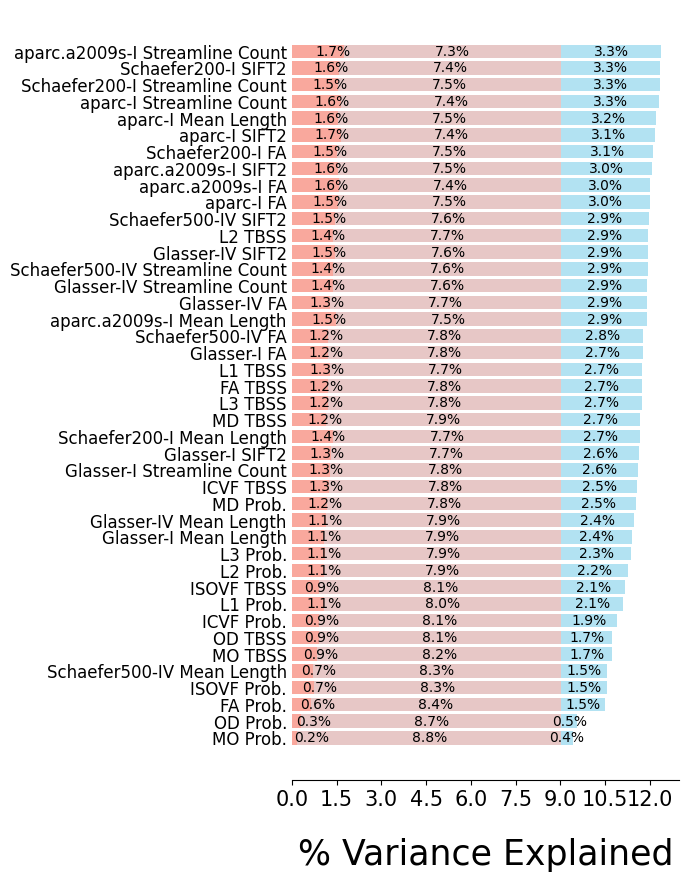

In [ ]:
# Load variables
with open('/commonality_analysis/dti/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/unique_dti.pkl', 'rb') as f:
    unique_dti = pickle.load(f)

with open('/commonality_analysis/dti/pls/common_mh_dti.pkl', 'rb') as f:
    common_mh_dti = pickle.load(f)
# Set variables
for key in unique_mh_dti: # unique for MH
    globals()[key] = round(unique_mh_dti[key] * 100, 3)
for key in unique_dti: # unique for rs modalities
    globals()[key] = round(unique_dti[key] * 100, 3)
for key in common_mh_dti: # common for MH and rs modalities
    globals()[key] = round(common_mh_dti[key] * 100, 3)

# Define x
modalities = list(unique_mh_dti.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in common_mh_dti.keys()])
y2 = np.array([globals()[f'{key}'] for key in unique_mh_dti.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_dti.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1] 

x_sorted = [base_rename_dict_dti.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

plt.figure(figsize=(5, 10))
plt.barh(x_sorted, y1_sorted, linewidth=1, color= '#f56f5c', alpha=0.6) 
plt.barh(x_sorted, y2_sorted, left=y1_sorted, color='#B24745FF', linewidth=1, alpha=0.3)
plt.barh(x_sorted, y3_sorted, left=y1_sorted+y2_sorted, color= '#00A1D599', linewidth=1, alpha=0.3)


for i, (value_c, value_u_mh, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    plt.text(value_c / 2.2, i, f'{value_c:.1f}%', ha='left', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh + value_u_mri / 2, i, f'{value_u_mri:.1f}%', ha='center', va='center', color='black', fontsize=10)


plt.xlabel("% Variance Explained", fontsize=25, labelpad=20)
#plt.legend(["Common Variance: Mental Health + dwMRI", "Unique variance: Mental Health", "Unique variance: dwMRI"], fontsize = 10, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.2))
plt.yticks(fontsize=12)
plt.xticks(fontsize=15)
plt.tick_params(axis='y', length=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.5))



plt.savefig("CA-dwMRI.png",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='png')


plt.show()

## RS

In [23]:
# Rename phenotypes
base_rename_dict_rs = {"aparc_s1_full_correlation":'aparc-I Func. Connectivity',
"aparc_2009_s1_full_correlation":'aparc.a2009s-I Func. Connectivity',
"glasser_s1_full_correlation":'Glasser-I Func. Connectivity',
"glasser_s4_full_correlation":'Glasser-IV Func. Connectivity',
"Schaefer7n200p_s1_full_correlation":'Schaefer200-I Func. Connectivity',
"Schaefer7n500p_s4_full_correlation":'Schaefer500-IV Func. Connectivity',
"amplitudes_21":'21 IC Amplitudes',
"amplitudes_55":'55 IC Amplitudes',
"tangent_matrices_21":'21 IC Func. Connectivity',
"tangent_matrices_55":'55 IC Func. Connectivity'}

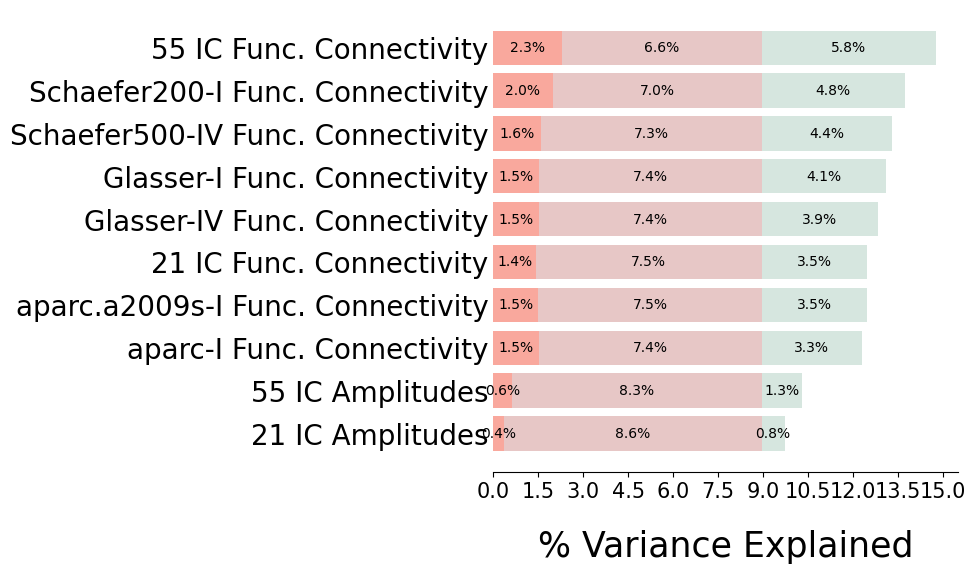

In [ ]:
# Barplot
# Load variables
with open('/commonality_analysis/rs/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/unique_rs.pkl', 'rb') as f:
    unique_rs = pickle.load(f)

with open('/commonality_analysis/rs/pls/common_mh_rs.pkl', 'rb') as f:
    common_mh_rs = pickle.load(f)
# Set variables
for key in unique_mh_rs: # unique for MH
    globals()[key] = round(unique_mh_rs[key] * 100, 3)
for key in unique_rs: # unique for rs modalities
    globals()[key] = round(unique_rs[key] * 100, 3)
for key in common_mh_rs: # common for MH and rs modalities
    globals()[key] = round(common_mh_rs[key] * 100, 3)


# Define x
modalities = list(unique_mh_rs.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in common_mh_rs.keys()])
y2 = np.array([globals()[f'{key}'] for key in unique_mh_rs.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_rs.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1]

x_sorted = [base_rename_dict_rs.get(item, item) for item in np.array(x)[sorted_indices]] #checks if item exists in base_rename_dict, if item exists, it returns the corresponding value from the dictionary, if doesnt, it returns item itself

y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

# Plot
plt.figure(figsize=(6, 6))
plt.barh(x_sorted, y1_sorted, linewidth=1, color= '#f56f5c', alpha=0.6) #fill=False, edgecolor='darkgreen',
plt.barh(x_sorted, y2_sorted, left=y1_sorted, color='#B24745FF', linewidth=1, alpha=0.3)#fill=False,edgecolor='navy',
plt.barh(x_sorted, y3_sorted, left=y1_sorted+y2_sorted, color= '#79AF9799', linewidth=1, alpha=0.3)#fill=False,edgecolor='crimson',


for i, (value_c, value_u_mh, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    plt.text(value_c / 2, i, f'{value_c:.1f}%', ha='center', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh + value_u_mri / 2, i, f'{value_u_mri:.1f}%', ha='center', va='center', color='black', fontsize=10)


plt.xlabel("% Variance Explained", fontsize=25, labelpad=20)
#plt.legend(["Common Variance: Mental Health + rsMRI", "Unique variance: Mental Health", "Unique variance: rsMRI"], fontsize = 10, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.32)) #, , bbox_to_anchor=(1.3, 0.98) loc='upper right'
#plt.title("Variance Attributed to Mental Health and MRI Modalities", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=15)
plt.tick_params(axis='y', length=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.5))

plt.savefig("CA-rsMRI.png",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='png')


plt.show()

## T1/T2

In [33]:
# Rename phenotypes
base_rename_dict_struct = {"struct_fast":'FSL FAST',
"struct_sub_first":'FSL FIRST',
"struct_aseg_mean_intensity":'ASEG Mean Thickness',
"struct_aseg_volume":'ASEG Volume',
"struct_ba_exvivo_area":'BA ex-vivo Area',
"struct_ba_exvivo_mean_thickness":'BA ex-vivo Mean Thickness',
"struct_ba_exvivo_volume":'BA ex-vivo Volume',
"struct_a2009s_area":'aparc.a2009s Area',
"struct_a2009s_mean_thickness":'aparc.a2009s Mean Thickness',
"struct_a2009s_volume":'aparc.a2009s Volume',
"struct_dkt_area":'DKT Area',
"struct_dkt_mean_thickness":'DKT Mean Thickness',
"struct_dkt_volume":'DKT Volume',
"struct_desikan_gw":'Desikan GM/WM Intensity',
"struct_desikan_pial":'Desikan Pial',
"struct_desikan_white_area":'Desikan WM Area',
"struct_desikan_white_mean_thickness":'Desikan WM Mean Thickness',
"struct_desikan_white_volume":'Desikan WM Volume',
"struct_subsegmentation":'Subcortical Volumetric Subseg.',
'T1_T2_whole_brain':'Whole-brain T1/T2'}

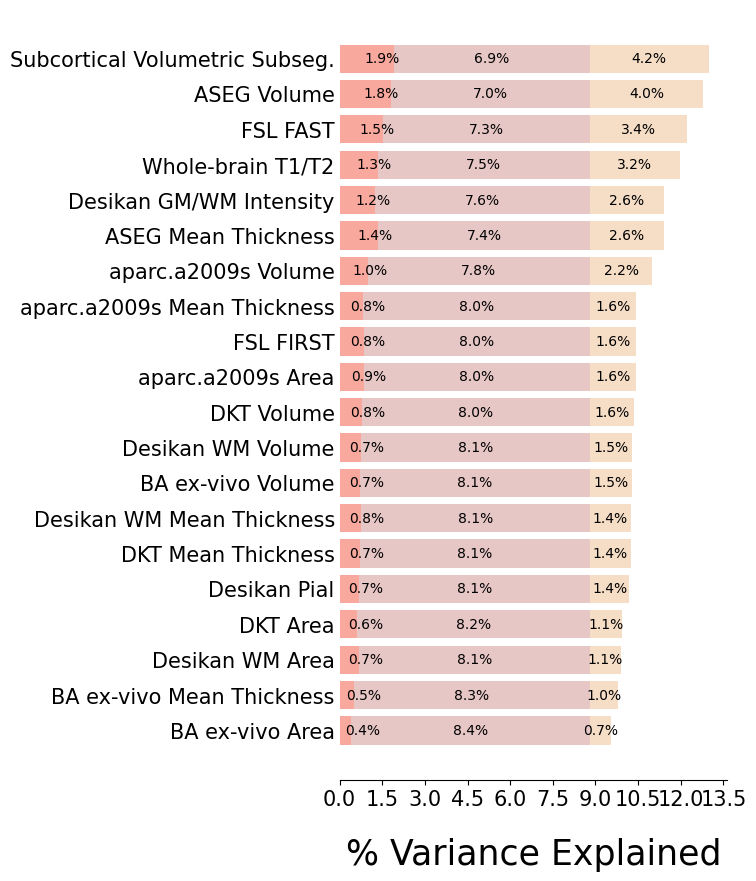

In [ ]:
# Load variables
with open('/commonality_analysis/struct/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/unique_t1_t2.pkl', 'rb') as f:
    unique_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/common_mh_t1_t2.pkl', 'rb') as f:
    common_mh_t1_t2 = pickle.load(f)
# Set variables
for key in unique_mh_t1_t2: # unique for MH
    globals()[key] = round(unique_mh_t1_t2[key] * 100, 3)
for key in unique_t1_t2: # unique for rs modalities
    globals()[key] = round(unique_t1_t2[key] * 100, 3)
for key in common_mh_t1_t2: # common for MH and rs modalities
    globals()[key] = round(common_mh_t1_t2[key] * 100, 3)

# Define x
modalities = list(unique_mh_t1_t2.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in common_mh_t1_t2.keys()])
y2 = np.array([globals()[f'{key}'] for key in unique_mh_t1_t2.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_t1_t2.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1] 

x_sorted = [base_rename_dict_struct.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

plt.figure(figsize=(5, 10))
plt.barh(x_sorted, y1_sorted, linewidth=1, color= '#f56f5c', alpha=0.6) 
plt.barh(x_sorted, y2_sorted, left=y1_sorted, color='#B24745FF', linewidth=1, alpha=0.3)
plt.barh(x_sorted, y3_sorted, left=y1_sorted+y2_sorted, color= '#DF8F4499', linewidth=1, alpha=0.3)


for i, (value_c, value_u_mh, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    plt.text(value_c / 2.2, i, f'{value_c:.1f}%', ha='left', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh + value_u_mri / 2, i, f'{value_u_mri:.1f}%', ha='center', va='center', color='black', fontsize=10)


plt.xlabel("% Variance Explained", fontsize=25, labelpad=20)
#plt.legend(["Common Variance: Mental Health + sMRI", "Unique variance: Mental Health", "Unique variance: sMRI"], fontsize = 10, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.2))
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(axis='y', length=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.5))

plt.savefig("CA-sMRI.png",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='png')
plt.show()

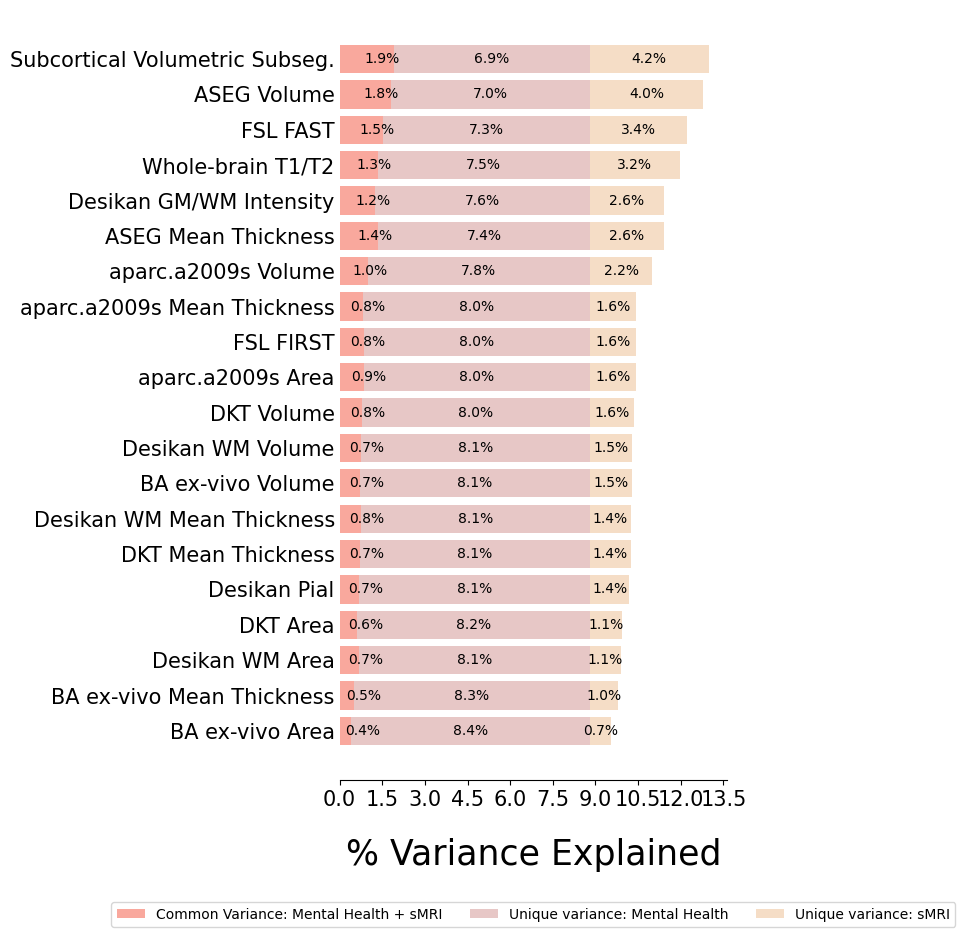

In [ ]:
# Load variables
with open('/commonality_analysis/struct/pls/unique_mh.pkl', 'rb') as f:
    unique_mh_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/unique_t1_t2.pkl', 'rb') as f:
    unique_t1_t2 = pickle.load(f)

with open('/commonality_analysis/struct/pls/common_mh_t1_t2.pkl', 'rb') as f:
    common_mh_t1_t2 = pickle.load(f)
# Set variables
for key in unique_mh_t1_t2: # unique for MH
    globals()[key] = round(unique_mh_t1_t2[key] * 100, 3)
for key in unique_t1_t2: # unique for rs modalities
    globals()[key] = round(unique_t1_t2[key] * 100, 3)
for key in common_mh_t1_t2: # common for MH and rs modalities
    globals()[key] = round(common_mh_t1_t2[key] * 100, 3)

# Define x
modalities = list(unique_mh_t1_t2.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in common_mh_t1_t2.keys()])
y2 = np.array([globals()[f'{key}'] for key in unique_mh_t1_t2.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_t1_t2.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1] 

x_sorted = [base_rename_dict_struct.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

plt.figure(figsize=(5, 10))
plt.barh(x_sorted, y1_sorted, linewidth=1, color= '#f56f5c', alpha=0.6) 
plt.barh(x_sorted, y2_sorted, left=y1_sorted, color='#B24745FF', linewidth=1, alpha=0.3)
plt.barh(x_sorted, y3_sorted, left=y1_sorted+y2_sorted, color= '#DF8F4499', linewidth=1, alpha=0.3)


for i, (value_c, value_u_mh, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    plt.text(value_c / 2.2, i, f'{value_c:.1f}%', ha='left', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=10)
    plt.text(value_c + value_u_mh + value_u_mri / 2, i, f'{value_u_mri:.1f}%', ha='center', va='center', color='black', fontsize=10)


plt.xlabel("% Variance Explained", fontsize=25, labelpad=20)
plt.legend(["Common Variance: Mental Health + sMRI", "Unique variance: Mental Health", "Unique variance: sMRI"], fontsize = 10, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.2))

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(axis='y', length=0)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.5))

plt.savefig("CA-sMRI.png",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='png')

plt.show()

##  Calculate % of variance explained by MRI

#### DTI

In [ ]:
# DTI
commonality_metrics_dti_df = pd.DataFrame.from_dict(commonality_metrics_dti, orient='index')
commonality_metrics_dti_df['Var Exp MRI'] = commonality_metrics_dti_df['Common'].round(2) / (commonality_metrics_dti_df['Common'].round(2) + commonality_metrics_dti_df['Unique: Mental Health'].round(2))
commonality_metrics_dti_df['Var Exp MRI'] = (commonality_metrics_dti_df['Var Exp MRI'] * 100).round(2)
commonality_metrics_dti_df['Total Var'] = commonality_metrics_dti_df.iloc[:, :-1].sum(axis=1)
commonality_metrics_dti_df = commonality_metrics_dti_df.sort_values(by='Total Var', ascending = False)
commonality_metrics_dti_df.to_csv('/commonality_analysis/var_explained_dti_full.csv')
commonality_metrics_dti_df

In [ ]:
# Rename according to plots
commonality_metrics_dti_df_renamed = commonality_metrics_dti_df.rename(index=base_rename_dict_dti)
commonality_metrics_dti_df_renamed.to_csv('/commonality_analysis/var_explained_dti_full_renamed.csv')
commonality_metrics_dti_df_renamed.round(2)

Unique: Mental Health  Unique: MRI  Common  \
aparc.a2009s-I Streamline Count                   7.29         3.33    1.74   
Schaefer200-I SIFT2                               7.43         3.30    1.60   
Schaefer200-I Streamline Count                    7.48         3.29    1.55   
aparc-I Streamline Count                          7.38         3.28    1.65   
aparc-I Mean Length                               7.46         3.17    1.57   
aparc-I SIFT2                                     7.36         3.14    1.67   
Schaefer200-I FA                                  7.50         3.08    1.53   
aparc.a2009s-I SIFT2                              7.46         3.02    1.57   
aparc.a2009s-I FA                                 7.43         2.97    1.60   
aparc-I FA                                        7.48         2.96    1.55   
Schaefer500-IV SIFT2                              7.57         2.93    1.46   
Glasser-IV SIFT2                                  7.57         2.90    1.46   
L2 TBSS                                           7.66         2.90    1.37   
Schaefer500-IV Streamline Count                   7.63         2.89    1.40   
Glasser-IV Streamline Count                       7.63         2.88    1.40   
aparc.a2009s-I Mean Length                        7.54         2.87    1.49   
Glasser-IV FA                                     7.74         2.87    1.29   
Schaefer500-IV FA                                 7.81         2.75    1.22   
Glasser-I FA                                      7.81         2.74    1.22   
L1 TBSS                                           7.73         2.71    1.30   
FA TBSS                                           7.82         2.70    1.21   
L3 TBSS                                           7.80         2.69    1.23   
MD TBSS                                           7.87         2.65    1.16   
Schaefer200-I Mean Length                         7.66         2.65    1.37   
Glasser-I SIFT2                                   7.72         2.60    1.31   
Glasser-I Streamline Count                        7.76         2.58    1.27   
ICVF TBSS                                         7.77         2.53    1.26   
MD Prob.                                          7.85         2.51    1.18   
Glasser-IV Mean Length                            7.89         2.42    1.14   
Glasser-I Mean Length                             7.93         2.36    1.10   
L3 Prob.                                          7.92         2.34    1.11   
L2 Prob.                                          7.94         2.23    1.09   
ISOVF TBSS                                        8.11         2.13    0.92   
L1 Prob.                                          7.96         2.07    1.07   
ICVF Prob.                                        8.12         1.87    0.91   
OD TBSS                                           8.12         1.70    0.91   
MO TBSS                                           8.17         1.69    0.86   
Schaefer500-IV Mean Length                        8.33         1.52    0.70   
ISOVF Prob.                                       8.28         1.52    0.75   
FA Prob.                                          8.39         1.45    0.64   
OD Prob.                                          8.70         0.53    0.33   
MO Prob.                                          8.84         0.38    0.19   

                                 Var Exp MRI  Total Var  
aparc.a2009s-I Streamline Count        19.27      12.36  
Schaefer200-I SIFT2                    17.72      12.33  
Schaefer200-I Streamline Count         17.17      12.32  
aparc-I Streamline Count               18.27      12.31  
aparc-I Mean Length                    17.39      12.20  
aparc-I SIFT2                          18.49      12.17  
Schaefer200-I FA                       16.94      12.11  
aparc.a2009s-I SIFT2                   17.39      12.05  
aparc.a2009s-I FA                      17.72      12.00  
aparc-I FA                             17.17      11.99

#### RS

In [ ]:
# RS
commonality_metrics_rs_df = pd.DataFrame.from_dict(commonality_metrics_rs, orient='index')
commonality_metrics_rs_df['Var Exp MRI'] = commonality_metrics_rs_df['Common'].round(2) / (commonality_metrics_rs_df['Common'].round(2) + commonality_metrics_rs_df['Unique: Mental Health'].round(2))
commonality_metrics_rs_df['Var Exp MRI'] = (commonality_metrics_rs_df['Var Exp MRI'] * 100).round(2)
commonality_metrics_rs_df['Total Var'] = commonality_metrics_rs_df.iloc[:, :-1].sum(axis=1)
commonality_metrics_rs_df = commonality_metrics_rs_df.sort_values(by='Total Var', ascending = False)
commonality_metrics_rs_df.to_csv('/commonality_analysis/var_explained_rs_full.csv')
commonality_metrics_rs_df

Unique: Mental Health  Unique: MRI  \
tangent_matrices_55                                  6.64        5.825   
Schaefer7n200p_s1_full_correlation                   6.97        4.785   
Schaefer7n500p_s4_full_correlation                   7.35        4.355   
glasser_s1_full_correlation                          7.41        4.135   
glasser_s4_full_correlation                          7.43        3.885   
tangent_matrices_21                                  7.53        3.515   
aparc_2009_s1_full_correlation                       7.45        3.505   
aparc_s1_full_correlation                            7.43        3.335   
amplitudes_55                                        8.32        1.345   
amplitudes_21                                        8.58        0.765   

                                    Common  Var Exp MRI  Total Var  
tangent_matrices_55                  2.305        25.81      14.77  
Schaefer7n200p_s1_full_correlation   1.975        22.12      13.73  
Schaefer7n500p_s4_full_correlation   1.595        17.88      13.30  
glasser_s1_full_correlation          1.535        17.21      13.08  
glasser_s4_full_correlation          1.515        16.98      12.83  
tangent_matrices_21                  1.415        15.87      12.46  
aparc_2009_s1_full_correlation       1.495        16.76      12.45  
aparc_s1_full_correlation            1.515        16.98      12.28  
amplitudes_55                        0.625         6.94      10.29  
amplitudes_21                        0.365         4.03       9.71

In [ ]:
# Rename according to plots
commonality_metrics_rs_df_renamed = commonality_metrics_rs_df.rename(index=base_rename_dict_rs)
commonality_metrics_rs_df_renamed.to_csv('/commonality_analysis/var_explained_rs_full_renamed.csv')
commonality_metrics_rs_df_renamed.round(2)

Unique: Mental Health  Unique: MRI  Common  \
55 IC Func. Connectivity                            6.64         5.82    2.31   
Schaefer200-I Func. Connectivity                    6.97         4.78    1.98   
Schaefer500-IV Func. Connectivity                   7.35         4.36    1.60   
Glasser-I Func. Connectivity                        7.41         4.14    1.54   
Glasser-IV Func. Connectivity                       7.43         3.88    1.52   
21 IC Func. Connectivity                            7.53         3.52    1.42   
aparc.a2009s-I Func. Connectivity                   7.45         3.50    1.50   
aparc-I Func. Connectivity                          7.43         3.34    1.52   
55 IC Amplitudes                                    8.32         1.34    0.62   
21 IC Amplitudes                                    8.58         0.76    0.36   

                                   Var Exp MRI  Total Var  
55 IC Func. Connectivity                 25.81      14.77  
Schaefer200-I Func. Connectivity         22.12      13.73  
Schaefer500-IV Func. Connectivity        17.88      13.30  
Glasser-I Func. Connectivity             17.21      13.08  
Glasser-IV Func. Connectivity            16.98      12.83  
21 IC Func. Connectivity                 15.87      12.46  
aparc.a2009s-I Func. Connectivity        16.76      12.45  
aparc-I Func. Connectivity               16.98      12.28  
55 IC Amplitudes                          6.94      10.29  
21 IC Amplitudes                          4.03       9.71

#### T1/T2

In [ ]:
# T1/T2
commonality_metrics_struct_df = pd.DataFrame.from_dict(commonality_metrics_struct, orient='index')
commonality_metrics_struct_df['Var Exp MRI'] = commonality_metrics_struct_df['Common'].round(2) / (commonality_metrics_struct_df['Common'].round(2) + commonality_metrics_struct_df['Unique: Mental Health'].round(2))
commonality_metrics_struct_df['Var Exp MRI'] = (commonality_metrics_struct_df['Var Exp MRI'] * 100).round(2)
commonality_metrics_struct_df['Total Var'] = commonality_metrics_struct_df.iloc[:, :-1].sum(axis=1)
commonality_metrics_struct_df = commonality_metrics_struct_df.sort_values(by='Total Var', ascending = False)
commonality_metrics_struct_df.to_csv('/var_explained_struct_full.csv')
commonality_metrics_struct_df

Unique: Mental Health  Unique: MRI  \
struct_subsegmentation                                6.89        4.175   
struct_aseg_volume                                    6.98        3.975   
struct_fast                                           7.29        3.405   
T1_T2_whole_brain                                     7.47        3.155   
struct_desikan_gw                                     7.56        2.605   
struct_aseg_mean_intensity                            7.44        2.595   
struct_a2009s_volume                                  7.81        2.195   
struct_a2009s_mean_thickness                          7.98        1.615   
struct_sub_first                                      7.96        1.615   
struct_a2009s_area                                    7.95        1.605   
struct_dkt_volume                                     8.03        1.555   
struct_desikan_white_volume                           8.06        1.495   
struct_ba_exvivo_volume                               8.10        1.465   
struct_desikan_white_mean_thickness                   8.05        1.435   
struct_dkt_mean_thickness                             8.08        1.435   
struct_desikan_pial                                   8.14        1.375   
struct_dkt_area                                       8.18        1.115   
struct_desikan_white_area                             8.13        1.075   
struct_ba_exvivo_mean_thickness                       8.30        0.985   
struct_ba_exvivo_area                                 8.39        0.725   

                                     Common  Var Exp MRI  Total Var  
struct_subsegmentation                1.915        21.79      12.98  
struct_aseg_volume                    1.825        20.68      12.78  
struct_fast                           1.515        17.25      12.21  
T1_T2_whole_brain                     1.335        15.21      11.96  
struct_desikan_gw                     1.245        14.19      11.41  
struct_aseg_mean_intensity            1.365        15.45      11.40  
struct_a2009s_volume                  0.995        11.35      11.00  
struct_a2009s_mean_thickness          0.825         9.32      10.42  
struct_sub_first                      0.845         9.55      10.42  
struct_a2009s_area                    0.855         9.76      10.41  
struct_dkt_volume                     0.775         8.85      10.36  
struct_desikan_white_volume           0.745         8.41      10.30  
struct_ba_exvivo_volume               0.705         7.95      10.27  
struct_desikan_white_mean_thickness   0.755         8.63      10.24  
struct_dkt_mean_thickness             0.725         8.18      10.24  
struct_desikan_pial                   0.665         7.50      10.18  
struct_dkt_area                       0.625         7.05       9.92  
struct_desikan_white_area             0.675         7.72       9.88  
struct_ba_exvivo_mean_thickness       0.505         5.68       9.79  
struct_ba_exvivo_area                 0.415         4.77       9.53

In [ ]:
# Rename according to plots
commonality_metrics_struct_df_renamed = commonality_metrics_struct_df.rename(index=base_rename_dict_struct)
commonality_metrics_struct_df_renamed.to_csv('/commonality_analysis/var_explained_struct_full_renamed.csv')
commonality_metrics_struct_df_renamed.round(2)

Unique: Mental Health  Unique: MRI  Common  \
Subcortical Volumetric Subseg.                   6.89         4.18    1.92   
ASEG Volume                                      6.98         3.98    1.82   
FSL FAST                                         7.29         3.40    1.52   
Whole-brain T1/T2                                7.47         3.16    1.34   
Desikan GM/WM Intensity                          7.56         2.60    1.25   
ASEG Mean Thickness                              7.44         2.60    1.36   
aparc.a2009s Volume                              7.81         2.19    1.00   
aparc.a2009s Mean Thickness                      7.98         1.62    0.82   
FSL FIRST                                        7.96         1.62    0.84   
aparc.a2009s Area                                7.95         1.60    0.86   
DKT Volume                                       8.03         1.56    0.78   
Desikan WM Volume                                8.06         1.50    0.74   
BA ex-vivo Volume                                8.10         1.46    0.70   
Desikan WM Mean Thickness                        8.05         1.44    0.76   
DKT Mean Thickness                               8.08         1.44    0.72   
Desikan Pial                                     8.14         1.38    0.66   
DKT Area                                         8.18         1.12    0.62   
Desikan WM Area                                  8.13         1.08    0.68   
BA ex-vivo Mean Thickness                        8.30         0.98    0.50   
BA ex-vivo Area                                  8.39         0.72    0.42   

                                Var Exp MRI  Total Var  
Subcortical Volumetric Subseg.        21.79      12.98  
ASEG Volume                           20.68      12.78  
FSL FAST                              17.25      12.21  
Whole-brain T1/T2                     15.21      11.96  
Desikan GM/WM Intensity               14.19      11.41  
ASEG Mean Thickness                   15.45      11.40  
aparc.a2009s Volume                   11.35      11.00  
aparc.a2009s Mean Thickness            9.32      10.42  
FSL FIRST                              9.55      10.42  
aparc.a2009s Area                      9.76      10.41  
DKT Volume                             8.85      10.36  
Desikan WM Volume                      8.41      10.30  
BA ex-vivo Volume                      7.95      10.27  
Desikan WM Mean Thickness              8.63      10.24  
DKT Mean Thickness                     8.18      10.24  
Desikan Pial                           7.50      10.18  
DKT Area                               7.05       9.92  
Desikan WM Area                        7.72       9.88  
BA ex-vivo Mean Thickness              5.68       9.79  
BA ex-vivo Area                        4.77       9.53

# Combine all three CA PLSR stacked bar plots in one figure

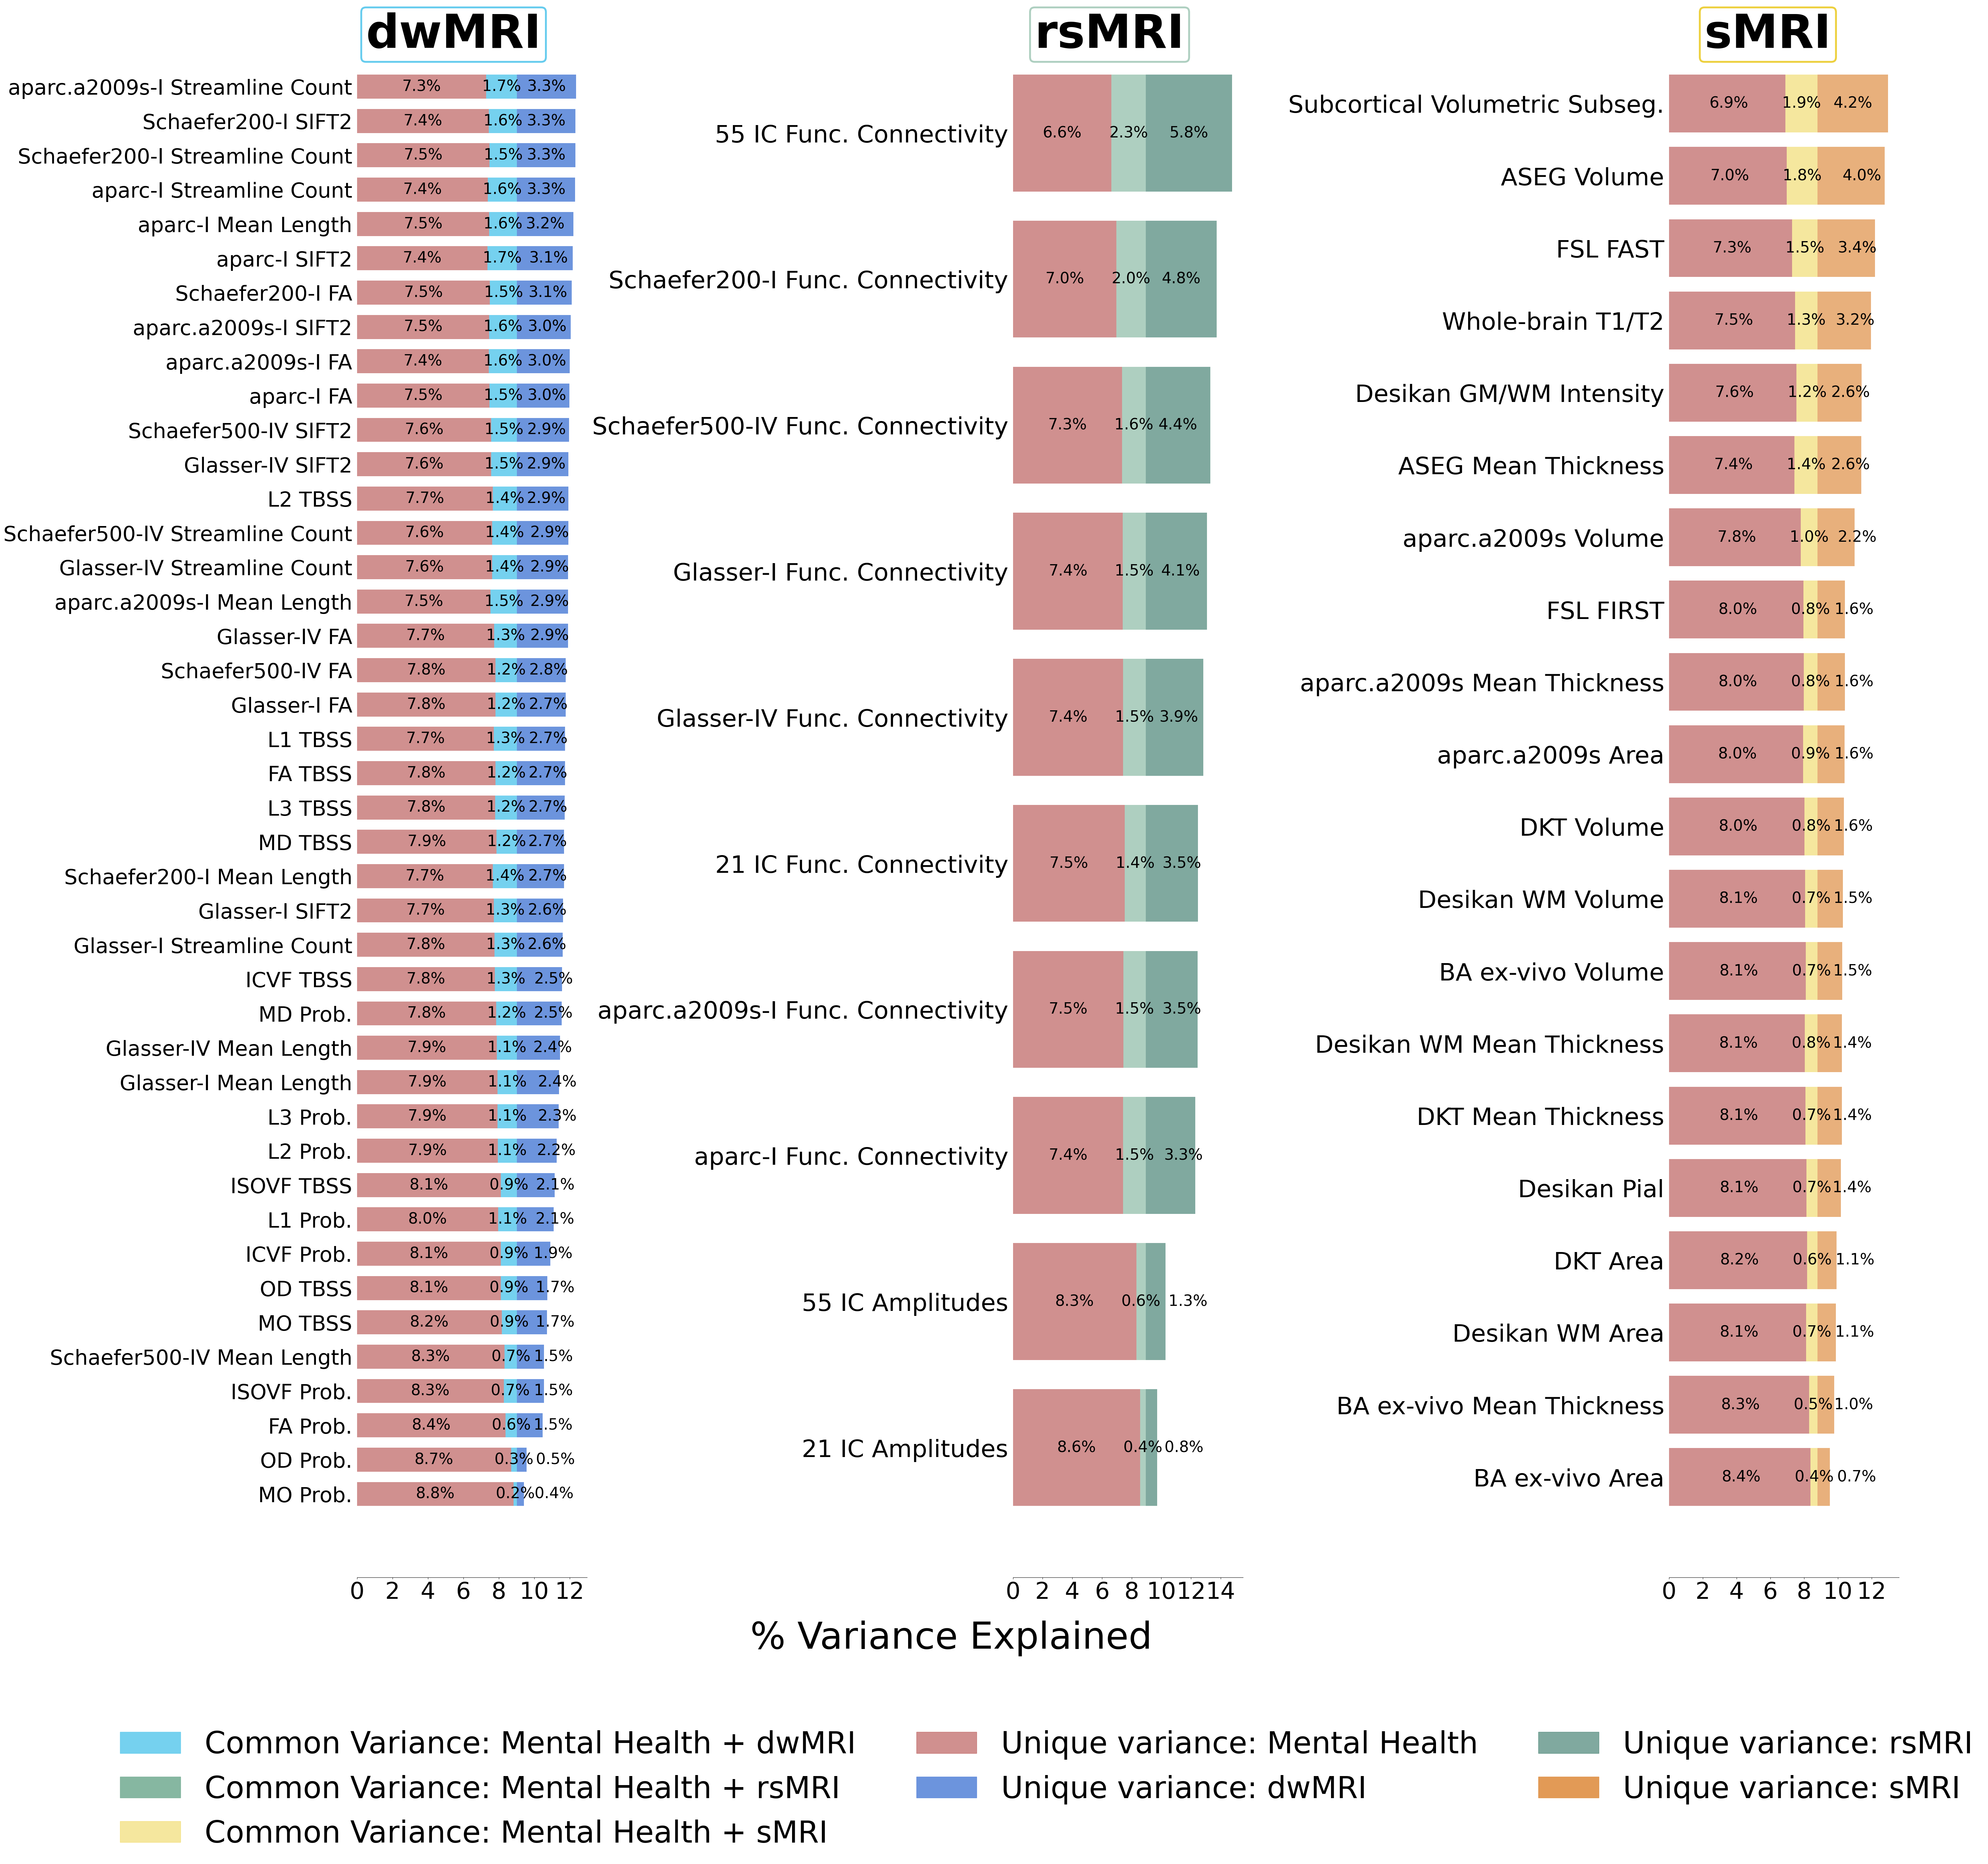

In [ ]:
# Birght
fig, axs = plt.subplots(1, 3, figsize=(57, 40))
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

######################## DTI
modalities = list(unique_mh_dti.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in unique_mh_dti.keys()])
y2 = np.array([globals()[f'{key}'] for key in common_mh_dti.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_dti.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1] 

x_sorted = [base_rename_dict_dti.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

bar_height = 0.7
axs[0].barh(x_sorted, y1_sorted, height=bar_height, linewidth=2, color= '#B24745FF', alpha=0.6) 
axs[0].barh(x_sorted, y2_sorted, height=bar_height, left=y1_sorted, color='#66CCEEFF', linewidth=1, alpha=0.9) #cbdae8
axs[0].barh(x_sorted, y3_sorted, height=bar_height, left=y1_sorted+y2_sorted, color= '#5C88DAFF', linewidth=1, alpha=0.9)

for i, (value_u_mh, value_c, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    axs[0].text(value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=33)
    axs[0].text(value_u_mh + value_c / 2, i, f'{value_c:.1f}%', ha='center', va='center', color='black', fontsize=33)
    if i == 0 or i == 1:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 3.0, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif 2 <= i <= 6: #i in range(2, 9)
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 2.4, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif 7 <= i <= 12:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 2.2, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif 13 <= i <= 15:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 1.9, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif 16 <= i <= 28:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 1.5, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif 29 <= i <= 36:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2 + 1.3, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    else:
        axs[0].text(value_u_mh + value_c + value_u_mri / 2, i, f'{value_u_mri.round(1)}%', ha='center', va='center', color='black', fontsize=33)

axs[0].set_yticklabels([])
axs[0].set_yticklabels(x_sorted, fontsize=45)
axs[0].set_xticklabels(axs[0].get_xticks(), fontsize=50)
axs[0].tick_params(axis='y', length=0)

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['left'].set_visible(False)

######################## RS

modalities = list(unique_mh_rs.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in unique_mh_rs.keys()])
y2 = np.array([globals()[f'{key}'] for key in common_mh_rs.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_rs.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1]

x_sorted = [base_rename_dict_rs.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

# Plot
bar_height = 0.8
axs[1].barh(x_sorted, y1_sorted, height=bar_height, linewidth=1, color= '#B24745FF', alpha=0.6)
axs[1].barh(x_sorted, y2_sorted, height=bar_height, left=y1_sorted, color='#79AF9799', linewidth=1, alpha=0.6)  #edded7 418D87FF
axs[1].barh(x_sorted, y3_sorted, height=bar_height, left=y1_sorted+y2_sorted, color= '#2C715FFF', linewidth=1, alpha=0.6)

for i, (value_u_mh, value_c, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    axs[1].text(value_u_mh / 2, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=33)
    axs[1].text(value_u_mh + value_c / 2, i, f'{value_c:.1f}%', ha='center', va='center', color='black', fontsize=33)

    if i == 0 or i == 1:
        axs[1].text(value_u_mh + value_c + value_u_mri / 2 + 3.5, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i == 2:
        axs[1].text(value_u_mh + value_c + value_u_mri / 2 + 2.2, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i in range (3,5): 
        axs[1].text(value_u_mh + value_c + value_u_mri / 2 + 2, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i in range (4,7):
        axs[1].text(value_u_mh + value_c + value_u_mri / 2 + 1.6, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    else:
        axs[1].text(value_u_mh + value_c + value_u_mri / 2, i, f'{value_u_mri.round(1)}%', ha='center', va='center', color='black', fontsize=33)

axs[1].set_yticklabels([])
axs[1].set_yticklabels(x_sorted, fontsize=52)
axs[1].set_xticklabels(axs[1].get_xticks(), fontsize=50)
axs[1].tick_params(axis='y', length=0)

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

######################## T1/T2

modalities = list(unique_mh_t1_t2.keys())
x = [modality.replace('u_mh_from_', '') for modality in modalities]
y1 = np.array([globals()[f'{key}'] for key in unique_mh_t1_t2.keys()])
y2 = np.array([globals()[f'{key}'] for key in common_mh_t1_t2.keys()])
y3 = np.array([globals()[f'{key}'] for key in unique_t1_t2.keys()])

# Sort plots based on total variance
total_variance = y1 + y2 + y3
sorted_indices = np.argsort(total_variance)[::1] 

x_sorted = [base_rename_dict_struct.get(item, item) for item in np.array(x)[sorted_indices]] 
y1_sorted = y1[sorted_indices]
y2_sorted = y2[sorted_indices]
y3_sorted = y3[sorted_indices]

bar_height = 0.8
axs[2].barh(x_sorted, y1_sorted, height=bar_height, linewidth=1, color= '#B24745FF', alpha=0.6) 
axs[2].barh(x_sorted, y2_sorted, height=bar_height, left=y1_sorted, color='#EDD03EFF', linewidth=1, alpha=0.5) #E37D41FF
axs[2].barh(x_sorted, y3_sorted, height=bar_height, left=y1_sorted+y2_sorted, color= '#DF8F44FF', linewidth=1, alpha=0.7)

# Adjust % positions
for i, (value_u_mh, value_c, value_u_mri) in enumerate(zip(y1_sorted, y2_sorted, y3_sorted)):
    axs[2].text(value_u_mh / 2 + 0.1, i, f'{value_u_mh:.1f}%', ha='center', va='center', color='black', fontsize=33)
    axs[2].text(value_u_mh + value_c / 2, i, f'{value_c:.1f}%', ha='center', va='center', color='black', fontsize=33)

    if i == 0:
        axs[2].text(value_u_mh + value_c + value_u_mri / 2 + 3.1, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i in range(1,4):
        axs[2].text(value_u_mh + value_c + value_u_mri / 2 + 2.8, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i in range(4,13):
        axs[2].text(value_u_mh + value_c + value_u_mri / 2 + 2.5, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i == 13:
        axs[2].text(value_u_mh + value_c + value_u_mri / 2 + 2.4, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    elif i in range(14,19):
        axs[2].text(value_u_mh + value_c + value_u_mri / 2 + 1.8, i, f'{value_u_mri.round(1)}%', ha='right', va='center', color='black', fontsize=33)
    else:
        axs[2].text(value_u_mh + value_c + value_u_mri / 2, i, f'{value_u_mri.round(1)}%', ha='center', va='center', color='black', fontsize=33)

axs[2].set_yticklabels([])
axs[2].set_yticklabels(x_sorted, fontsize=52)
axs[2].set_xticklabels(axs[2].get_xticks(), fontsize=50)
axs[2].tick_params(axis='y', length=0)


axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)
axs[2].spines['left'].set_visible(False)

####

axs[0].tick_params(axis='y', pad=10)
axs[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{int(val)}')) 
axs[1].tick_params(axis='y', pad=10)
axs[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{int(val)}')) 
axs[2].tick_params(axis='y', pad=10)
axs[2].xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{int(val)}'))

####

axs[0].set_title('dwMRI', fontsize=100, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#66CCEEFF', boxstyle='round', pad=0.1, linewidth=4), y=0.97, x=0.42)
axs[1].set_title('rsMRI', fontsize=100, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#79AF9799', boxstyle='round', pad=0.1, linewidth=4), y=0.97, x=0.42)
axs[2].set_title('sMRI', fontsize=100, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#EDD03EFF', boxstyle='round', pad=0.1, linewidth=4), y=0.97, x=0.43)


# Add common title and x-axis label
fig.text(0.5, -0.03, '% Variance Explained', ha='center', fontsize=80)

# Add common legend
colors = ['#66CCEEFF', '#79AF9799', '#EDD03EFF',
          '#B24745FF', '#5C88DAFF', '#2C715FFF', '#DF8F44FF']
alphas = [0.9, 0.9, 0.5, 0.6, 0.9, 0.6, 0.9]
labels = ['Common Variance: Mental Health + dwMRI', 'Common Variance: Mental Health + rsMRI', 'Common Variance: Mental Health + sMRI',
          'Unique variance: Mental Health', 'Unique variance: dwMRI', 'Unique variance: rsMRI', 'Unique variance: sMRI']
handles = [plt.Rectangle((0,0),1,1, color=color, alpha=alpha) for color, alpha in zip(colors, alphas)]

fig.legend(handles, labels, loc='lower center', ncol=3, fontsize=65, frameon=False, bbox_to_anchor=(0.55, -0.2))
fig.tight_layout() #rect=[0, 0, 1, 0.96]

plt.subplots_adjust(top=1.2)

plt.savefig("/figures/finset/Fig4b.pdf",
            bbox_inches ="tight", 
            #pad_inches = 0.5, 
            transparent = False, 
            facecolor ="w", 
            edgecolor ='w', 
            orientation ='landscape',
            format='pdf')

plt.show()

#######################################################

# Incorporate demographics: sex, age*sex, etc.

- U (i) = R2_ijk – R2_jk
- U (j) = R2_ijk – R2_ik
- U (k) = R2_ijk – R2_ij

- C (ij) = R2_ik + R2_jk – R2_k – R2_ijk
- C (ik) = R2_ij + R2_jk – R2_j – R2_ijk
- C (jk) = R2_ij + R2_ik – R2_i – R2_ijk
- C (ijk) = R2_i + R2_j + R2_k – R2_ij – R2_ik – R2_jk + R2_ijk

- U (mh) = R2_mh_rs_age – R2_rs_age
- U (rs) = R2_mh_rs_age – R2_mh_age
- U (age) = R2_mh_rs_age – R2_mh_rs

- C (mh_rs) = R2_mh_age + R2_rs_age – R2_age – R2_mh_rs_age
- C (mh_age) = R2_mh_rs + R2_rs_age – R2_rs – R2_mh_rs_age
- C (rs_age) = R2_mh_rs + R2_mh_age – R2_mh – R2_mh_rs_age
- C (mh_rs_age) = R2_mh + R2_rs + R2_age – R2_mh_rs – R2_mh_age – R2_rs_age + R2_mh_rs_age

In [ ]:
basic_confounds_min = pd.read_csv('/ML_DATASETS/basic_confounds_min.csv')[['Age when attended assessment centre', 'eid', 'Sex', 'Age2', 'Age*Sex', 'Age2*Sex']]
demo = pd.DataFrame(basic_confounds_min)
demo = demo.rename(columns={'Age when attended assessment centre': 'Age'})
demo.to_csv('/PLS/brain/stacking/all/demo.csv', index=False)
demo = pd.read_csv('/PLS/brain/stacking/all/demo.csv')
demo_var = ['Age', 'Sex', 'Age2', 'Age*Sex', 'Age2*Sex']

## RS

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
folds = ["0", "1", "2", "3", "4"]
all_g_mh_rs_demo_concat = []
demo_var = ['Age', 'Sex', 'Age2', 'Age*Sex', 'Age2*Sex']

for fold in folds:
    g_pred_rs_idp_rf = pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_rs_idp_rf, on='eid').merge(demo, on='eid').drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_rs_idp_ts_best_stack_test': 'g_pred_rs_idp'})
    all_g_mh_rs_demo_concat.append(all_g)
    all_g_mh_rs_demo = pd.concat(all_g_mh_rs_demo_concat, axis=0, ignore_index=True)
    all_g_mh_rs_demo.to_csv('/commonality_analysis/g_real_pred_mh_rs_demo.csv', index=False)
    
model = LinearRegression()
r2_mh = model.fit(all_g_mh_rs_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_rs_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_rs = model.fit(all_g_mh_rs_demo['g_pred_rs_idp'].values.reshape(-1, 1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_rs_demo['g_pred_rs_idp'].values.reshape(-1, 1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_demo = model.fit(all_g_mh_rs_demo[demo_var].values, all_g_mh_rs_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_rs_demo[demo_var].values, all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_mh_rs_demo = model.fit(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real']).score(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))

r2_mh_demo = model.fit(pd.concat([all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real']).score(pd.concat([all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_rs_demo = model.fit(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real']).score(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_mh_rs = model.fit(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh']], axis=1), all_g_mh_rs_demo['g_real']).score(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh']], axis=1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))

In [ ]:
all_g_mh_rs_demo = pd.read_csv('/commonality_analysis/g_real_pred_mh_rs_demo.csv')

r2_mh = commonality_analysis(all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo['g_real'])
r2_rs = commonality_analysis(all_g_mh_rs_demo['g_pred_rs_idp'].values.reshape(-1, 1), all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_demo = commonality_analysis(all_g_mh_rs_demo[demo_var], all_g_mh_rs_demo['g_real'].values.reshape(-1, 1))
r2_mh_rs_demo = commonality_analysis(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'])

r2_mh_demo = commonality_analysis(pd.concat([all_g_mh_rs_demo['g_pred_mh'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'])
r2_rs_demo = commonality_analysis(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo[demo_var]], axis=1), all_g_mh_rs_demo['g_real'])
r2_mh_rs = commonality_analysis(pd.concat([all_g_mh_rs_demo['g_pred_rs_idp'], all_g_mh_rs_demo['g_pred_mh']], axis=1), all_g_mh_rs_demo['g_real'])

In [267]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# i = mh, j = rs, k = demo

u_mh = r2_mh_rs_demo - r2_rs_demo
u_rs = r2_mh_rs_demo - r2_mh_demo
u_demo = r2_mh_rs_demo - r2_mh_rs

c_mh_rs = r2_mh_demo + r2_rs_demo - r2_demo - r2_mh_rs_demo
c_mh_demo = r2_mh_rs + r2_rs_demo - r2_rs - r2_mh_rs_demo
c_rs_demo = r2_mh_rs + r2_mh_demo - r2_mh - r2_mh_rs_demo
c_mh_rs_demo = r2_mh + r2_rs + r2_demo - r2_mh_rs - r2_mh_demo - r2_rs_demo + r2_mh_rs_demo


print("R squared for MH:", r2_mh.round(3)) # f"{r2_mh_m:.5f}")
print("R squared for RS", r2_rs.round(3))
print("R squared for demo", r2_demo.round(3))
print("R squared for MH, RS, and demo", r2_mh_rs_demo.round(3))

print('_______________')
print("Unique variance for MH:", u_mh.round(3)) #"{:.5f}".format(u_mh)) # "{:.5f}".format(u_mh)
print("Unique variance for RS:", u_rs.round(3))
print("Unique variance for demo:", u_demo.round(3))

print('_______________')
print("Common variance for MH and RS:", c_mh_rs.round(3))
print("Common variance for MH and demo:", c_mh_demo.round(3))
print("Common variance for RS and demo:", c_rs_demo.round(3))
print("Common variance for MH, RS, and demo:", c_mh_rs_demo.round(3))

R squared for MH: 0.09
R squared for RS 0.096
R squared for demo 0.126
R squared for MH, RS, and demo 0.227
_______________
Unique variance for MH: 0.037
Unique variance for RS: 0.05
Unique variance for demo: 0.068
_______________
Common variance for MH and RS: 0.013
Common variance for MH and demo: 0.026
Common variance for RS and demo: 0.019
Common variance for MH, RS, and demo: 0.013


In [ ]:
# Make up a data frame with commonality metrics
mh_rs_demo_commonality = pd.DataFrame([{'u_mh-rs_plus_demo': u_mh, 'u_rs-rs_plus_demo': u_rs, 'u_demo-rs_plus_demo': u_demo,
                                       'c_mh_and_rs-rs_plus_demo': c_mh_rs, 'c_mh_and_demo-rs_plus_demo':c_mh_demo, 'c_rs_and_demo-rs_plus_demo': c_rs_demo, 'c_mh_and_rs_and_demo-rs_plus_demo': c_mh_rs_demo}]).round(4)
mh_rs_demo_commonality.to_csv('/commonality_analysis/mh_rs_demo_commonality.csv', index=False)

## DTI

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
folds = ["0", "1", "2", "3", "4"]
all_g_mh_dti_demo_concat = []

for fold in folds:
    g_pred_dti_rf = pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_dti_rf, on='eid').merge(demo, on='eid').drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_dti_all_stack_test': 'g_pred_dti'})
    all_g_mh_dti_demo_concat.append(all_g)
    all_g_mh_dti_demo = pd.concat(all_g_mh_dti_demo_concat, axis=0, ignore_index=True)
    all_g_mh_dti_demo.to_csv('/commonality_analysis/g_real_pred_mh_dti-all_demo.csv', index=False)

model = LinearRegression()
r2_mh = model.fit(all_g_mh_dti_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_dti_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_dti = model.fit(all_g_mh_dti_demo['g_pred_dti'].values.reshape(-1, 1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_dti_demo['g_pred_dti'].values.reshape(-1, 1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_demo = model.fit(all_g_mh_dti_demo[demo_var].values, all_g_mh_dti_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_dti_demo[demo_var].values, all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_mh_dti_demo = model.fit(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real']).score(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))

r2_mh_demo = model.fit(pd.concat([all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real']).score(pd.concat([all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_dti_demo = model.fit(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real']).score(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_mh_dti = model.fit(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh']], axis=1), all_g_mh_dti_demo['g_real']).score(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh']], axis=1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))

In [ ]:
all_g_mh_dti_demo = pd.read_csv('/commonality_analysis/g_real_pred_mh_dti-all_demo.csv')
r2_mh = commonality_analysis(all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo['g_real'])
r2_dti = commonality_analysis(all_g_mh_dti_demo['g_pred_dti'].values.reshape(-1, 1), all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_demo = commonality_analysis(all_g_mh_dti_demo[demo_var], all_g_mh_dti_demo['g_real'].values.reshape(-1, 1))
r2_mh_dti_demo = commonality_analysis(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'])

r2_mh_demo = commonality_analysis(pd.concat([all_g_mh_dti_demo['g_pred_mh'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'])
r2_dti_demo = commonality_analysis(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo[demo_var]], axis=1), all_g_mh_dti_demo['g_real'])
r2_mh_dti = commonality_analysis(pd.concat([all_g_mh_dti_demo['g_pred_dti'], all_g_mh_dti_demo['g_pred_mh']], axis=1), all_g_mh_dti_demo['g_real'])

In [263]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# i = mh, j = rs, k = demo

u_mh = r2_mh_dti_demo - r2_dti_demo
u_dti = r2_mh_dti_demo - r2_mh_demo
u_demo = r2_mh_dti_demo - r2_mh_dti

c_mh_dti = r2_mh_demo + r2_dti_demo - r2_demo - r2_mh_dti_demo
c_mh_demo = r2_mh_dti + r2_dti_demo - r2_dti - r2_mh_dti_demo
c_dti_demo = r2_mh_dti + r2_mh_demo - r2_mh - r2_mh_dti_demo
c_mh_dti_demo = r2_mh + r2_dti + r2_demo - r2_mh_dti - r2_mh_demo - r2_dti_demo + r2_mh_dti_demo


print("R squared for MH:", r2_mh.round(3))
print("R squared for DTI All", r2_dti.round(3))
print("R squared for demo", r2_demo.round(3))
print("R squared for MH, DTI All, and demo", r2_mh_dti_demo.round(3))

print('_______________')
print("Unique variance for MH:", u_mh.round(3)) 
print("Unique variance for DTI All:", u_dti.round(3)) #f"{u_dti:.5f}".round(3))
print("Unique variance for demo:", u_demo.round(3))

print('_______________')
print("Common variance for MH and DTI All:", c_mh_dti.round(3))
print("Common variance for MH and demo:", c_mh_demo.round(3))
print("Common variance for dti and demo:", c_dti_demo.round(3))
print("Common variance for MH, DTI All, and demo:", c_mh_dti_demo.round(3))

R squared for MH: 0.09
R squared for DTI All 0.071
R squared for demo 0.127
R squared for MH, DTI All, and demo 0.186
_______________
Unique variance for MH: 0.048
Unique variance for DTI All: 0.008
Unique variance for demo: 0.048
_______________
Common variance for MH and DTI All: 0.003
Common variance for MH and demo: 0.019
Common variance for dti and demo: 0.04
Common variance for MH, DTI All, and demo: 0.02


In [ ]:
# Make up a data frame with commonality metrics
mh_dti_demo_commonality = pd.DataFrame([{'u_mh-dti_plus_demo': u_mh, 'u_dti-dti_plus_demo': u_dti, 'u_demo-dti_plus_demo': u_demo,
                                       'c_mh_and_dti-dti_plus_demo': c_mh_dti, 'c_mh_and_demo-dti_plus_demo':c_mh_demo,
                                       'c_dti_and_demo-dti_plus_demo': c_dti_demo, 'c_mh_and_dti_and_demo-dti_plus_demo': c_mh_dti_demo}]).round(4)
mh_dti_demo_commonality.to_csv('/commonality_analysis/mh_dti_demo_commonality.csv', index=False)

## T1/T2

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
folds = ["0", "1", "2", "3", "4"]
all_g_mh_t1_demo_concat = []

for fold in folds:
    g_pred_t1_svr = pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_t1_svr, on='eid').merge(demo, on='eid').drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_mribest_stack_test': 'g_pred_t1'}) #the column was incorrectly named g_pred_mribest_stack_test instead of g_pred_t1_stack_test
    all_g_mh_t1_demo_concat.append(all_g)
    all_g_mh_t1_demo = pd.concat(all_g_mh_t1_demo_concat, axis=0, ignore_index=True)
    all_g_mh_t1_demo.to_csv('/commonality_analysis/g_real_pred_mh_t1_demo.csv', index=False)

model = LinearRegression()
r2_mh = model.fit(all_g_mh_t1_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_t1_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_t1 = model.fit(all_g_mh_t1_demo['g_pred_t1'].values.reshape(-1, 1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_t1_demo['g_pred_t1'].values.reshape(-1, 1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_demo = model.fit(all_g_mh_t1_demo[demo_var].values, all_g_mh_t1_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_t1_demo[demo_var].values, all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_mh_t1_demo = model.fit(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real']).score(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))

r2_mh_demo = model.fit(pd.concat([all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real']).score(pd.concat([all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_t1_demo = model.fit(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real']).score(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_mh_t1 = model.fit(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh']], axis=1), all_g_mh_t1_demo['g_real']).score(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh']], axis=1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))


In [ ]:
all_g_mh_t1_demo = pd.read_csv('/commonality_analysis/g_real_pred_mh_t1_demo.csv')
r2_mh = commonality_analysis(all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo['g_real'])
r2_t1 = commonality_analysis(all_g_mh_t1_demo['g_pred_t1'].values.reshape(-1, 1), all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_demo = commonality_analysis(all_g_mh_t1_demo[demo_var], all_g_mh_t1_demo['g_real'].values.reshape(-1, 1))
r2_mh_t1_demo = commonality_analysis(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'])

r2_mh_demo = commonality_analysis(pd.concat([all_g_mh_t1_demo['g_pred_mh'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'])
r2_t1_demo = commonality_analysis(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo[demo_var]], axis=1), all_g_mh_t1_demo['g_real'])
r2_mh_t1 = commonality_analysis(pd.concat([all_g_mh_t1_demo['g_pred_t1'], all_g_mh_t1_demo['g_pred_mh']], axis=1), all_g_mh_t1_demo['g_real'])

In [255]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# i = mh, j = rs, k = demo

u_mh = r2_mh_t1_demo - r2_t1_demo
u_t1 = r2_mh_t1_demo - r2_mh_demo
u_demo = r2_mh_t1_demo - r2_mh_t1

c_mh_t1 = r2_mh_demo + r2_t1_demo - r2_demo - r2_mh_t1_demo
c_mh_demo = r2_mh_t1 + r2_t1_demo - r2_t1 - r2_mh_t1_demo
c_t1_demo = r2_mh_t1 + r2_mh_demo - r2_mh - r2_mh_t1_demo
c_mh_t1_demo = r2_mh + r2_t1 + r2_demo - r2_mh_t1 - r2_mh_demo - r2_t1_demo + r2_mh_t1_demo


print("R squared for MH:", r2_mh.round(3))
print("R squared for T1", r2_t1.round(3))
print("R squared for demo", r2_demo.round(3))
print("R squared for MH, T1, and demo", r2_mh_t1_demo.round(3))

print('_______________')
print("Unique variance for MH:", u_mh.round(3)) 
print("Unique variance for T1:", u_t1.round(3)) #f"{u_t1:.5f}".round(3))
print("Unique variance for demo:", u_demo.round(3))

print('_______________')
print("Common variance for MH and T1:", c_mh_t1.round(3))
print("Common variance for MH and demo:", c_mh_demo.round(3))
print("Common variance for T1 and demo:", c_t1_demo.round(3))
print("Common variance for MH, T1, and demo:", c_mh_t1_demo.round(3))

R squared for MH: 0.088
R squared for T1 0.09
R squared for demo 0.124
R squared for MH, T1, and demo 0.182
_______________
Unique variance for MH: 0.047
Unique variance for T1: 0.009
Unique variance for demo: 0.032
_______________
Common variance for MH and T1: 0.002
Common variance for MH and demo: 0.013
Common variance for T1 and demo: 0.054
Common variance for MH, T1, and demo: 0.025


In [ ]:
# Make up a data frame with commonality metrics
mh_t1_demo_commonality = pd.DataFrame([{'u_mh-t1_plus_demo': u_mh, 'u_t1-t1_plus_demo': u_t1, 'u_demo-t1_plus_demo': u_demo,
                                       'c_mh_and_t1-t1_plus_demo': c_mh_t1, 'c_mh_and_demo-t1_plus_demo':c_mh_demo, 'c_t1_and_demo-t1_plus_demo': c_t1_demo, 'c_mh_and_t1_and_demo-t1_plus_demo': c_mh_t1_demo}]).round(4)
mh_t1_demo_commonality.to_csv('/commonality_analysis/mh_t1_demo_commonality.csv', index=False)

## All modalities

In [ ]:
# Get R2 for each model
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
folds = ["0", "1", "2", "3", "4"]
all_g_mh_mri_demo_concat = []

for fold in folds:
    g_pred_mri_all = pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_mri_all, on='eid').merge(demo, on='eid').drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_mribest_stack_test': 'g_pred_mri'})
    all_g_mh_mri_demo_concat.append(all_g)
    all_g_mh_mri_demo = pd.concat(all_g_mh_mri_demo_concat, axis=0, ignore_index=True)
    all_g_mh_mri_demo.to_csv('/commonality_analysis/g_real_pred_mh_all-mri_demo.csv', index=False)


model = LinearRegression()
r2_mh = model.fit(all_g_mh_mri_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_mri_demo['g_pred_mh'].values.reshape(-1, 1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_mri = model.fit(all_g_mh_mri_demo['g_pred_mri'].values.reshape(-1, 1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_mri_demo['g_pred_mri'].values.reshape(-1, 1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_demo = model.fit(all_g_mh_mri_demo[demo_var], all_g_mh_mri_demo['g_real'].values.reshape(-1, 1)).score(all_g_mh_mri_demo[demo_var], all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_mh_mri_demo = model.fit(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real']).score(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))

r2_mh_demo = model.fit(pd.concat([all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real']).score(pd.concat([all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_mri_demo = model.fit(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real']).score(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_mh_mri = model.fit(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh']], axis=1), all_g_mh_mri_demo['g_real']).score(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh']], axis=1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))

In [ ]:
all_g_mh_mri_demo = pd.read_csv('/commonality_analysis/g_real_pred_mh_all-mri_demo.csv')

r2_mh = commonality_analysis(all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo['g_real'])
r2_mri = commonality_analysis(all_g_mh_mri_demo['g_pred_mri'].values.reshape(-1, 1), all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_demo = commonality_analysis(all_g_mh_mri_demo[demo_var], all_g_mh_mri_demo['g_real'].values.reshape(-1, 1))
r2_mh_mri_demo = commonality_analysis(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'])

r2_mh_demo = commonality_analysis(pd.concat([all_g_mh_mri_demo['g_pred_mh'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'])
r2_mri_demo = commonality_analysis(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo[demo_var]], axis=1), all_g_mh_mri_demo['g_real'])
r2_mh_mri = commonality_analysis(pd.concat([all_g_mh_mri_demo['g_pred_mri'], all_g_mh_mri_demo['g_pred_mh']], axis=1), all_g_mh_mri_demo['g_real'])

In [251]:
# Calculate unique/common variance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# i = mh, j = rs, k = demo

u_mh = r2_mh_mri_demo - r2_mri_demo
u_mri = r2_mh_mri_demo - r2_mh_demo
u_demo = r2_mh_mri_demo - r2_mh_mri

c_mh_mri = r2_mh_demo + r2_mri_demo - r2_demo - r2_mh_mri_demo
c_mh_demo = r2_mh_mri + r2_mri_demo - r2_mri - r2_mh_mri_demo
c_mri_demo = r2_mh_mri + r2_mh_demo - r2_mh - r2_mh_mri_demo
c_mh_mri_demo = r2_mh + r2_mri + r2_demo - r2_mh_mri - r2_mh_demo - r2_mri_demo + r2_mh_mri_demo

print("R squared for MH:", r2_mh.round(3)) 
print("R squared for MRI All (no tang)", r2_mri.round(3))
print("R squared for demo", r2_demo.round(3))
print("R squared for MH, MRI All (no tang), and demo", r2_mh_mri_demo.round(3))

print('_______________')
print("Unique variance for MH:", u_mh.round(3)) #"{:.5f}".format(u_mh)) # "{:.5f}".format(u_mh)
print("Unique variance for MRI All (no tang):", u_mri.round(3)) #f"{u_mri:.5f}")
print("Unique variance for demo:", u_demo.round(3))

print('_______________')
print("Common variance for MH and MRI All (no tang):", c_mh_mri.round(3))
print("Common variance for MH and demo:", c_mh_demo.round(3))
print("Common variance for MRI All (no tang) and demo:", c_mri_demo.round(3))
print("Common variance for MH, MRI All, and demo:", c_mh_mri_demo.round(3))


R squared for MH: 0.088
R squared for MRI All (no tang) 0.151
R squared for demo 0.121
R squared for MH, MRI All (no tang), and demo 0.224
_______________
Unique variance for MH: 0.035
Unique variance for MRI All (no tang): 0.053
Unique variance for demo: 0.028
_______________
Common variance for MH and MRI All (no tang): 0.014
Common variance for MH and demo: 0.01
Common variance for MRI All (no tang) and demo: 0.056
Common variance for MH, MRI All, and demo: 0.028


In [ ]:
# Make up a data frame with commonality metrics
mh_mri_demo_commonality = pd.DataFrame([{'u_mh-mri_plus_demo': u_mh, 'u_mri-mri_plus_demo': u_mri, 'u_demo-mri_plus_demo': u_demo,
                                       'c_mh_and_mri-mri_plus_demo': c_mh_mri, 'c_mh_and_demo-mri_plus_demo': c_mh_demo, 'c_mri_and_demo-mri_plus_demo': c_mri_demo, 'c_mh_and_mri_and_demo-mri_plus_demo': c_mh_mri_demo}]).round(4)
mh_mri_demo_commonality.to_csv('/commonality_analysis/mh_mri_demo_commonality.csv', index=False)

# Extract commonality metrics for demo sample

In [ ]:
# Get a table with commonality metrics
mh_mri_demo_commonality_path = '/commonality_analysis/mh_mri_demo_commonality.csv'
mh_rs_demo_commonality_path = '/commonality_analysis/mh_rs_demo_commonality.csv'
mh_t1_demo_commonality_path = '/commonality_analysis/mh_t1_demo_commonality.csv'
mh_dti_demo_commonality_path = '/commonality_analysis/mh_dti_demo_commonality.csv'

# Load the data from CSV files
mh_mri_demo_commonality = pd.read_csv(mh_mri_demo_commonality_path)
mh_rs_demo_commonality = pd.read_csv(mh_rs_demo_commonality_path)
mh_t1_demo_commonality = pd.read_csv(mh_t1_demo_commonality_path)
mh_dti_demo_commonality = pd.read_csv(mh_dti_demo_commonality_path)


In [124]:
# ABC, Common to MH, MRI, and Demo
c_mh_and_mri_and_demo = (mh_mri_demo_commonality['c_mh_and_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_rs_and_demo  = (mh_rs_demo_commonality['c_mh_and_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_t1_and_demo  = (mh_t1_demo_commonality['c_mh_and_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_dti_and_demo  = (mh_dti_demo_commonality['c_mh_and_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# AB, Common to MH and MRI
c_mh_and_mri = (mh_mri_demo_commonality['c_mh_and_mri-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_rs  = (mh_rs_demo_commonality['c_mh_and_rs-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_t1  = (mh_t1_demo_commonality['c_mh_and_t1-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_dti  = (mh_dti_demo_commonality['c_mh_and_dti-dti_plus_demo'].iloc[0]*100).round(2)

# AC, Common to MH and Demo
c_mh_and_demo_mri = (mh_mri_demo_commonality['c_mh_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_rs  = (mh_rs_demo_commonality['c_mh_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_t1  = (mh_t1_demo_commonality['c_mh_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_dti  = (mh_dti_demo_commonality['c_mh_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# BC, Common to MRI and Demo
c_mri_and_demo = (mh_mri_demo_commonality['c_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_rs_and_demo  = (mh_rs_demo_commonality['c_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_t1_and_demo  = (mh_t1_demo_commonality['c_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_dti_and_demo  = (mh_dti_demo_commonality['c_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# A, Unique to MH
u_mh_mri = (mh_mri_demo_commonality['u_mh-mri_plus_demo'].iloc[0]*100).round(2)
u_mh_rs = (mh_rs_demo_commonality['u_mh-rs_plus_demo'].iloc[0]*100).round(2)
u_mh_t1 = (mh_t1_demo_commonality['u_mh-t1_plus_demo'].iloc[0]*100).round(2)
u_mh_dti = (mh_dti_demo_commonality['u_mh-dti_plus_demo'].iloc[0]*100).round(2)

# B, Unique to MRI
u_mri = (mh_mri_demo_commonality['u_mri-mri_plus_demo'].iloc[0]*100).round(2)
u_rs = (mh_rs_demo_commonality['u_rs-rs_plus_demo'].iloc[0]*100).round(2)
u_t1 = (mh_t1_demo_commonality['u_t1-t1_plus_demo'].iloc[0]*100).round(2)
u_dti = (mh_dti_demo_commonality['u_dti-dti_plus_demo'].iloc[0]*100).round(2)

# C, Unique to Demo
u_demo_mri = (mh_mri_demo_commonality['u_demo-mri_plus_demo'].iloc[0]*100).round(2)
u_demo_rs = (mh_rs_demo_commonality['u_demo-rs_plus_demo'].iloc[0]*100).round(2)
u_demo_t1 = (mh_t1_demo_commonality['u_demo-t1_plus_demo'].iloc[0]*100).round(2)
u_demo_dti = (mh_dti_demo_commonality['u_demo-dti_plus_demo'].iloc[0]*100).round(2)

In [ ]:
# Extract the required values and round them
data = {
    'Index': ['dti', 'rs', 't1', 'mri'],
    'Unique Mental Health': [
        (mh_dti_demo_commonality['u_mh-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['u_mh-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['u_mh-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['u_mh-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Unique MRI': [
        (mh_dti_demo_commonality['u_dti-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['u_rs-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['u_t1-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['u_mri-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Unique Demo': [
        (mh_dti_demo_commonality['u_demo-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['u_demo-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['u_demo-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['u_demo-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Common to MH and MRI': [
        (mh_dti_demo_commonality['c_mh_and_dti-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['c_mh_and_rs-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['c_mh_and_t1-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['c_mh_and_mri-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Common to MH and Demo': [
        (mh_dti_demo_commonality['c_mh_and_demo-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['c_mh_and_demo-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['c_mh_and_demo-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['c_mh_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Common to MH, MRI, and Demo': [
        (mh_dti_demo_commonality['c_mh_and_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['c_mh_and_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['c_mh_and_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['c_mh_and_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
    ],
    'Common to MRI and Demo': [
        (mh_dti_demo_commonality['c_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2),
        (mh_rs_demo_commonality['c_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2),
        (mh_t1_demo_commonality['c_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2),
        (mh_mri_demo_commonality['c_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)
df.to_csv('/commonality_analysis/commonality_metrics_plus_demo_supplem_table.csv', index=False)
df

Index  Unique Mental Health  Unique MRI  Unique Demo  Common to MH and MRI  \
0   dti                  4.78        0.79         4.78                  0.29   
1    rs                  3.70        5.01         6.77                  1.34   
2    t1                  4.74        0.86         3.16                  0.24   
3   mri                  3.52        5.29         2.76                  1.45   

   Common to MH and Demo  Common to MH, MRI, and Demo  Common to MRI and Demo  
0                   1.95                         2.01                    3.99  
1                   2.58                         1.33                    1.94  
2                   1.31                         2.51                    5.42  
3                   1.03                         2.76                    5.59

In [126]:
import matplotlib.pyplot as plt

# Print default font settings
print("Default font family:", plt.rcParams['font.family'])
print("Default font size:", plt.rcParams['font.size'])

import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']

Default font family: ['sans-serif']
Default font size: 10.0


# FINAL PLOT

In [10]:
# Function to create scatter plot for each modality
def create_scatter_plot(ax, y_true, y_pred, title, cmap_name, edge_color, r_mean_stack, r_std_stack, r2_mean_stack, r2_std_stack, folds_data, modality):
    dist_i = np.sqrt((y_true - y_pred.mean())**2 + (y_pred - y_pred.mean())**2)
    sns.scatterplot(x=y_pred, y=y_true, c=dist_i, cmap=cmap_name, s=17, alpha=0.6, edgecolor=edge_color,  ax=ax, linewidth=0.1) #
    
    fontsize = 35
    
    # Add regression lines for each fold
    for i, fold in enumerate(folds):
        sns.regplot(x=folds_data[modality]['y_pred'][i], y=folds_data[modality]['y_true'][i], scatter=False, ax=ax, label=f'Fold {fold}', line_kws={"color": "red", "linewidth": 0.8})
    
    sns.despine(top=True, right=True, ax=ax)
    ax.set_xlabel('Predicted $g$-factor ($z$)', fontsize=fontsize)
    ax.set_ylabel('')
    ax.tick_params(axis='x', labelsize=30)
    ax.tick_params(axis='y', labelsize=30)
    ax.set_title(title, fontsize=30, y=1.3)
    
    ax.text(0.05, 1.05, f'$r_{{mean}}$ = {r_mean_stack:.2f} (SD={r_std_stack:.2f})', transform=ax.transAxes, fontsize=fontsize)
    if modality == 'rs':
        ax.text(0.05, 0.96, f'$R^2_{{mean}}$ = {r2_mean_stack:.3f} (SD={r2_std_stack:.2f})', transform=ax.transAxes, fontsize=fontsize)
    else:
        ax.text(0.05, 0.96, f'$R^2_{{mean}}$ = {r2_mean_stack:.2f} (SD={r2_std_stack:.2f})', transform=ax.transAxes, fontsize=fontsize)
    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1.5))

In [ ]:
# Get a table with commonality metrics without demo
commonality_metrics_no_demo = pd.read_csv('/commonality_analysis/commonality_metrics_no_demo.csv')
# Extract the values from the DataFrame
u_mh_rs_na = commonality_metrics_no_demo['u_mh_rs_na'].iloc[0]
u_rs_na = commonality_metrics_no_demo['u_rs_na'].iloc[0]
c_mh_and_rs_na = commonality_metrics_no_demo['c_mh_and_rs_na'].iloc[0]
u_mh_dti_na = commonality_metrics_no_demo['u_mh_dti_na'].iloc[0]
u_dti_na = commonality_metrics_no_demo['u_dti_na'].iloc[0]
c_mh_and_dti_na = commonality_metrics_no_demo['c_mh_and_dti_na'].iloc[0]
u_mh_t1_na = commonality_metrics_no_demo['u_mh_t1_na'].iloc[0]
u_t1_na = commonality_metrics_no_demo['u_t1_na'].iloc[0].astype(float).round(3)
c_mh_and_t1_na = commonality_metrics_no_demo['c_mh_and_t1_na'].iloc[0]
u_mh_mri_na = commonality_metrics_no_demo['u_mh_mri_na'].iloc[0]
u_mri_na = commonality_metrics_no_demo['u_mri_na'].iloc[0]
c_mh_and_mri_na = commonality_metrics_no_demo['c_mh_and_mri_na'].iloc[0]

In [ ]:
# Get a table with commonality metrics for demo
mh_mri_demo_commonality_path = '/commonality_analysis/mh_mri_demo_commonality.csv'
mh_rs_demo_commonality_path = '/commonality_analysis/mh_rs_demo_commonality.csv'
mh_t1_demo_commonality_path = '/commonality_analysis/mh_t1_demo_commonality.csv'
mh_dti_demo_commonality_path = '/commonality_analysis/mh_dti_demo_commonality.csv'

# Load the data from CSV files
mh_mri_demo_commonality = pd.read_csv(mh_mri_demo_commonality_path)
mh_rs_demo_commonality = pd.read_csv(mh_rs_demo_commonality_path)
mh_t1_demo_commonality = pd.read_csv(mh_t1_demo_commonality_path)
mh_dti_demo_commonality = pd.read_csv(mh_dti_demo_commonality_path)

# Extract variances
# ABC, Common to MH, MRI, and Demo
c_mh_and_mri_and_demo = (mh_mri_demo_commonality['c_mh_and_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_rs_and_demo  = (mh_rs_demo_commonality['c_mh_and_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_t1_and_demo  = (mh_t1_demo_commonality['c_mh_and_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_dti_and_demo  = (mh_dti_demo_commonality['c_mh_and_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# AB, Common to MH and MRI
c_mh_and_mri = (mh_mri_demo_commonality['c_mh_and_mri-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_rs  = (mh_rs_demo_commonality['c_mh_and_rs-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_t1  = (mh_t1_demo_commonality['c_mh_and_t1-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_dti  = (mh_dti_demo_commonality['c_mh_and_dti-dti_plus_demo'].iloc[0]*100).round(2)

# AC, Common to MH and Demo
c_mh_and_demo_mri = (mh_mri_demo_commonality['c_mh_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_rs  = (mh_rs_demo_commonality['c_mh_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_t1  = (mh_t1_demo_commonality['c_mh_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_mh_and_demo_dti  = (mh_dti_demo_commonality['c_mh_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# BC, Common to MRI and Demo
c_mri_and_demo = (mh_mri_demo_commonality['c_mri_and_demo-mri_plus_demo'].iloc[0]*100).round(2)
c_rs_and_demo  = (mh_rs_demo_commonality['c_rs_and_demo-rs_plus_demo'].iloc[0]*100).round(2)
c_t1_and_demo  = (mh_t1_demo_commonality['c_t1_and_demo-t1_plus_demo'].iloc[0]*100).round(2)
c_dti_and_demo  = (mh_dti_demo_commonality['c_dti_and_demo-dti_plus_demo'].iloc[0]*100).round(2)

# A, Unique to MH
u_mh_mri = (mh_mri_demo_commonality['u_mh-mri_plus_demo'].iloc[0]*100).round(2)
u_mh_rs = (mh_rs_demo_commonality['u_mh-rs_plus_demo'].iloc[0]*100).round(2)
u_mh_t1 = (mh_t1_demo_commonality['u_mh-t1_plus_demo'].iloc[0]*100).round(2)
u_mh_dti = (mh_dti_demo_commonality['u_mh-dti_plus_demo'].iloc[0]*100).round(2)

# B, Unique to MRI
u_mri = (mh_mri_demo_commonality['u_mri-mri_plus_demo'].iloc[0]*100).round(2)
u_rs = (mh_rs_demo_commonality['u_rs-rs_plus_demo'].iloc[0]*100).round(2)
u_t1 = (mh_t1_demo_commonality['u_t1-t1_plus_demo'].iloc[0]*100).round(2)
u_dti = (mh_dti_demo_commonality['u_dti-dti_plus_demo'].iloc[0]*100).round(2)

# C, Unique to Demo
u_demo_mri = (mh_mri_demo_commonality['u_demo-mri_plus_demo'].iloc[0]*100).round(2)
u_demo_rs = (mh_rs_demo_commonality['u_demo-rs_plus_demo'].iloc[0]*100).round(2)
u_demo_t1 = (mh_t1_demo_commonality['u_demo-t1_plus_demo'].iloc[0]*100).round(2)
u_demo_dti = (mh_dti_demo_commonality['u_demo-dti_plus_demo'].iloc[0]*100).round(2)

In [ ]:
# Define y_true and y_pred for all modalities
from sklearn.metrics import r2_score
folds = ["0", "1", "2", "3", "4"]
y_pred_pooled = []
y_true_pooled = []

for i,fold in enumerate(folds):
    y_pred = pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_dti_all_stack_test']
    y_pred_pooled.append(y_pred)
    y_pred_pooled_df = pd.DataFrame(pd.concat(y_pred_pooled, ignore_index=True)).rename(columns={'g_pred_dti_all_stack_test': 'y_pred'})
    y_true = pd.read_csv(f'/PLS/brain/stacking/g/DTI_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    y_true_pooled.append(y_true)
    y_true_pooled_df = pd.DataFrame(pd.concat(y_true_pooled, ignore_index=True)).rename(columns={'g_real_scaled': 'y_true'})

y_true_dti = y_true_pooled_df.copy()['y_true']
y_pred_dti = y_pred_pooled_df.copy()['y_pred']

r2_scores = []
pearson_corrs = []
for fold in folds:
    y_pred_fold = pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_dti_all_stack_test']
    y_true_fold = pd.read_csv(f'/PLS/brain/stacking/g/DTI_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    r2 = r2_score(y_true_fold, y_pred_fold)
    r2_scores.append(r2)
    corr, _ = pearsonr(y_true_fold.squeeze(), y_pred_fold.squeeze())
    pearson_corrs.append(corr)
    
# Annotate the plot with Pearson correlation and R² score
#corr, p = pearsonr(y_true, y_pred)
r_mean_dti = np.mean(pearson_corrs)
r_std_dti = np.std(pearson_corrs)
r2_mean_dti = np.mean(r2_scores)
r2_std_dti = np.std(r2_scores)


############################################# RS
folds = ["0", "1", "2", "3", "4"]
y_pred_pooled = []
y_true_pooled = []

for i,fold in enumerate(folds):
    y_pred = pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_rs_idp_ts_best_stack_test']
    y_pred_pooled.append(y_pred)
    y_pred_pooled_df = pd.DataFrame(pd.concat(y_pred_pooled, ignore_index=True)).rename(columns={'g_pred_rs_idp_ts_best_stack_test': 'y_pred'})
    y_true = pd.read_csv(f'/PLS/brain/stacking/g/RS_Aug_ID_g/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    y_true_pooled.append(y_true)
    y_true_pooled_df = pd.DataFrame(pd.concat(y_true_pooled, ignore_index=True)).rename(columns={'g_real_scaled': 'y_true'})

y_true_rs = y_true_pooled_df.copy()['y_true']
y_pred_rs = y_pred_pooled_df.copy()['y_pred']

r2_scores = []
pearson_corrs = []
for fold in folds:
    y_pred_fold = pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_rs_idp_ts_best_stack_test']
    y_true_fold = pd.read_csv(f'/PLS/brain/stacking/g/RS_Aug_ID_g/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    r2 = r2_score(y_true_fold, y_pred_fold)
    r2_scores.append(r2)
    corr, _ = pearsonr(y_true_fold.squeeze(), y_pred_fold.squeeze())
    pearson_corrs.append(corr)

# Annotate the plot with Pearson correlation and R² score
#corr, p = pearsonr(y_true, y_pred)
r_mean_rs = np.mean(pearson_corrs)
r_std_rs = np.std(pearson_corrs)
r2_mean_rs = np.mean(r2_scores)
r2_std_rs = np.std(r2_scores)

################################### T1/T2
folds = ["0", "1", "2", "3", "4"]
y_pred_pooled = []
y_true_pooled = []

for i,fold in enumerate(folds):
    y_pred = pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')['g_pred_mribest_stack_test']
    y_pred_pooled.append(y_pred)
    y_pred_pooled_df = pd.DataFrame(pd.concat(y_pred_pooled, ignore_index=True)).rename(columns={'g_pred_mribest_stack_test': 'y_pred'})
    y_true = pd.read_csv(f'/PLS/brain/stacking/g/T1_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    y_true_pooled.append(y_true)
    y_true_pooled_df = pd.DataFrame(pd.concat(y_true_pooled, ignore_index=True)).rename(columns={'g_real_scaled': 'y_true'})

y_true_t1 = y_true_pooled_df.copy()['y_true']
y_pred_t1 = y_pred_pooled_df.copy()['y_pred']


pearson_corrs = []
for fold in folds:
    y_pred_fold = pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')['g_pred_mribest_stack_test']
    y_true_fold = pd.read_csv(f'/PLS/brain/stacking/g/T1_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    r2 = r2_score(y_true_fold, y_pred_fold)
    r2_scores.append(r2)
    corr, _ = pearsonr(y_true_fold.squeeze(), y_pred_fold.squeeze())
    pearson_corrs.append(corr)
    
# Annotate the plot with Pearson correlation and R² score
#corr, p = pearsonr(y_true, y_pred)
r_mean_t1 = np.mean(pearson_corrs)
r_std_t1 = np.std(pearson_corrs)
r2_mean_t1 = np.mean(r2_scores)
r2_std_t1 = np.std(r2_scores)

######################################## All
folds = ["0", "1", "2", "3", "4"]
y_pred_pooled = []
y_true_pooled = []

for i,fold in enumerate(folds):
    y_pred = pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')['g_pred_mribest_stack_test']
    y_pred_pooled.append(y_pred)
    y_pred_pooled_df = pd.DataFrame(pd.concat(y_pred_pooled, ignore_index=True)).rename(columns={'g_pred_mribest_stack_test': 'y_pred'})
    y_true = pd.read_csv(f'/PLS/brain/stacking/g/Stacked_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    y_true_pooled.append(y_true)
    y_true_pooled_df = pd.DataFrame(pd.concat(y_true_pooled, ignore_index=True)).rename(columns={'g_real_scaled': 'y_true'})

y_true_stack = y_true_pooled_df.copy()['y_true']
y_pred_stack  = y_pred_pooled_df.copy()['y_pred']

r2_scores = []
pearson_corrs = []
for fold in folds:
    y_pred_fold = pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')['g_pred_mribest_stack_test']
    y_true_fold = pd.read_csv(f'/PLS/brain/stacking/g/Stacked_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled']
    r2 = r2_score(y_true_fold, y_pred_fold)
    r2_scores.append(r2)
    corr, _ = pearsonr(y_true_fold.squeeze(), y_pred_fold.squeeze())
    pearson_corrs.append(corr)
    
# Annotate the plot with Pearson correlation and R² score
#corr, p = pearsonr(y_true, y_pred)
r_mean_stack = np.mean(pearson_corrs)
r_std_stack = np.std(pearson_corrs)
r2_mean_stack = np.mean(r2_scores)
r2_std_stack = np.std(r2_scores)

In [ ]:
# Organize data to plot all scatterplots in one figure
folds = ['0', '1', '2', '3', '4']
folds_data = {
    'dti': {'y_pred': [], 'y_true': []},
    'rs': {'y_pred': [], 'y_true': []},
    't1t2': {'y_pred': [], 'y_true': []},
    'all': {'y_pred': [], 'y_true': []}
}

# DTI
for fold in folds:
    y_pred_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_dti_all_stack_test'])
    y_pred_fold.columns = ['y_pred']
    y_true_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/DTI_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled'])
    y_true_fold.columns = ['y_true']
    folds_data['dti']['y_pred'].append(y_pred_fold)
    folds_data['dti']['y_true'].append(y_true_fold)

# RS
for fold in folds:
    y_pred_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')['g_pred_rs_idp_ts_best_stack_test'])
    y_pred_fold.columns = ['y_pred']
    y_true_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/RS_Aug_ID_g/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled'])
    y_true_fold.columns = ['y_true']
    folds_data['rs']['y_pred'].append(y_pred_fold)
    folds_data['rs']['y_true'].append(y_true_fold)

# T1/T2
for fold in folds:
    y_pred_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')['g_pred_mribest_stack_test'])
    y_pred_fold.columns = ['y_pred']
    y_true_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/T1_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled'])
    y_true_fold.columns = ['y_true']
    folds_data['t1t2']['y_pred'].append(y_pred_fold)
    folds_data['t1t2']['y_true'].append(y_true_fold)

# All
for fold in folds:
    y_pred_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')['g_pred_mribest_stack_test'])
    y_pred_fold.columns = ['y_pred']
    y_true_fold = pd.DataFrame(pd.read_csv(f'/PLS/brain/stacking/g/Stacked_Aug_ID/g/target_real_test_feature_matched_scaled_fold_{fold}.csv')['g_real_scaled'])
    y_true_fold.columns = ['y_true']
    folds_data['all']['y_pred'].append(y_pred_fold)
    folds_data['all']['y_true'].append(y_true_fold)

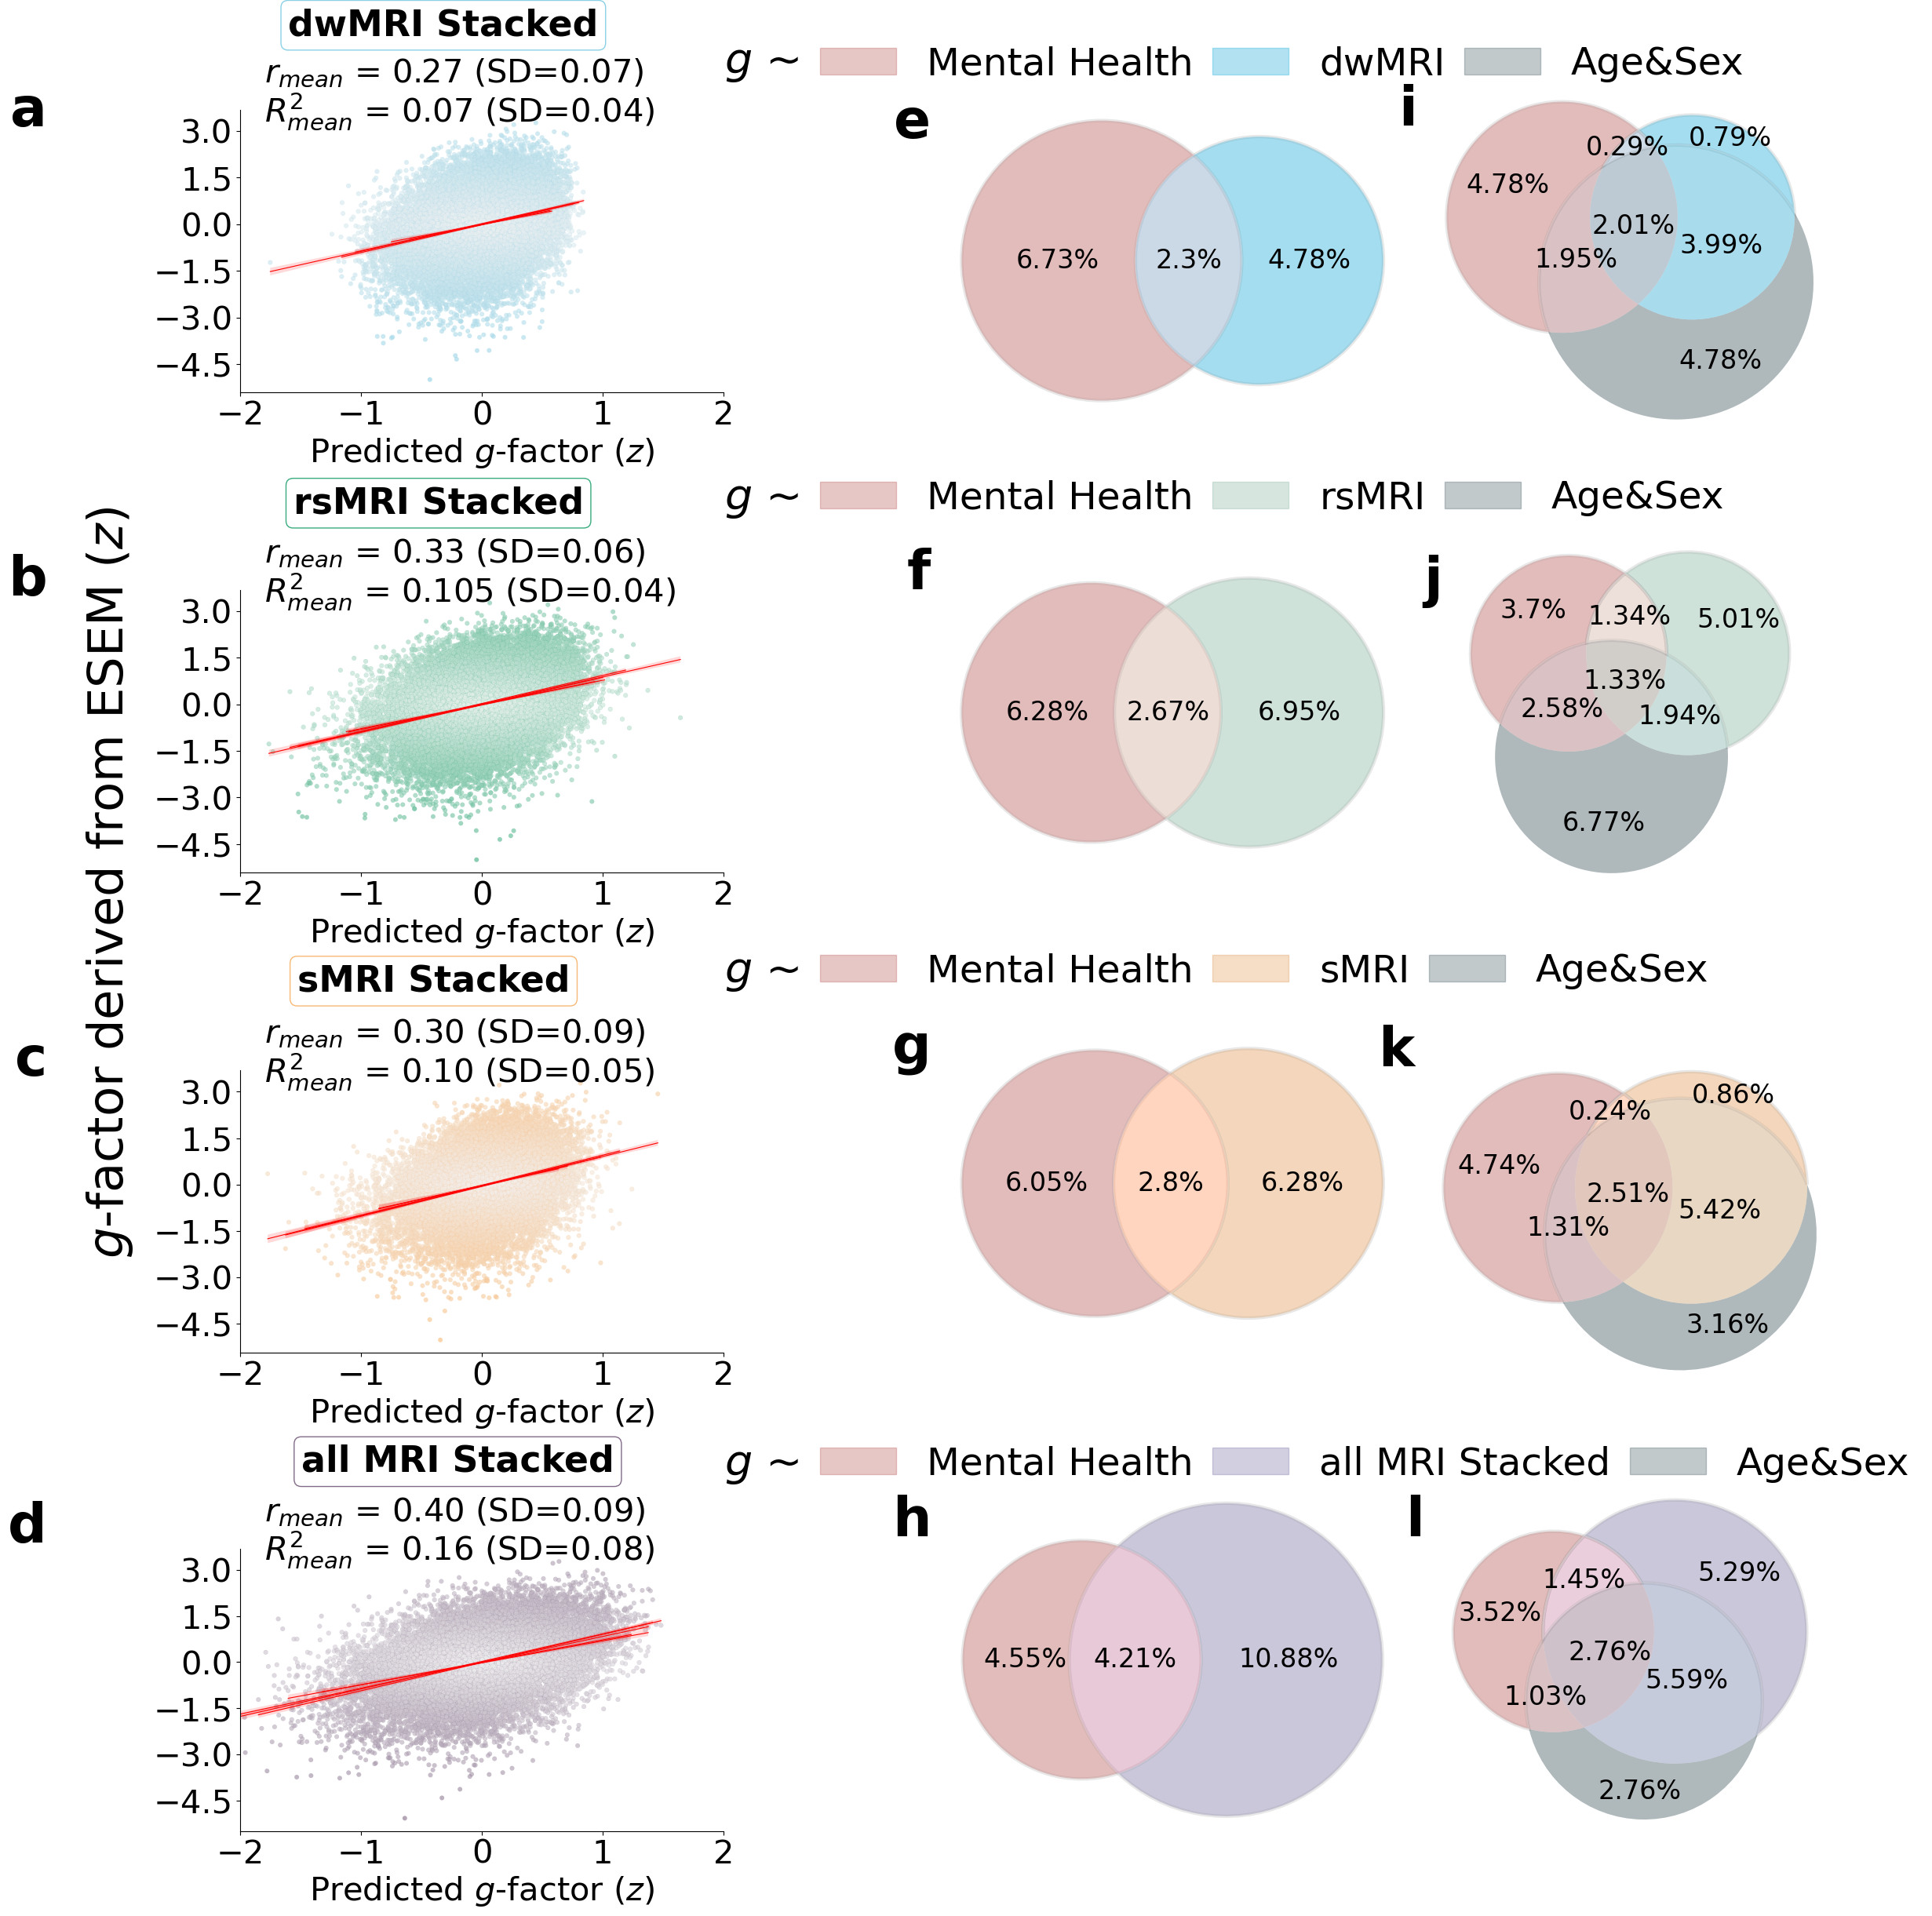

In [ ]:
# Plot scatterplots and commonality analysis together
fig = plt.figure(figsize=(22, 24))

data_venn2 = [
    (u_mh_dti_na.round(3), u_dti_na.round(3), c_mh_and_dti_na.round(3), '#B24745FF', '#00A1D599', 'dwMRI', "$g$ ~"),
    (u_mh_rs_na.round(3), u_rs_na.round(3), c_mh_and_rs_na.round(3), '#B24745FF', '#79AF9799', 'rsMRI', "$g$ ~"),
    (u_mh_t1_na.round(3), u_t1_na.round(3), c_mh_and_t1_na.round(3), '#B24745FF', '#DF8F4499', 'sMRI', "$g$ ~"),
    (u_mh_mri_na.round(3), u_mri_na.round(3), c_mh_and_mri_na.round(3), '#B24745FF', '#6A659999', 'all MRI Stacked', "$g$ ~")
]


# Rearranged data for venn3
data_venn3 = [
    ((u_mh_dti.round(3), u_dti.round(3), c_mh_and_dti.round(3), u_demo_dti.round(3), c_mh_and_demo_dti.round(3), c_dti_and_demo.round(3), c_mh_and_dti_and_demo.round(3)),
     ('#B24745FF', '#00A1D599', '#374E5599'), ('Mental Health', 'dwMRI', 'Age and Sex')),
    ((u_mh_rs.round(3), u_rs.round(3), c_mh_and_rs.round(3), u_demo_rs.round(3), c_mh_and_demo_rs.round(3), c_rs_and_demo.round(3), c_mh_and_rs_and_demo.round(3)),
     ('#B24745FF', '#79AF9799', '#374E5599'), ('Mental Health', 'rsMRI', 'Age and Sex')),
    ((u_mh_t1.round(3), u_t1.round(3), c_mh_and_t1.round(3), u_demo_t1.round(3), c_mh_and_demo_t1.round(3), c_t1_and_demo.round(3), c_mh_and_t1_and_demo.round(3)),
     ('#B24745FF', '#DF8F4499', '#374E5599'), ('Mental Health', 'T1w/T2w MRI', 'Age and Sex')),
    ((u_mh_mri.round(3), u_mri.round(3), c_mh_and_mri.round(3), u_demo_mri.round(3), c_mh_and_demo_mri.round(3), c_mri_and_demo.round(3), c_mh_and_mri_and_demo.round(3)),
     ('#B24745FF', '#6A659999', '#374E5599'), ('Mental Health', 'all MRI Stacked', 'Age&Sex'))
]
 
# Define the positions of each subplot
positions = [
    [0.05, 0.76, 0.28, 0.15], [0.45, 0.73, 0.28, 0.2], [0.73, 0.73, 0.25, 0.2],
    [0.05, 0.505 , 0.28, 0.15], [0.45, 0.49 , 0.28, 0.2], [0.73, 0.49, 0.25, 0.2],
    [0.05, 0.25, 0.28, 0.15], [0.45, 0.24, 0.28, 0.2], [0.73, 0.22, 0.25, 0.2],
    [0.05, -0.004, 0.28, 0.15], [0.45, -0.013, 0.28, 0.2], [0.73, -0.013, 0.25, 0.2]
]

# Create subplots at the specified positions
axes = []
for pos in positions:
    axes.append(fig.add_axes(pos))
    
# Plot scatter plots on the left side
dticmap = sns.light_palette("#8cd0e5", as_cmap=True)
rscmap = sns.light_palette("#39ab7e", as_cmap=True)
t1cmap = sns.light_palette("#f8b976", as_cmap=True)
stackcmap = sns.light_palette("#826b88", as_cmap=True)

create_scatter_plot(axes[0], y_true_dti, y_pred_dti, '', dticmap, '#8cd0e5',
                    r_mean_dti, r_std_dti, r2_mean_dti, r2_std_dti,
                    folds_data, 'dti')
axes[0].set_xlim(-2, 2)
create_scatter_plot(axes[3], y_true_rs, y_pred_rs, '', rscmap, "#39ab7e",
                    r_mean_rs, r_std_rs, r2_mean_rs, r2_std_rs,
                    folds_data, 'rs')
axes[3].set_xlim(-2, 2)
create_scatter_plot(axes[6], y_true_t1, y_pred_t1, '', t1cmap, "#f8b976",
                    r_mean_t1, r_std_t1, r2_mean_t1, r2_std_t1,
                    folds_data, 't1t2')
axes[6].set_xlim(-2, 2)
create_scatter_plot(axes[9], y_true_stack, y_pred_stack, '', stackcmap, "#826b88",
                    r_mean_stack, r_std_stack, r2_mean_stack, r2_std_stack,
                    folds_data, 'all')
axes[9].set_xlim(-2, 2)

# Plot Venn diagrams on the right side
for i in range(4):

    # Venn diagrams for venn2
    u_mh_dti_na, u_dti_na, c_mh_and_dti_na, color1, color2, label, title = data_venn2[i]
    subset_sizes = (u_mh_dti_na, u_dti_na, c_mh_and_dti_na)
    colors = (color1, color2)
    venn = venn2(subsets=subset_sizes, set_labels=('', ''), set_colors=colors, ax=axes[i*3+1])

    # Apply transparency and set line width
    alphas = (0.20, 0.20)
    for patch, alpha in zip(venn.patches, alphas):
        if patch:
            patch.set_alpha(alpha)
            patch.set_edgecolor('white')
            patch.set_linewidth(2)
            patch.set_path_effects([path_effects.withStroke(linewidth=3, foreground='grey')])
            
    # Set font size for labels
    for text in venn.set_labels:
        text.set_fontsize(24)
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(24)
            text.set_text(f'{text.get_text()}%')

    # Move annotations within the circles
    lab = venn.get_label_by_id('10') #left
    if lab:
        x, y = lab.get_position()
        lab.set_position((x + 0.03, y))

    lab = venn.get_label_by_id('01') #middle
    if lab:
        x, y = lab.get_position()
        lab.set_position((x - 0.01, y))

    # Adjust position of 'g~' in legend
    if i == 0:
        axes[i*3+1].set_title(title, fontsize=40, pad=3, y=1.0387, x=-0.35) # 1st
    elif i == 1:
        axes[i*3+1].set_title(title, fontsize=40, pad=3, y=1.105, x=-0.35) # 2nd
    elif i == 3:
        axes[i*3+1].set_title(title, fontsize=40, pad=3, y=0.98, x=-0.35) # the last legend
    else:
        # Keep the rest of the legends as they are
        axes[i*3+1].set_title(title, fontsize=40, pad=3, y=1.095, x=-0.35)

    # Create custom legend for each subplot
    handles = [
        patches.Patch(color=color1, alpha=0.3, label='Mental Health'),
        patches.Patch(color=color2, alpha=0.3, label=label),
        patches.Patch(color='#374E5599', alpha=0.3, label='Age&Sex')
    ]
    # Add legend elements
    if i == 0:
        axes[i*3+1].legend(handles=handles, loc='upper left', bbox_to_anchor=(-0.3, 1.23), ncol=3, fontsize=35, title='', frameon=False, columnspacing=0.5) # the first legend
    elif i == 1:
        axes[i*3+1].legend(handles=handles, loc='upper left', bbox_to_anchor=(-0.3, 1.31), ncol=3, fontsize=35, title='', frameon=False, columnspacing=0.5) # second row legend
    elif i == 2:
        axes[i*3+1].legend(handles=handles, loc='upper left', bbox_to_anchor=(-0.3, 1.30), ncol=3, fontsize=35, title='', frameon=False, columnspacing=0.5) # third row legend
    elif i == 3:
        axes[i*3+1].legend(handles=handles, loc='upper left', bbox_to_anchor=(-0.3, 1.16), ncol=3, fontsize=35, title='', frameon=False, columnspacing=0.5) # the last legend

    #axes[i*3+1].set_aspect(0.7)

for i in range(4):

    # Venn diagrams for venn3
    subset_sizes, colors, labels = data_venn3[i]
    venn = venn3(subsets=subset_sizes, set_labels=['', '', ''], set_colors=colors, ax=axes[i*3+2])

    # Apply transparency and set line width
    alphas = (0.20, 0.20, 0.20)
    for patch, alpha in zip(venn.patches, alphas):
        if patch:
            patch.set_alpha(alpha)
            patch.set_edgecolor('white')
            patch.set_linewidth(2)
            patch.set_path_effects([path_effects.withStroke(linewidth=3, foreground='grey')])

            #t = transforms.Affine2D().rotate_deg(45) + axes[i*3+2].transData
            #patch.set_transform(t)

    # Set font size for labels
    for text in venn.set_labels:
        text.set_fontsize(24)
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(24)
            text.set_text(f'{text.get_text()}%')

    # Move annotations within the circles
    lab = venn.get_label_by_id('100') #left
    if lab:
        x, y = lab.get_position()
        lab.set_position((x + 0.05, y))

        lab = venn.get_label_by_id('010') #left
    if lab:
        x, y = lab.get_position()
        lab.set_position((x - 0.01, y))

# Add letters to subplots
labels = ['a', 'e', 'i', 'b', 'f', 'j', 'c', 'g', 'k', 'd', 'h', 'l']
positions = [
    (-0.4, 1.09), (-0.0, 0.98), (-0.0, 0.97),
    (-0.4, 1.13), (-0.0, 1.0), (-0.0, 0.92),
    (-0.4, 1.13), (-0.0, 0.985), (-0.0, 1.05),
    (-0.4, 1.17), (-0.0, 0.94), (-0.0, 0.938)
]

for i in range(len(axes)):
    axes[i].text(positions[i][0], positions[i][1], labels[i], transform=axes[i].transAxes,
                 fontsize=50,  fontweight='bold', va='top', ha='right')
#plt.subplots_adjust(wspace=0.05, hspace=1.8)
plt.tight_layout()  # Adjust the rect parameter to fit the legends more tightly rect=[0, 0, 1, 1]

# Common y axis for scatterplots
fig.text(-0.04, 0.5, '$g$-factor derived from ESEM ($z$)', va='center', rotation='vertical', fontsize=45)
#fig.text(0.35, 0.8, 'dwMRI Stacked', ha='center', fontsize=20, bbox=dict(facecolor='none', edgecolor='#826b88', boxstyle='round', pad=0.5)) #fontweight='bold',

axes[0].set_title('dwMRI Stacked', fontsize=33, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#8cd0e5', boxstyle='round', pad=0.2), y=1.242, x=0.42)
axes[3].set_title('rsMRI Stacked', fontsize=33, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#39ab7e', boxstyle='round', pad=0.2), y=1.25, x=0.41)
axes[6].set_title('sMRI Stacked', fontsize=33, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#f8b976', boxstyle='round', pad=0.2), y=1.258, x=0.40)
axes[9].set_title('all MRI Stacked', fontsize=33, fontweight='bold', bbox=dict(facecolor='none', edgecolor='#826b88', boxstyle='round', pad=0.2), y=1.25, x=0.45)

plt.savefig("/Plots_and_Tables/final/svg/Fig5.svg",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='svg')

plt.show()

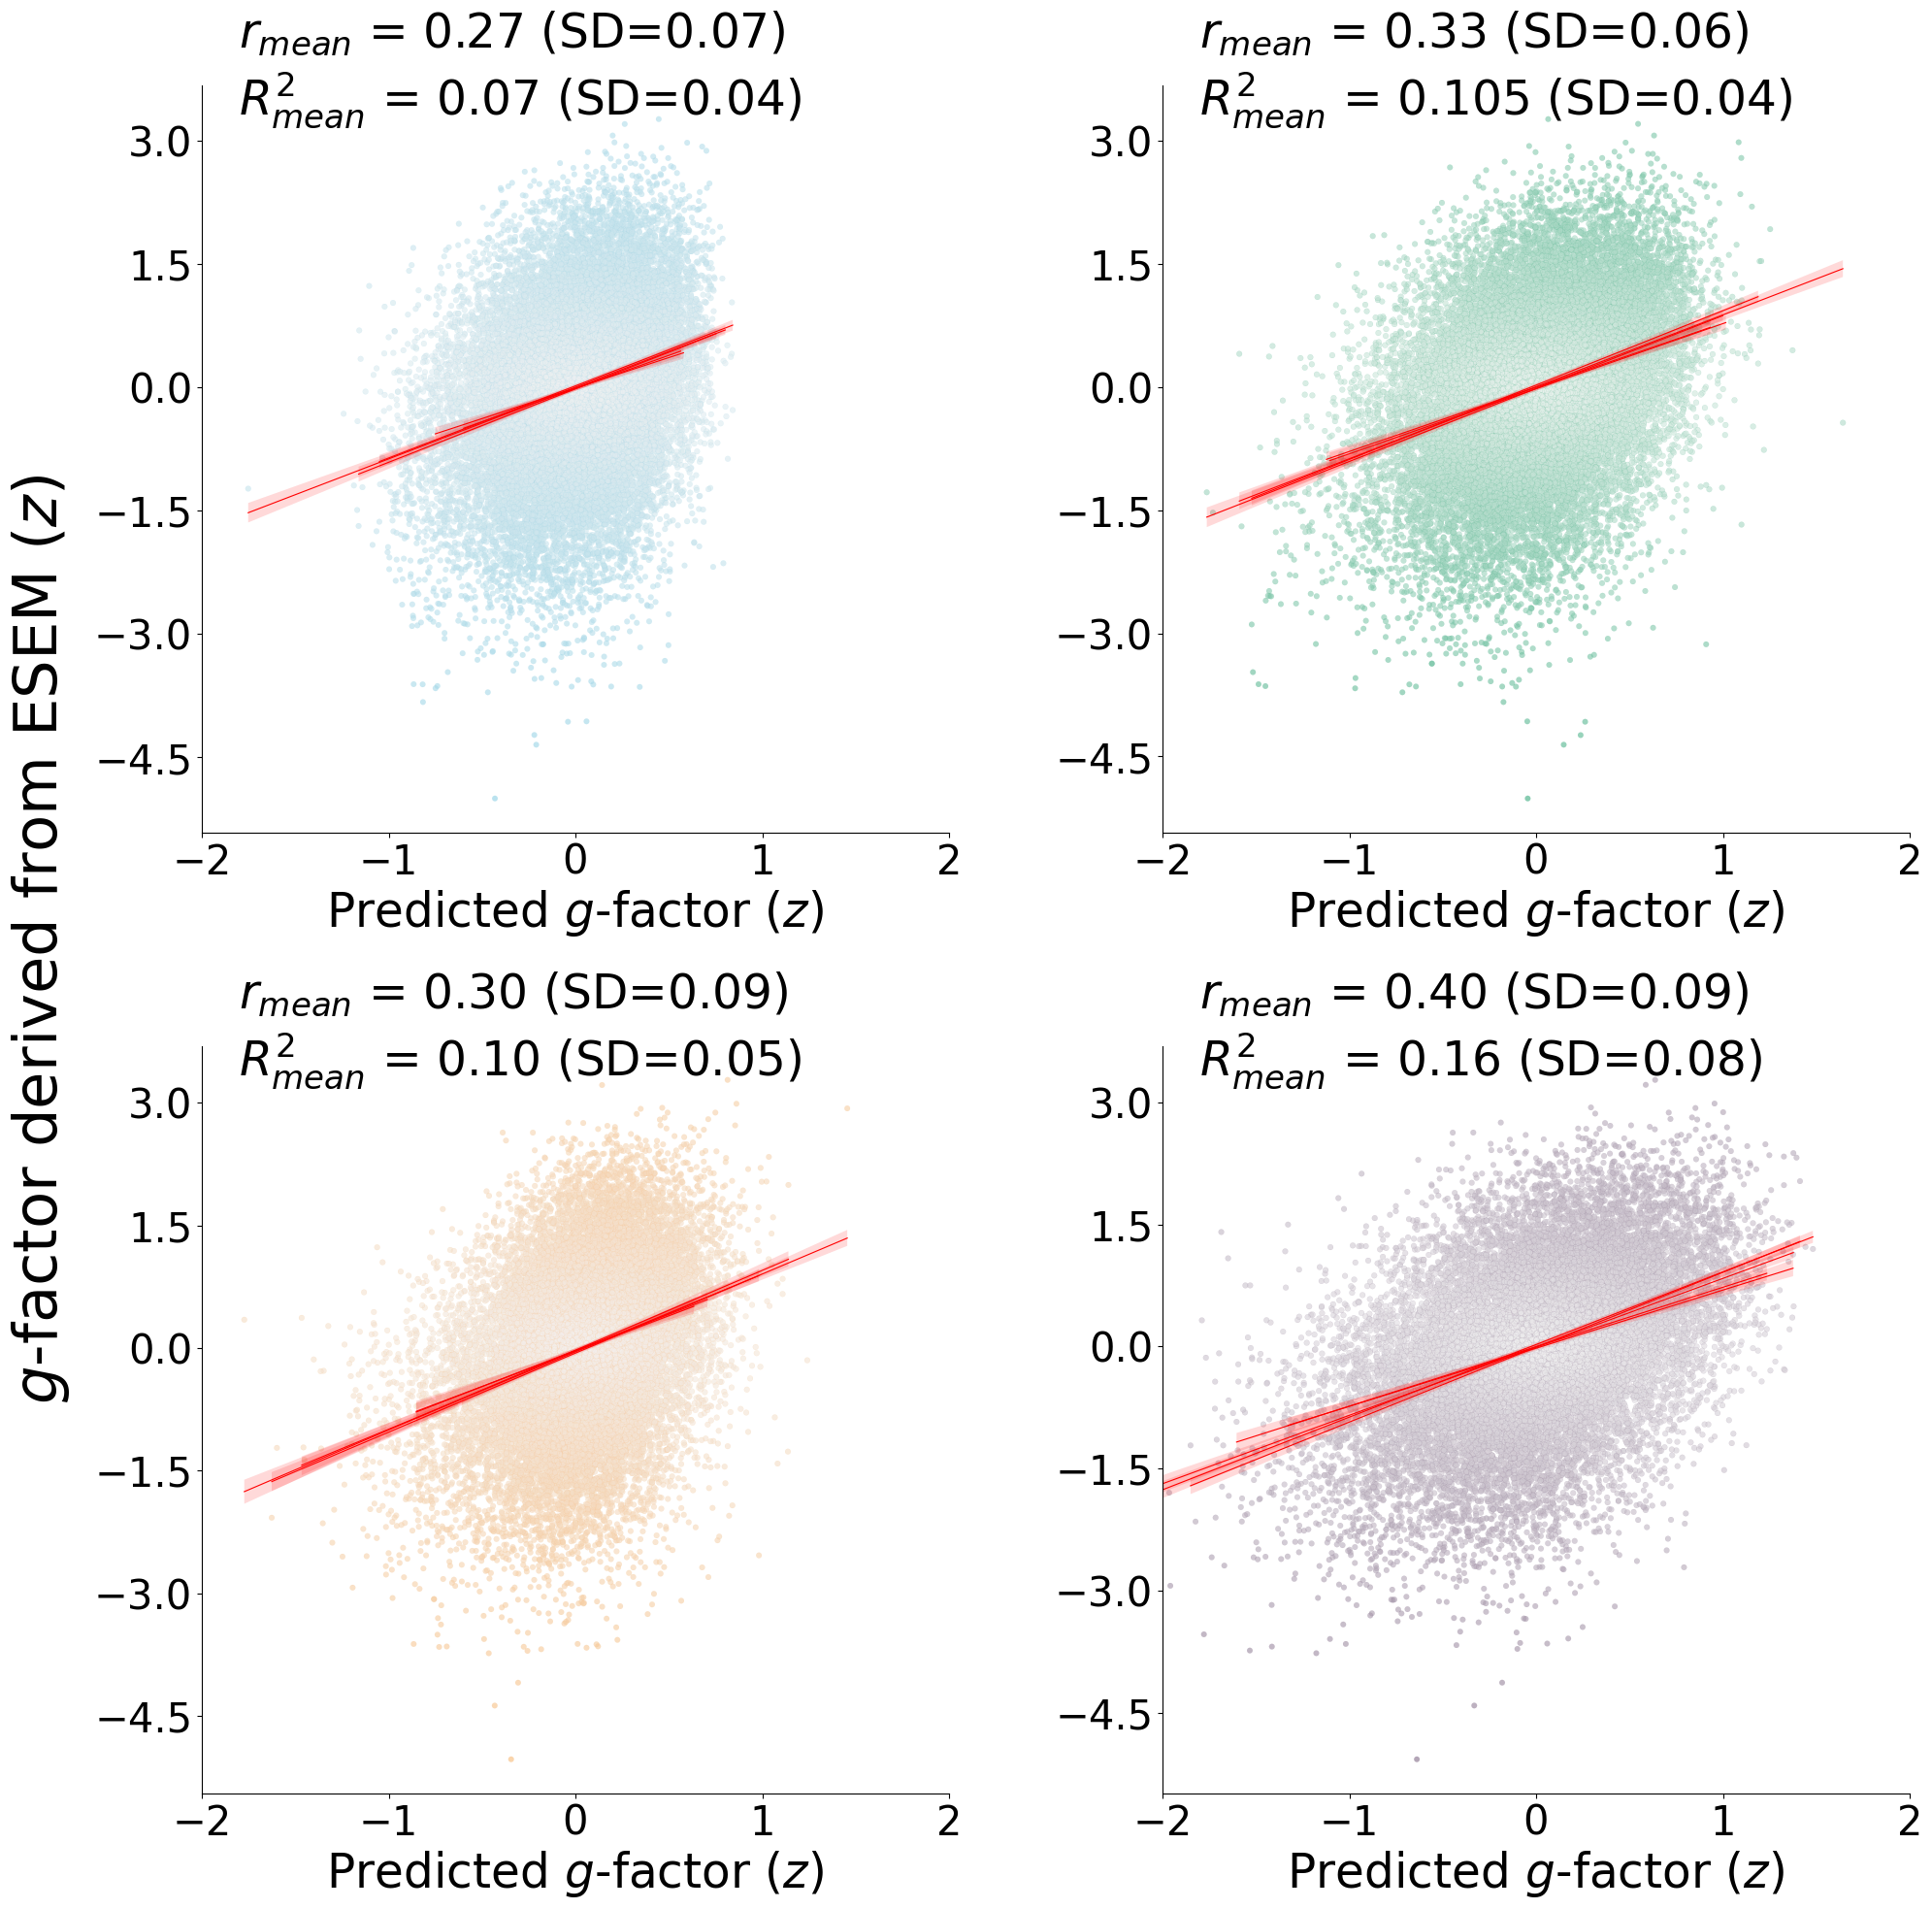

In [ ]:
# Plot only scatterplots in 2x2 grid
fig = plt.figure(figsize=(22, 22))  # Adjusted figure size for square layout

# Define the positions of each subplot in 2x2 grid
positions = [
    [0.1, 0.55, 0.35, 0.35],  # Top-left (dti)
    [0.55, 0.55, 0.35, 0.35],  # Top-right (rs)
    [0.1, 0.1, 0.35, 0.35],    # Bottom-left (t1)
    [0.55, 0.1, 0.35, 0.35]    # Bottom-right (all)
]

# Create subplots at the specified positions
axes = []
for pos in positions:
    axes.append(fig.add_axes(pos))
    
# Plot scatter plots
dticmap = sns.light_palette("#8cd0e5", as_cmap=True)
rscmap = sns.light_palette("#39ab7e", as_cmap=True)
t1cmap = sns.light_palette("#f8b976", as_cmap=True)
stackcmap = sns.light_palette("#826b88", as_cmap=True)

create_scatter_plot(axes[0], y_true_dti, y_pred_dti, '', dticmap, '#8cd0e5',
                    r_mean_dti, r_std_dti, r2_mean_dti, r2_std_dti,
                    folds_data, 'dti')
axes[0].set_xlim(-2, 2)
create_scatter_plot(axes[1], y_true_rs, y_pred_rs, '', rscmap, "#39ab7e",
                    r_mean_rs, r_std_rs, r2_mean_rs, r2_std_rs,
                    folds_data, 'rs')
axes[1].set_xlim(-2, 2)
create_scatter_plot(axes[2], y_true_t1, y_pred_t1, '', t1cmap, "#f8b976",
                    r_mean_t1, r_std_t1, r2_mean_t1, r2_std_t1,
                    folds_data, 't1t2')
axes[2].set_xlim(-2, 2)
create_scatter_plot(axes[3], y_true_stack, y_pred_stack, '', stackcmap, "#826b88",
                    r_mean_stack, r_std_stack, r2_mean_stack, r2_std_stack,
                    folds_data, 'all')
axes[3].set_xlim(-2, 2)


# Common y axis for scatterplots
fig.text(0.01, 0.5, '$g$-factor derived from ESEM ($z$)', va='center', rotation='vertical', fontsize=45)

plt.savefig("Fig5_scatter_2x2.png",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='png')

plt.show()

/tmp/ipykernel_115034/227594552.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


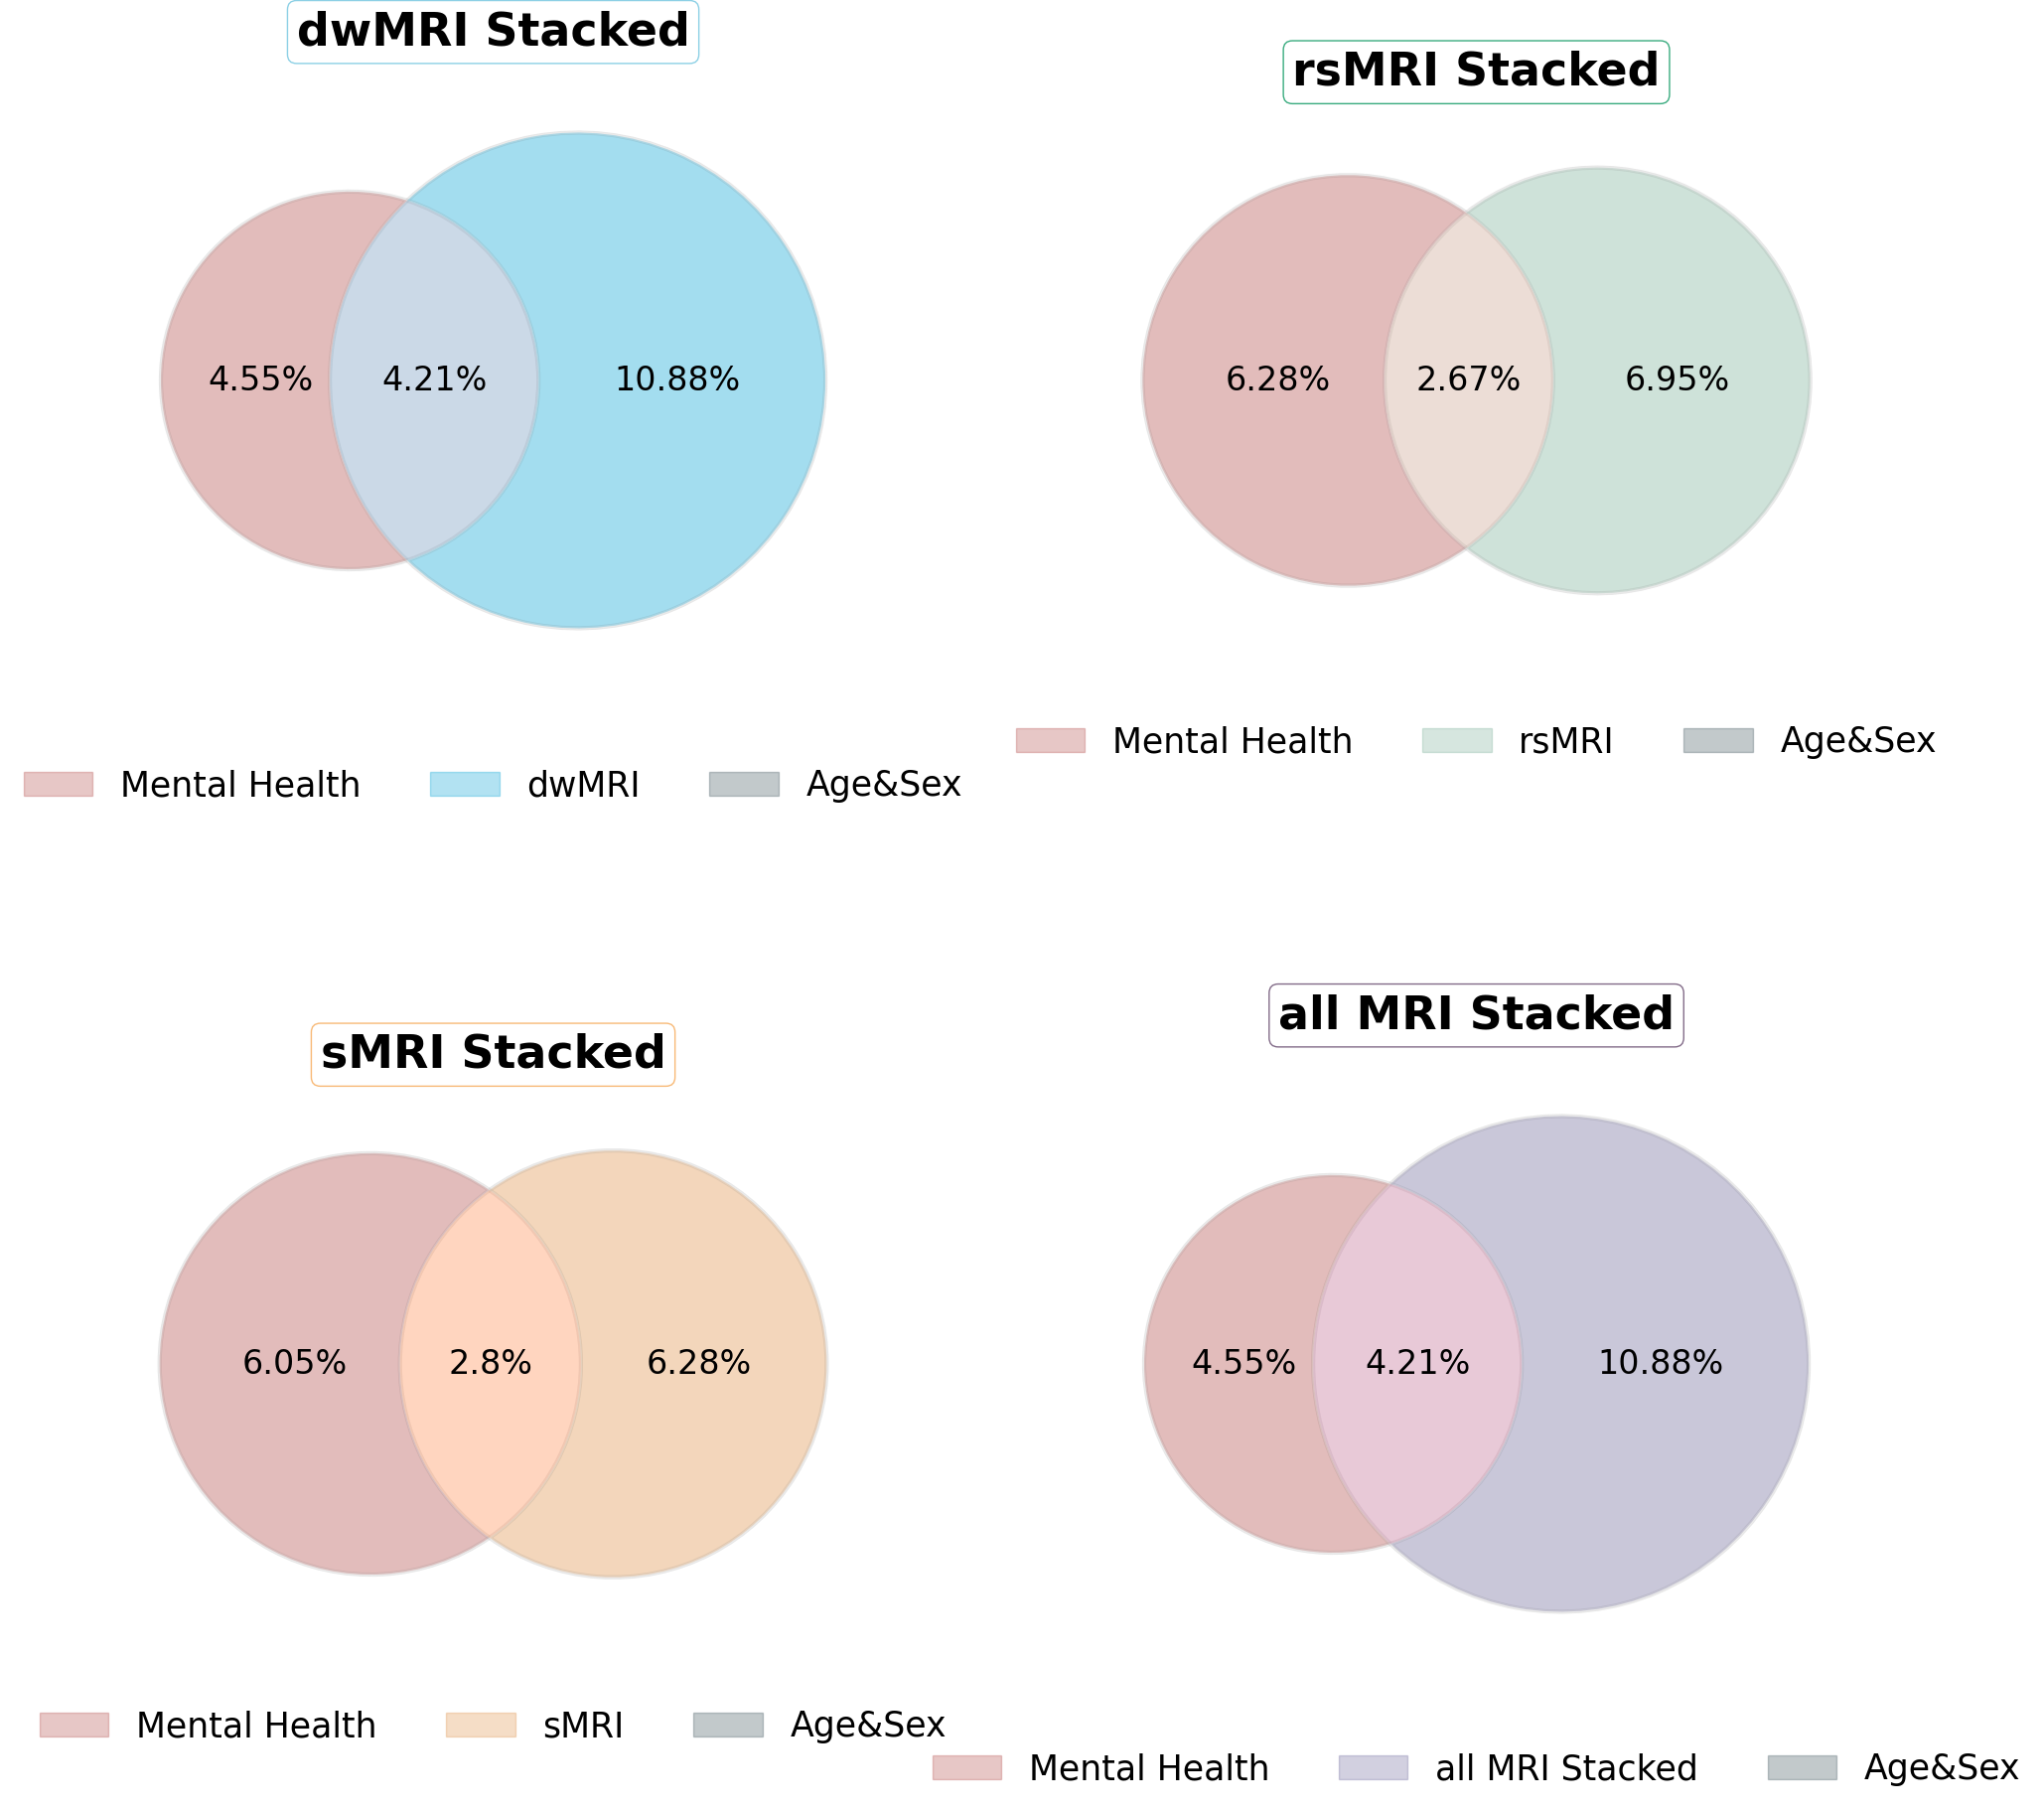

In [ ]:
# Plot only Venn diagrams in 2x2 grid
fig = plt.figure(figsize=(22, 22))  # Square figure for grid layout

# Define the positions for a 2x2 grid
positions = [
    [0.1, 0.55, 0.35, 0.35],  # Top-left (dti)
    [0.55, 0.55, 0.35, 0.35],  # Top-right (rs)
    [0.1, 0.1, 0.35, 0.35],    # Bottom-left (t1)
    [0.55, 0.1, 0.35, 0.35]    # Bottom-right (all)
]

# Create subplots at the specified positions
axes = []
for pos in positions:
    axes.append(fig.add_axes(pos))

# Venn diagram data (simplified for grid layout)
venn_data = [
    # (venn2_data, venn3_data, title)
    (data_venn2[0], data_venn3[0], 'dwMRI Stacked'),
    (data_venn2[1], data_venn3[1], 'rsMRI Stacked'),
    (data_venn2[2], data_venn3[2], 'sMRI Stacked'),
    (data_venn2[3], data_venn3[3], 'all MRI Stacked')
]

# Plot Venn diagrams in grid
for i, ax in enumerate(axes):
    # Get the data for this position
    venn2_item, venn3_item, title = venn_data[i]
    
    # Unpack venn2 data
    u_mh, u_mod, c_mh_and_mod, color1, color2, label, _ = venn2_item
    
    # Create venn2 diagram
    subset_sizes = (u_mh, u_mod, c_mh_and_mod)
    colors = (color1, color2)
    venn = venn2(subsets=subset_sizes, set_labels=('', ''), set_colors=colors, ax=ax)
    
    # Apply styling
    alphas = (0.20, 0.20)
    for patch, alpha in zip(venn.patches, alphas):
        if patch:
            patch.set_alpha(alpha)
            patch.set_edgecolor('white')
            patch.set_linewidth(2)
            patch.set_path_effects([path_effects.withStroke(linewidth=3, foreground='grey')])
    
    # Set font size for labels
    for text in venn.set_labels:
        text.set_fontsize(24)
    for text in venn.subset_labels:
        if text:
            text.set_fontsize(24)
            text.set_text(f'{text.get_text()}%')
    
    # Move annotations within the circles
    lab = venn.get_label_by_id('10')  # left
    if lab:
        x, y = lab.get_position()
        lab.set_position((x + 0.03, y))
    
    lab = venn.get_label_by_id('01')  # right
    if lab:
        x, y = lab.get_position()
        lab.set_position((x - 0.01, y))
    
    # Add title
    edge_colors = ['#8cd0e5', '#39ab7e', '#f8b976', '#826b88']
    ax.set_title(title, fontsize=33, fontweight='bold', 
                bbox=dict(facecolor='none', edgecolor=edge_colors[i], 
                         boxstyle='round', pad=0.2), y=1.05)
    
    # Add legend (simplified for grid layout)
    handles = [
        patches.Patch(color=color1, alpha=0.3, label='Mental Health'),
        patches.Patch(color=color2, alpha=0.3, label=label),
        patches.Patch(color='#374E5599', alpha=0.3, label='Age&Sex')
    ]
    ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), 
             ncol=3, fontsize=25, frameon=False)

plt.tight_layout()

plt.savefig("/Venn_diagrams_2x2.svg",
            bbox_inches="tight", 
            pad_inches=1, 
            transparent=False, 
            facecolor="w", 
            edgecolor='w', 
            orientation='landscape',
            format='svg')

plt.show()

# Compute correlation between PLSR performance and % of variance explained

In [ ]:
# Commonality metrics PLS
commonality_metrics_struct_pls = pd.read_csv('/commonality_analysis/var_explained_struct_full_renamed.csv').rename(columns={'Unnamed: 0':'Modality'})[['Modality', 'Var Exp MRI']]
commonality_metrics_rs_pls = pd.read_csv('/commonality_analysis/var_explained_rs_full_renamed.csv').rename(columns={'Unnamed: 0':'Modality'})[['Modality', 'Var Exp MRI']]
commonality_metrics_dti_pls = pd.read_csv('/commonality_analysis/var_explained_dti_full_renamed.csv').rename(columns={'Unnamed: 0':'Modality'})[['Modality', 'Var Exp MRI']]

# Commonality metrics stack
commonality_metrics_stack = pd.read_csv('/PLS/brain/commonality_analysis/commonality_metrics_stack.csv')[['Modality', 'Var Exp MRI']]

## Model performance
# Model performance PLS sMRI
struct_perf_pls = pd.read_csv('/PLS/brain/performance/struct_perf_pls_mean.csv')[['Modality', 'R2', 'Pearson r']]
# Model performance PLS RS
rs_perf_pls = pd.read_csv('/PLS/brain/performance/rs_perf_pls_mean.csv')[['Modality', 'R2', 'Pearson r']]
# Model performance PLS DTI
dti_perf_pls = pd.read_csv('/PLS/brain/performance/dti_perf_pls_mean.csv')[['Modality', 'R2', 'Pearson r']]


# Model performance stack
rs_perf_stack = pd.read_csv('/PLS/brain/stacking/RS_IDP_Timeseries_best_metrics_stacked_five_folds.csv')[['Algorithm', 'MSE', 'MAE', 'R2', 'Pearson r']].groupby(['Algorithm']).mean().round(3).reset_index().sort_values(by='Pearson r', ascending=False)
rs_perf_stack_rf = rs_perf_stack[rs_perf_stack['Algorithm']=='rf']
rs_perf_stack_rf['Modality'] = 'rsMRI'
rs_perf_stack_rf = rs_perf_stack_rf[['Modality', 'R2', 'Pearson r']]

dti_perf_stack = pd.read_csv('/PLS/brain/stacking/DTI_All_stacked_five_folds.csv')[['Algorithm', 'MSE', 'MAE', 'R2', 'Pearson r']].groupby(['Algorithm']).mean().round(3).reset_index().sort_values(by='Pearson r', ascending=False)
dti_perf_stack_rf = dti_perf_stack[dti_perf_stack['Algorithm']=='rf']
dti_perf_stack_rf['Modality'] = 'dwMRI'
dti_perf_stack_rf = dti_perf_stack_rf[['Modality', 'R2', 'Pearson r']]

struct_perf_stack = pd.read_csv('/PLS/brain/stacking/T1_T2_whole_brain_stacked_five_folds.csv')[['Algorithm', 'MSE', 'MAE', 'R2', 'Pearson r']].groupby(['Algorithm']).mean().round(3).reset_index().sort_values(by='Pearson r', ascending=False)
struct_perf_stack_svr = struct_perf_stack[struct_perf_stack['Algorithm']=='svr']
struct_perf_stack_svr['Modality'] = 'T1w/T2w MRI'
struct_perf_stack_svr = struct_perf_stack_svr[['Modality', 'R2', 'Pearson r']]

all_mod_perf_stack = pd.read_csv('/PLS/brain/stacking/All_modalities_stacked_five_folds.csv')[['Algorithm', 'MSE', 'MAE', 'R2', 'Pearson r']].groupby(['Algorithm']).mean().round(3).reset_index().sort_values(by='Pearson r', ascending=False)
all_mod_perf_stack = all_mod_perf_stack[all_mod_perf_stack['Algorithm']=='xgb']
all_mod_perf_stack['Modality'] = 'Stacked MRI'
all_mod_perf_stack = all_mod_perf_stack[['Modality', 'R2', 'Pearson r']]

## Merge results of predicion and commonality analysis
# Stacked
stack_perf = pd.concat([rs_perf_stack_rf, dti_perf_stack_rf, struct_perf_stack_svr, all_mod_perf_stack], axis=0)
stack_res = pd.merge(stack_perf, commonality_metrics_stack, on = 'Modality')

In [5]:
# Rename PLS results to match commonality
# Struct
struct_rename_dict = {
    "Subcortical volumetric subsegmentation": "Subcortical Volumetric Subseg.",
    "ASEG volume": "ASEG Volume",
    "FSL FAST": "FSL FAST",
    "Whole-brain T1/T2": "Whole-brain T1/T2",
    "ASEG mean intensity": "ASEG Mean Thickness",
    "Desikan grey/white matter intensity": "Desikan GM/WM Intensity",
    "aparc a2009s volume": "aparc.a2009s Volume",
    "aparc a2009s mean thickness": "aparc.a2009s Mean Thickness",
    "Desikan-Killiany-Tourville volume": "DKT Volume",
    "Desikan white matter mean thickness": "Desikan WM Mean Thickness",
    "Desikan-Killiany-Tourville mean thickness": "DKT Mean Thickness",
    "aparc a2009s area": "aparc.a2009s Area",
    "Desikan white matter volume": "Desikan WM Volume",
    "FSL FIRST": "FSL FIRST",
    "Desikan pial": "Desikan Pial",
    "BA ex-vivo volume": "BA ex-vivo Volume",
    "BA ex-vivo mean thickness": "BA ex-vivo Mean Thickness",
    "Desikan-Killiany-Tourville area": "DKT Area",
    "Desikan white matter area": "Desikan WM Area",
    "BA ex-vivo area": "BA ex-vivo Area"
}

struct_perf_pls["Modality"] = struct_perf_pls["Modality"].map(struct_rename_dict)

# RS
rs_rename_dict = {
    "Tangent matrices 55 IC": "55 IC Func. Connectivity",
    "Schaefer7n200p MSA I Full correlation": "Schaefer200-I Func. Connectivity",
    "Schaefer7n500p MSA IV Full correlation": "Schaefer500-IV Func. Connectivity",
    "Glasser MSA I Full correlation": "Glasser-I Func. Connectivity",
    "Tangent matrices 21 IC": "21 IC Func. Connectivity",
    "Glasser MSA IV Full correlation": "Glasser-IV Func. Connectivity",
    "aparc MSA I Full correlation": "aparc-I Func. Connectivity",
    "aparc a2009s MSA I Full correlation": "aparc.a2009s-I Func. Connectivity",
    "Amplitudes 55 IC": "55 IC Amplitudes",
    "Amplitudes 21 IC": "21 IC Amplitudes"
}
rs_perf_pls["Modality"] = rs_perf_pls["Modality"].map(rs_rename_dict)

# DTI
dti_rename_dict = {
    "aparc MSA I Connectome Streamline Count": "aparc-I Streamline Count",
    "aparc MSA I Connectome SIFT2": "aparc-I SIFT2",
    "aparc a2009s MSA I Connectome Streamline Count": "aparc.a2009s-I Streamline Count",
    "Schaefer7n200p MSA I Connectome Streamline Count": "Schaefer200-I Streamline Count",
    "Schaefer7n200p MSA I Connectome SIFT2": "Schaefer200-I SIFT2",
    "aparc MSA I Connectome FA": "aparc-I FA",
    "aparc a2009s MSA I Connectome FA": "aparc.a2009s-I FA",
    "aparc MSA I Connectome Mean Length": "aparc-I Mean Length",
    "aparc a2009s MSA I Connectome SIFT2": "aparc.a2009s-I SIFT2",
    "L2 TBSS": "L2 TBSS",
    "Schaefer7n200p MSA I Connectome FA": "Schaefer200-I FA",
    "aparc a2009s MSA I Connectome Mean Length": "aparc.a2009s-I Mean Length",
    "Glasser MSA IV Connectome SIFT2": "Glasser-IV SIFT2",
    "Glasser MSA IV Connectome Streamline Count": "Glasser-IV Streamline Count",
    "L3 TBSS": "L3 TBSS",
    "ICVF TBSS": "ICVF TBSS",
    "Glasser MSA IV Connectome FA": "Glasser-IV FA",
    "Schaefer7n500p MSA IV Connectome SIFT2": "Schaefer500-IV SIFT2",
    "L1 TBSS": "L1 TBSS",
    "Schaefer7n500p MSA IV Connectome Streamline Count": "Schaefer500-IV Streamline Count",
    "FA TBSS": "FA TBSS",
    "Glasser MSA I Connectome FA": "Glasser-I FA",
    "Schaefer7n200p MSA I Connectome Mean Length": "Schaefer200-I Mean Length",
    "MD TBSS": "MD TBSS",
    "MD Probabilistic": "MD Prob.",
    "Glasser MSA I Connectome Streamline Count": "Glasser-I Streamline Count",
    "L3 Probabilistic": "L3 Prob.",
    "Schaefer7n500p MSA IV Connectome FA": "Schaefer500-IV FA",
    "Glasser MSA I Connectome SIFT2": "Glasser-I SIFT2",
    "L2 Probabilistic": "L2 Prob.",
    "L1 Probabilistic": "L1 Prob.",
    "ISOVF TBSS": "ISOVF TBSS",
    "Glasser MSA IV Connectome Mean Length": "Glasser-IV Mean Length",
    "Glasser MSA I Connectome Mean Length": "Glasser-I Mean Length",
    "OD TBSS": "OD TBSS",
    "ICVF Probabilistic": "ICVF Prob.",
    "MO TBSS": "MO TBSS",
    "ISOVF Probabilistic": "ISOVF Prob.",
    "FA Probabilistic": "FA Prob.",
    "Schaefer7n500p MSA IV Connectome Mean Length": "Schaefer500-IV Mean Length",
    "OD Probabilistic": "OD Prob.",
    "MO Probabilistic": "MO Prob."
}

dti_perf_pls["Modality"] = dti_perf_pls["Modality"].map(dti_rename_dict)

In [6]:
dti_pls_res = pd.merge(dti_perf_pls, commonality_metrics_dti_pls, on = 'Modality')
rs_pls_res = pd.merge(rs_perf_pls, commonality_metrics_rs_pls, on = 'Modality')
struct_pls_res = pd.merge(struct_perf_pls, commonality_metrics_struct_pls, on = 'Modality')

pls_res = pd.concat([struct_pls_res, dti_pls_res, rs_pls_res], axis=0)
all_res = pd.concat([stack_res, pls_res], axis=0)

In [7]:
corr, p_value = pearsonr(pls_res['Pearson r'], pls_res['Var Exp MRI'])
corr

np.float64(0.9714714483681939)

In [ ]:
def get_bootstrap_ci(bootstrap_distribution, confidence_level=0.95):
    """Compute confidence intervals with input validation"""
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_distribution, (alpha / 2) * 100).round(3)
    upper = np.percentile(bootstrap_distribution, (1 - alpha / 2) * 100).round(3)
    return (lower, upper)


def save_dataframe_to_files(df, pathname, filename):
    """
    Save a pandas DataFrame to both CSV and Excel formats in the specified location.
    Creates directories if they don't exist.
    """
    # Ensure the filename doesn't include extensions
    base_name = os.path.splitext(filename)[0]
    
    # Create directory if it doesn't exist
    os.makedirs(pathname, exist_ok=True)
    
    # Create full paths
    csv_path = os.path.join(pathname, f"{base_name}.csv")
    excel_path = os.path.join(pathname, f"{base_name}.xlsx")
    
    try:
        # Save files
        df.to_csv(csv_path, index=False)
        df.to_excel(excel_path, index=False, engine='openpyxl')
        
        print(f"Files saved successfully:\n- {csv_path}\n- {excel_path}")
    except Exception as e:
        print(f"Error saving files: {str(e)}")



def bootstrap_pearson_correlation(df, x_col='Pearson r', y_col='Var Exp MRI', n_bootstraps=5000, ci_level=0.95, random_state=None):
    """
    Compute bootstrap confidence intervals for Pearson correlation between two columns
    
    Parameters:
    df : pd.DataFrame
        Input dataframe containing the variables
    x_col, y_col : str
        Column names for the two variables
    n_bootstraps : int
        Number of bootstrap samples (default: 5000)
    ci_level : float
        Confidence level (default: 0.95)
    random_state : int
        Random seed for reproducibility
        
    Returns:
    dict : Contains original correlation, p-value, CI, and full bootstrap distribution
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    x = df[x_col].values
    y = df[y_col].values
    n = len(x)
    
    # Original correlation
    original_r, original_p = pearsonr(x, y)
    
    # Bootstrap distribution
    boot_samples = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        idx = np.random.choice(n, n, replace=True)
        boot_samples[i] = pearsonr(x[idx], y[idx])[0]
    
    # Calculate CI using your existing function
    ci_lower, ci_upper = get_bootstrap_ci(boot_samples, confidence_level=ci_level)
    
    # Prepare results in your standard format
    results = {
        'Modality': 'Combined',  # Or specify as needed
        'Metric': 'r',
        'Mean': np.mean(boot_samples).round(3),
        'Median': np.median(boot_samples).round(3),
        'Std': np.std(boot_samples).round(3),
        'CI_lower': ci_lower,
        'CI_upper': ci_upper,
        'Original_r': original_r,
        'Original_p': original_p,
        'bootstrap_dist': boot_samples
    }
    
    return results

# Example usage with your data:
bootstrap_results = bootstrap_pearson_correlation(
    pls_res,
    x_col='Pearson r',
    y_col='Var Exp MRI',
    n_bootstraps=5000,
    ci_level=0.95,
    random_state=42
)

# Convert to DataFrame for consistency with your workflow
results_df = pd.DataFrame([{
    'Modality': bootstrap_results['Modality'],
    'Metric': bootstrap_results['Metric'],
    'Mean': bootstrap_results['Mean'],
    'Median': bootstrap_results['Median'],
    'Std': bootstrap_results['Std'],
    'CI_lower': bootstrap_results['CI_lower'],
    'CI_upper': bootstrap_results['CI_upper']
}])

# Save results using your existing function
save_dataframe_to_files(
    results_df,
    pathname='/bootstrap',
    filename='bootstrap_prediction_commonality'
)

# Print summary
print("\n=== Bootstrap Results for Pearson r ~ Var Exp MRI ===")
print(f"Original correlation: {bootstrap_results['Original_r']:.3f}")
print(f"Original p-value: {bootstrap_results['Original_p']:.4f}")
print(f"Bootstrapped 95% CI: [{bootstrap_results['CI_lower']:.3f}, {bootstrap_results['CI_upper']:.3f}]")

=== Bootstrap Results for Pearson r ~ Var Exp MRI ===

- Original correlation: 0.971
- Original p-value: 0.0000
- Bootstrapped 95% CI: [0.958, 0.982]

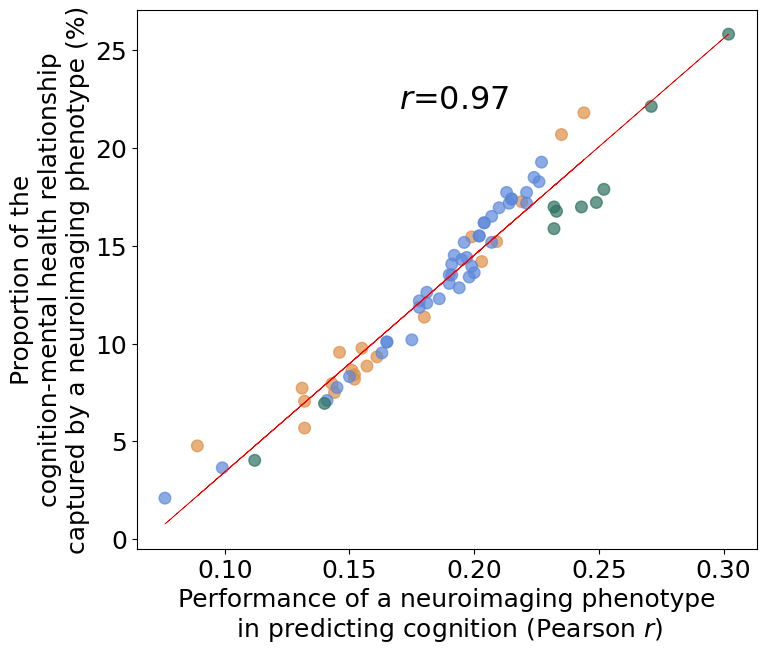

In [ ]:
# Scatterplot of correlation
colors = []
for modality in pls_res['Modality'].to_list():
    if modality in struct_pls_res['Modality'].to_list():
        colors.append('#DF8F44FF') #DF8F4499
    elif modality in dti_pls_res['Modality'].to_list():
        colors.append('#5C88DAFF') #00A1D599
    elif modality in rs_pls_res['Modality'].to_list():
        colors.append('#2C715FFF') #79AF9799
    else:
        colors.append('black')

#'#5C88DAFF', '#2C715FFF', '#DF8F44FF'
plt.figure(figsize=(8, 7))
plt.scatter(pls_res['Pearson r'], pls_res['Var Exp MRI'], s=70, alpha=0.7, linewidth=1, c=colors)
slope, intercept = np.polyfit(pls_res['Pearson r'], pls_res['Var Exp MRI'], 1)
reg_line = slope * pls_res['Pearson r'] + intercept
plt.plot(pls_res['Pearson r'], reg_line, color='red', label='Regression line', linewidth=0.5)
plt.xlabel('Performance of a neuroimaging phenotype\n in predicting cognition (Pearson $r$)', fontsize=18)
plt.ylabel('Proportion of the\ncognition-mental health relationship\ncaptured by a neuroimaging phenotype (%)', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.text(0.17, 22, '$r$=0.97', fontsize=23, color='black') 
plt.grid(False)


plt.savefig("/figures/Fig4a.png",
            bbox_inches ="tight", 
            pad_inches = 1, 
            transparent = False, 
            facecolor ="w", 
            edgecolor ='w', 
            orientation ='landscape',
            format='png')

plt.show()

# Demographics distribution in commonality analysis samples

## dwMRI

In [ ]:
all_g_mh_dti_demo_concat = []
for fold in folds:
    g_pred_dti_rf = pd.read_csv(f'/PLS/brain/stacking/g/DTI_All_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_dti_rf, on='eid').merge(demo, on='eid')
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_dti_all_stack_test': 'g_pred_dti'})
    all_g_mh_dti_demo_concat.append(all_g)
    all_g_mh_dti_demo = pd.concat(all_g_mh_dti_demo_concat, axis=0, ignore_index=True)

## rsMRI

In [ ]:
all_g_mh_rs_demo_concat = []
for fold in folds:
    g_pred_rs_idp_rf = pd.read_csv(f'/PLS/brain/stacking/g/RS_IDP_Timeseries_best_metrics_target_pred_2nd_level_rf_test_fold_{fold}.csv')
    g_pred_mh = g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_rs_idp_rf, on='eid').merge(demo, on='eid') #.drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_rs_idp_ts_best_stack_test': 'g_pred_rs_idp'})
    all_g_mh_rs_demo_concat.append(all_g)
    all_g_mh_rs_demo = pd.concat(all_g_mh_rs_demo_concat, axis=0, ignore_index=True)

## sMRI

In [ ]:
all_g_mh_t1_demo_concat = []
for fold in folds:
    g_pred_t1_svr = pd.read_csv(f'/PLS/brain/stacking/g/T1_T2_whole_brain_target_pred_2nd_level_svr_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_t1_svr, on='eid').merge(demo, on='eid') #.drop(columns=['eid'])
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_mribest_stack_test': 'g_pred_t1'}) #the column was incorrectly names g_pred_mribest_stack_test instead of g_pred_t1_stack_test
    all_g_mh_t1_demo_concat.append(all_g)
    all_g_mh_t1_demo = pd.concat(all_g_mh_t1_demo_concat, axis=0, ignore_index=True)

## All MRI

In [ ]:
all_g_mh_mri_demo_concat = []
for fold in folds:
    g_pred_mri_all = pd.read_csv(f'/PLS/brain/stacking/g/All_modalities_target_pred_2nd_level_xgb_test_fold_{fold}.csv')
    g_pred_mh = pd.concat([pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/g_pred/g_pred_mh_fold_{fold}.csv'), pd.read_csv(f'/PLS/2024/mental_health/folds/fold_{fold}/suppl/g_test_matched_id_fold_{fold}.csv')], axis=1)
    all_g = pd.read_csv(f'/PLS/g_factor/g_test_with_id_fold_{fold}.csv').merge(g_pred_mh, on='eid').merge(g_pred_mri_all, on='eid').merge(demo, on='eid')
    all_g = all_g.rename(columns={'g': 'g_real', 'g_pred_mribest_stack_test': 'g_pred_mri'})
    all_g_mh_mri_demo_concat.append(all_g)
    all_g_mh_mri_demo = pd.concat(all_g_mh_mri_demo_concat, axis=0) #, ignore_index=True)

In [ ]:
basic_confounds_min = pd.read_csv('/ML_DATASETS/basic_confounds_min.csv')[['Sex', 'Age when attended assessment centre', 'eid']]
age_sex = pd.DataFrame(basic_confounds_min)
age_sex.columns = ['Sex', 'Age', 'eid']
commonality_dw_age_sex = all_g_mh_dti_demo.copy()
commonality_rs_age_sex = all_g_mh_rs_demo.copy()
commonality_str_age_sex = all_g_mh_t1_demo.copy()
commonality_mri_age_sex = all_g_mh_mri_demo.copy()

In [173]:
# Check sample sizes for each modality
#dwMRI
print('dwMRI: Sample size', commonality_dw_age_sex.shape[0])
print('dwMRI: Mean age', commonality_dw_age_sex['Age'].mean().round(2))
print(f"dwMRI: SD age {commonality_dw_age_sex['Age'].std():.3f}")
print('dwMRI: Age when attended assessment centre, mean:', commonality_dw_age_sex['Age'].mean().round(2), 'SD:', f"{commonality_dw_age_sex['Age'].std():.3f}")
print('dwMRI: Age max range:', commonality_dw_age_sex['Age'].max())
print('dwMRI: Age min range:', commonality_dw_age_sex['Age'].min())
print('dwMRI: Proportion of males:', (commonality_dw_age_sex['Sex'].value_counts()[1] / len(commonality_dw_age_sex['Sex']) * 100).round(2))
print('dwMRI: Proportion of females:', (commonality_dw_age_sex['Sex'].value_counts()[0] / len(commonality_dw_age_sex['Sex']) * 100).round(2))

print('--------------------------------------------------------')
#rsMRI
print('rsMRI: Sample size', commonality_rs_age_sex.shape[0])
print('rsMRI: Mean age', commonality_rs_age_sex['Age'].mean().round(2))
print(f"rsMRI: SD age {commonality_rs_age_sex['Age'].std():.3f}")
print('rsMRI: Age when attended assessment centre, mean:', commonality_rs_age_sex['Age'].mean().round(2), 'SD:', f"{commonality_rs_age_sex['Age'].std():.3f}")
print('rsMRI: Age max range:', commonality_rs_age_sex['Age'].max())
print('rsMRI: Age min range:', commonality_rs_age_sex['Age'].min())
print('rsMRI: Proportion of males:', (commonality_rs_age_sex['Sex'].value_counts()[1] / len(commonality_rs_age_sex['Sex']) * 100).round(2))
print('rsMRI: Proportion of females:', (commonality_rs_age_sex['Sex'].value_counts()[0] / len(commonality_rs_age_sex['Sex']) * 100).round(2))

print('--------------------------------------------------------')
#sMRI
print('sMRI: Sample size', commonality_str_age_sex.shape[0])
print('sMRI: Mean age', commonality_str_age_sex['Age'].mean().round(2))
print(f"sMRI: SD age {commonality_str_age_sex['Age'].std():.3f}")
print('sMRI: Age when attended assessment centre, mean:', commonality_str_age_sex['Age'].mean().round(2), 'SD:', f"{commonality_str_age_sex['Age'].std():.3f}")
print('sMRI: Age max range:', commonality_str_age_sex['Age'].max())
print('sMRI: Age min range:', commonality_str_age_sex['Age'].min())
print('sMRI: Proportion of males:', (commonality_str_age_sex['Sex'].value_counts()[1] / len(commonality_str_age_sex['Sex']) * 100).round(2))
print('sMRI: Proportion of females:', (commonality_str_age_sex['Sex'].value_counts()[0] / len(commonality_str_age_sex['Sex']) * 100).round(2))

print('--------------------------------------------------------')
#MRI
print('MRI: Sample size', commonality_mri_age_sex.shape[0])
print('MRI: Mean age', commonality_mri_age_sex['Age'].mean().round(2))
print(f"MRI: SD age {commonality_mri_age_sex['Age'].std():.3f}")
print('MRI: Age when attended assessment centre, mean:', commonality_mri_age_sex['Age'].mean().round(2), 'SD:', f"{commonality_mri_age_sex['Age'].std():.3f}")
print('MRI: Age max range:', commonality_mri_age_sex['Age'].max())
print('MRI: Age min range:', commonality_mri_age_sex['Age'].min())
print('MRI: Proportion of males:', (commonality_mri_age_sex['Sex'].value_counts()[1] / len(commonality_mri_age_sex['Sex']) * 100).round(2))
print('MRI: Proportion of females:', (commonality_mri_age_sex['Sex'].value_counts()[0] / len(commonality_mri_age_sex['Sex']) * 100).round(2))

dwMRI: Sample size 17250
dwMRI: Mean age 64.25
dwMRI: SD age 7.528
dwMRI: Age when attended assessment centre, mean: 64.25 SD: 7.528
dwMRI: Age max range: 82.0
dwMRI: Age min range: 47.0
dwMRI: Proportion of males: 45.32
dwMRI: Proportion of females: 54.68
--------------------------------------------------------
rsMRI: Sample size 17005
rsMRI: Mean age 64.2
rsMRI: SD age 7.515
rsMRI: Age when attended assessment centre, mean: 64.2 SD: 7.515
rsMRI: Age max range: 82.0
rsMRI: Age min range: 47.0
rsMRI: Proportion of males: 45.08
rsMRI: Proportion of females: 54.92
--------------------------------------------------------
sMRI: Sample size 14793
sMRI: Mean age 64.21
sMRI: SD age 7.556
sMRI: Age when attended assessment centre, mean: 64.21 SD: 7.556
sMRI: Age max range: 82.0
sMRI: Age min range: 47.0
sMRI: Proportion of males: 45.38
sMRI: Proportion of females: 54.62
--------------------------------------------------------
MRI: Sample size 14256
MRI: Mean age 64.04
MRI: SD age 7.488
MRI: Ag